<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Airbus/Airbus_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AIR.PA"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02  12.10  12.63  11.86  12.63      10.42  1702735
2009-01-05  12.70  13.44  12.69  13.44      11.09  2628493
2009-01-06  13.44  13.93  13.43  13.78      11.37  2797192
2009-01-07  13.65  13.80  13.32  13.60      11.23  2319050
2009-01-08  13.36  13.49  13.10  13.42      11.07  2219720
...           ...    ...    ...    ...        ...      ...
2018-12-21  82.75  84.21  82.05  83.10      81.94  3670837
2018-12-24  81.54  82.58  81.20  81.63      80.49   392591
2018-12-27  82.92  83.73  81.06  82.10      80.96  1611466
2018-12-28  82.98  84.33  82.56  83.76      82.59  1257945
2018-12-31  83.83  84.22  83.27  83.96      82.79   426473

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     45.669174    46.191111    45.140606    45.683881    42.400712  2.349697e+06
std      26.182140    26.414833    25.931632    26.170933    26.265515  1.435910e+06
min       8.580000     8.790000     8.120000     8.470000     6.990000  0.000000e+00
25%      21.252500    21.615000    21.007500    21.325000    18.210000  1.560709e+06
50%      46.435000    46.820000    45.935000    46.475000    42.165000  2.039494e+06
75%      61.010000    62.012500    60.335000    61.190000    56.575000  2.741066e+06
max     110.060000   111.160000   109.200000   110.060000   108.530000  2.689999e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13   9.90  10.09   9.46   9.78       8.07  2978923   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  10.153246  11.262303 -10.540000   9.683820  10.258445  10.678353      10.385      10.280  11.427043  10.22875   9.705797  10.2295  10.059167  10.22875   9.826667  11.429672               11.018335                 10.22875                9.439165               11.413127                 10.22875                9.044373               11.807919                 10.22875                8.649581               12.202711                 10.22875                8.254789  10.258445   9.875036  11.258020               11.048030                10.258445                9.468860               11.442822                10.258445                9.074068               11.837614                10.258445                8.679276               12.232406                10.258445   
2009-03-16  10.01  10.04   9.63   9.83       8.11  2100732   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  10.137083  11.234172 -10.324000   9.642252  10.163235  10.535271      10.115      10.200  11.269679  10.08000   9.701067  10.1015   9.970556  10.08000   9.805000  11.264015               10.628999                 10.08000                9.531001               10.903499                 10.08000                9.256501               11.177998                 10.08000                8.982002               11.452498                 10.08000                8.707502  10.163235   9.823309  11.091784               10.712234                10.163235                9.614236               10.986734                10.163235                9.339736               11.261233                10.163235                9.065237               11.535733                10.163235   
2009-03-17   9.78   9.92   9.66   9.80       

Open         High         Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.00000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     46.327961    46.855008    45.79484    46.343216    43.038619  2.345549e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    46.224964    45.970987    -1.432176    46.344950    46.239845    46.340935    46.226399    46.179230    45.957770    46.241133    46.342989    46.241198    46.275070    46.241133    46.316759    46.027674               47.870169                46.241133               44.612096               48.684688                46.241133               43.797578               49.499206                46.241133               42.983059               50.313725                46.241133               42.168541    46.239845    46.319463    46.060235               47.868882                46.239845               44.610808               48.683400                46.239845               43.796290               49.497918   
std      26.018578    26.250750    25.76733    26.006281    26.130755  1.446485e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238    25.980563    25.888568    53.076429    26.016423    25.973713    26.167360    25.968882    25.948411    25.934446    25.984992    26.009916    25.989394    25.988649    25.984992    25.994964    25.925663               26.722322                25.984992               25.283329               27.103458                25.984992               24.946820               27.492449                25.984992               24.620383               27.888968                25.984992               24.304427    25.973713    25.995411    25.936108               26.712486                25.973713               25.270541               27.094318                25.973713               24.933252               27.483988   
min       8.580000     8.790000     8.1200

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.013007  0.012699  0.013257  0.012895   0.010636  2978923   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.011332  0.018356  0.463950  0.010761  0.012819  0.018416    0.015325    0.014580  0.032095  0.013051  0.010786  0.013800  0.012089  0.013051  0.011229  0.021203                0.015921                 0.013051                0.011693                0.017196                 0.013051                0.011799                0.018244                 0.013051                0.011905                0.019047                 0.013051                0.014023  0.012819  0.011556  0.019908                0.015791                 0.012819                0.010504                0.016906                 0.012819                0.010026                0.017953                 0.012819                0.010220                0.018544                 0.012819   
2009-03-16  0.014091  0.012211  0.014939  0.013387   0.011030  2100732   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.011170  0.018069  0.464945  0.010347  0.011862  0.016970    0.012621    0.013781  0.030568  0.011554  0.010739  0.012516  0.011201  0.011554  0.011013  0.019520                0.012111                 0.011554                0.012621                0.012307                 0.011554                0.013939                0.012374                 0.011554                0.015252                0.012317                 0.011554                0.018563  0.011862  0.011041  0.018221                0.012491                 0.011862                0.011975                0.012555                 0.011862                0.012712                0.012613                 0.011862                0.014114                0.012401                 0.011862   
2009-03-17  0.011825  0.011038  0.015235  0.013092  

140459

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2cuji0gs
  JVM stdout: /tmp/tmp2cuji0gs/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2cuji0gs/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_w58tvu
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5  15.411725                   0.5  0.667993  0.446215
1  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5  19.127051                   0.5  0.744167  0.553785
2  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5   0.705112                   0.5  0.505932  0.255967
3  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5  15.411725                   0.5  0.667993  0.446215
4  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5   0.701462                   0.5  0.504135  0.254152
5              DeepLearning_1_AutoML_20190827_131347  0.5  19.127051                   0.5  0.744167  0.553785
6  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5   0.700794                   0.5  0.503805  0.253819
7  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5   0.701041                   0.5  0.503927  0.253942
8  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5  19.127051                   0.5  0.744167  0.553785
9  DeepLearning_grid_1_AutoML_20190827_131347_mod...  0.5  15.411725                   0.5  0.667993  0.446215

variable  relative_importance  scaled_importance  percentage
0                 weekday_name             1.000000           1.000000    0.001506
1                    dayofweek             0.995839           0.995839    0.001500
2                   weekofyear             0.964738           0.964738    0.001453
3                          SIN             0.952772           0.952772    0.001435
4                      quarter             0.952629           0.952629    0.001435
...                        ...                  ...                ...         ...
1039                  MAVP_8_2             0.546735           0.546735    0.000824
1040   BBANDS_upperband_20_7_3             0.543900           0.543900    0.000819
1041                  TRIMA_14             0.543899           0.543899    0.000819
1042   BBANDS_upperband_12_7_4             0.538235           0.538235    0.000811
1043  BBANDS_middleband_24_2_4             0.523625           0.523625    0.000789

[1044 rows x 4 columns]

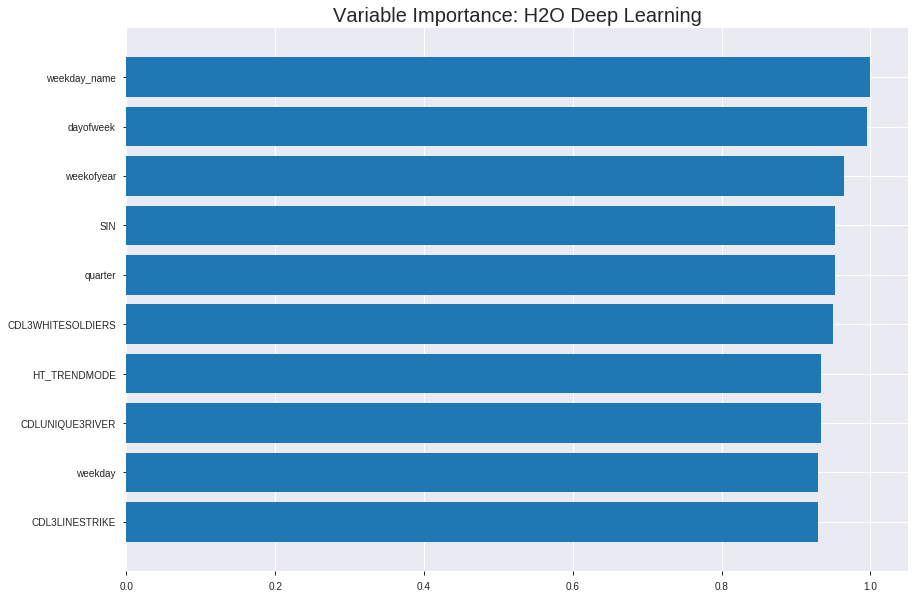

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_131347_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.27155336162950056
RMSE: 0.5211078215009832
LogLoss: 0.7412164634335445
Mean Per-Class Error: 0.4786985343148151
AUC: 0.5013525881568454
pr_auc: 0.5416010232920846
Gini: 0.002705176313690716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15179655607428752: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    815   0.9963   (815.0/818.0)
1      0    935   0        (0.0/935.0)
Total  3    1750  0.4649   (815.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.151797     0.696462   396
max f2                       0.151797     0.851548   396
max f0point5                 0.151797     0.589162   396
max accuracy                 0.222404     0.535653   374
max precision                0.633425     0.605714   54
max recall                   0.151797     1          396
max specificity              0.751303     0.997555   0
max absolute_mcc             0.596144     0.0552627  82
max min_per_class_accuracy   0.517444     0.49511    167
max mean_per_class_accuracy  0.592613     0.521301   86

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 47.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.723222           0.937433  0.937433           0.5              0.736025  0.5                         0.736025            0.00962567      0.00962567                 -6.25668   -6.25668
    2        0.0205362                   0.702315           0.937433  0.937433           0.5              0.714214  0.5                         0.725119            0.00962567      0.0192513                  -6.25668   -6.25668
    3        0.0302339                   0.690534           1.10286   0.990495           0.588235         0.695694  0.528302                    0.715681            0.0106952       0.0299465                  10.2863    -0.950459
    4        0.040502                    0.676624           1.14575   1.02986            0.611111         0.681949  0.549296                    0.707129            0.0117647       0.0417112                  14.5752    2.98561
    5        0.0501997                   0.664902           1.10286   1.04396            0.588235         0.669697  0.556818                    0.699898            0.0106952       0.0524064                  10.2863    4.39596
    6        0.100399                    0.632614           1.2144    1.12918            0.647727         0.645804  0.602273                    0.672851            0.0609626       0.113369                   21.4402    12.9181
    7        0.150029                    0.602967           0.991309  1.08357            0.528736         0.6178    0.577947                    0.65464             0.0491979       0.162567                   -0.869138  8.35729
    8        0.200228                    0.58813            1.10788   1.08967            0.590909         0.595434  0.581197                    0.639797            0.055615        0.218182                   10.7876    8.96659
    9        0.300057                    0.56473            0.953503  1.04436            0.508571         0.576361  0.557034                    0.618692            0.0951872       0.313369                   -4.64966   4.43647
    10       0.399886                    0.546628           0.953503  1.02168            0.508571         0.555314  0.544936                    0.60287             0.0951872       0.408556                   -4.64966   2.16818
    11       0.500285                    0.517033           0.88417   0.994085           0.471591         0.5337    0.530217                    0.588988            0.0887701       0.497326                   -11.583    -0.591467
    12       0.600114                    0.460932           0.94279   0.985552           0.502857         0.492135  0.525665                    0.572877            0.0941176       0.591444                   -5.72101   -1.44477
    13       0.699943                    0.390369           0.964217  0.982509           0.514286         0.427994  0.524042                    0.552213            0.0962567       0.687701                   -3.5783    -1.74906
    14       0.799772                    0.326193           1.0285    0.98825            0.548571         0.358966  0.527104                    0.528091            0.102674        0.790374                   2.84981    -1.17502
    15       0.899601                    0.275476           1.01778   0.991527           0.542857         0.3012    0.528852                    0.502913            0.101604        0.891979                   1.77846    -0.847273
    16       1                           0.12236            1.07592   1                  0.573864         0.234311  0.533371         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.33447416043986156
RMSE: 0.5783374105484285
LogLoss: 4.968416301501259
Mean Per-Class Error: 0.45861048928685644
AUC: 0.5308202750239847
pr_auc: 0.5375765776331961
Gini: 0.06164055004796931
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.434713265991819e-40: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    236  1        (236.0/236.0)
1      0    265  0        (0.0/265.0)
Total  0    501  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.43471e-40  0.691906  399
max f2                       1.43471e-40  0.848815  399
max f0point5                 1.00898e-35  0.59108   398
max accuracy                 6.50677e-27  0.552894  390
max precision                0.723607     1         0
max recall                   1.43471e-40  1         399
max specificity              0.723607     1         0
max absolute_mcc             1.00898e-35  0.088899  398
max min_per_class_accuracy   0.522892     0.521186  251
max mean_per_class_accuracy  0.0727301    0.54139   333

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 36.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.694233           0.630189  0.630189           0.333333         0.70379      0.333333                    0.70379             0.00754717      0.00754717                 -36.9811  -36.9811
    2        0.0219561                   0.683422           0.756226  0.687479           0.4              0.68629      0.363636                    0.695835            0.00754717      0.0150943                  -24.3774  -31.2521
    3        0.0319361                   0.680676           1.51245   0.945283           0.8              0.681811     0.5                         0.691453            0.0150943       0.0301887                  51.2453   -5.4717
    4        0.0419162                   0.674848           1.13434   0.990296           0.6              0.676254     0.52381                     0.687834            0.0113208       0.0415094                  13.434    -0.97035
    5        0.0518962                   0.667331           1.13434   1.018              0.6              0.670391     0.538462                    0.684479            0.0113208       0.0528302                  13.434    1.79971
    6        0.101796                    0.628567           1.20996   1.1121             0.64             0.649739     0.588235                    0.66745             0.0603774       0.113208                   20.9962   11.2098
    7        0.151697                    0.611845           0.604981  0.945283           0.32             0.619101     0.5                         0.651546            0.0301887       0.143396                   -39.5019  -5.4717
    8        0.201597                    0.585495           1.36121   1.04823            0.72             0.597727     0.554455                    0.638224            0.0679245       0.211321                   36.1208   4.82346
    9        0.301397                    0.553791           0.907472  1.00162            0.48             0.565041     0.529801                    0.613991            0.090566        0.301887                   -9.25283  0.162439
    10       0.401198                    0.54149            1.13434   1.03464            0.6              0.547957     0.547264                    0.597565            0.113208        0.415094                   13.434    3.46381
    11       0.500998                    0.523253           1.05872   1.03943            0.56             0.533953     0.549801                    0.584893            0.10566         0.520755                   5.8717    3.94347
    12       0.600798                    0.483025           1.02091   1.03636            0.54             0.508941     0.548173                    0.572277            0.101887        0.622642                   2.09057   3.63568
    13       0.700599                    0.000820922        1.09653   1.04493            0.58             0.176503     0.552707                    0.515899            0.109434        0.732075                   9.65283   4.49282
    14       0.800399                    4.7783e-39         1.02091   1.04193            0.54             3.37487e-05  0.551122                    0.451576            0.101887        0.833962                   2.09057   4.19329
    15       1                           0                  0.831849  1                  0.44             3.80974e-42  0.528942                    0.361441            0.166038        1                          -16.8151  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:15:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:15:38  1 min 45.522 sec  349 obs/sec       0.204792  1             359        0.700501         8.00098             -0.971588      0.489602        0.435262           1.04159          0.466629                         0.690756           10.2076               -0.91499         0.478574          0.248524             0.958473           0.469062
    2019-08-27 13:15:51  1 min 58.246 sec  385 obs/sec       2.79692   13            4903       0.537643         0.850389            -0.161412      0.536607        0.555369           1.24991          0.462065                         0.643975           6.50728               -0.664394        0.517269          0.5279               0.630189           0.471058
    2019-08-27 13:16:02  2 min  9.412 sec  394 obs/sec       5.1409    24            9012       0.530541         0.784157            -0.130935      0.509029        0.553145           1.14575          0.464347                         0.617011           6.49023               -0.52793         0.510425          0.518125             0.945283           0.471058
    2019-08-27 13:16:13  2 min 20.402 sec  404 obs/sec       7.57216   35            13274      0.521108         0.741216            -0.0910737     0.501353        0.541601           0.937433         0.464917                         0.578337           4.96842               -0.342394        0.53082           0.537577             0.630189           0.471058
    2019-08-27 13:16:23  2 min 30.829 sec  412 obs/sec       9.93497   46            17416      0.583285         0.950938            -0.366977      0.500013        0.530056           0.833274         0.465488                         0.633267           6.07387               -0.609502        0.521762          0.529158             0.315094           0.471058
    2019-08-27 13:16:34  2 min 41.698 sec  422 obs/sec       12.5419   58            21986      0.552186         0.842991            -0.225093      0.512185        0.545538           1.04159          0.462065                         0.606653           4.97443               -0.477058        0.520203          0.530267             0.630189           0.471058
    2019-08-27 13:16:45  2 min 52.413 sec  430 obs/sec       15.1546   70            26566      0.544993         0.836295            -0.193384      0.538086        0.565886           1.24991          0.466058                         0.67795            7.67496               -0.844643        0.519731          0.530639             0.630189           0.471058
    2019-08-27 13:16:56  3 min  3.499 sec  439 obs/sec       18.0108   83            31573      0.509843         0.721002            -0.0444123     0.552725        0.580714           1.35407          0.465488                         0.635853           7.36018               -0.622673        0.519324          0.533564             0.945283           0.471058
    2019-08-27 13:17:07

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
weekday_name              1.0                    1.0                  0.0015064714515742636
dayofweek                 0.9958390593528748     0.9958390593528748   0.0015002031132776744
weekofyear                0.9647378325462341     0.9647378325462341   0.001453350002984534
SIN                       0.952772319316864      0.952772319316864    0.0014353242989010538
quarter                   0.9526285529136658     0.9526285529136658   0.0014351077189189401
---                       ---                    ---                  ---
MAVP_8_2                  0.5467349886894226     0.5467349886894226   0.000823640652037393
BBANDS_upperband_20_7_3   0.5439001321792603     0.5439001321792603   0.000819370021635524
TRIMA_14                  0.5438994765281677     0.5438994765281677   0.0008193690339158709
BBANDS_upperband_12_7_4   0.5382354855537415     0.5382354855537415   0.0008108363932109235
BBANDS_middleband_24_2_4  0.523625373840332      0.523625373840332    0.0007888266770103614


See the whole table with table.as_data_frame()


Could not find exact threshold 0.0; using closest threshold found 0.0.


('accuracy', 0.44621513944223107)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6170798898071626)

('auc', 0.5)

('logloss', 15.4117249252191)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.6679933678130577)

('mse', 0.44621513944223107)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


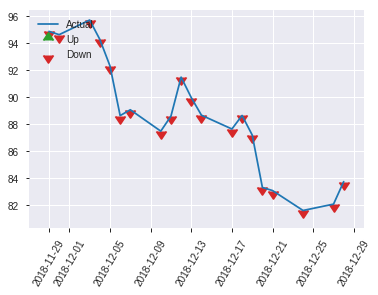


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.44621513944223107
RMSE: 0.6679933678130577
LogLoss: 15.4117249252191
Could not find exact threshold 0.0; using closest threshold found 0.0.
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.61708   0
max f2                       0            0.801144  0
max f0point5                 0            0.501792  0
max accuracy                 0            0.446215  0
max precision                0            0.446215  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 44.62 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.446215         0        0.446215                    0                   1               1                          0       0

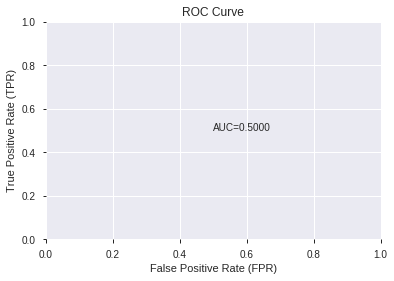

This function is available for GLM models only


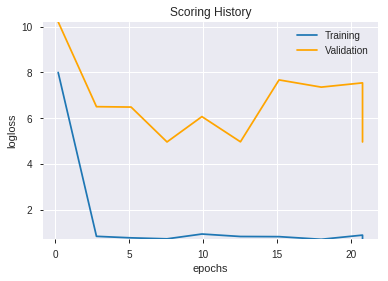

--2019-08-27 13:42:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.19.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.19.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.9MB/s    in 22s     

2019-08-27 13:42:56 (15.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_131347_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_131347_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_134310_model_5  0.556430  0.715248              0.500000  0.510025  0.260126
1  DeepLearning_grid_1_AutoML_20190827_134310_model_9  0.535586  0.693290              0.500000  0.500093  0.250093
2  DeepLearning_grid_1_AutoML_20190827_134310_model_8  0.530897  0.696509              0.475559  0.501677  0.251680
3  DeepLearning_grid_1_AutoML_20190827_134310_model_7  0.517857  0.882920              0.496403  0.564392  0.318539
4  DeepLearning_grid_1_AutoML_20190827_134310_model_6  0.516123  0.734727              0.483749  0.519958  0.270356
5  DeepLearning_grid_1_AutoML_20190827_134310_model_1  0.472058  1.322374              0.496403  0.628328  0.394796
6  DeepLearning_grid_1_AutoML_20190827_134310_model_4  0.449448  1.165840              0.486479  0.623086  0.388236
7  DeepLearning_grid_1_AutoML_20190827_134310_model_3  0.445658  0.980599              0.500000  0.588635  0.346491
8               DeepLearning_1_AutoML_20190827_134310  0.443923  0.856881              0.496403  0.564210  0.318333
9  DeepLearning_grid_1_AutoML_20190827_134310_model_2  0.433196  1.130399              0.500000  0.612481  0.375134

variable  relative_importance  scaled_importance  percentage
0           weekday_name             1.000000           1.000000    0.028189
1                    day             0.993280           0.993280    0.028000
2                    COS             0.915211           0.915211    0.025799
3             aroonup_20             0.903122           0.903122    0.025459
4                  DX_14             0.889786           0.889786    0.025083
5                    SIN             0.869777           0.869777    0.024519
6           aroondown_12             0.859993           0.859993    0.024243
7         STOCHRSI_fastd             0.859883           0.859883    0.024240
8                 SAREXT             0.853274           0.853274    0.024053
9         STOCHRSI_fastk             0.825546           0.825546    0.023272
10          aroondown_20             0.805202           0.805202    0.022698
11          STOCHF_fastk             0.804955           0.804955    0.022691
12               weekday             0.801923           0.801923    0.022606
13  HT_PHASOR_quadrature             0.780693           0.780693    0.022007
14             dayofweek             0.776296           0.776296    0.021883
15         days_in_month             0.770970           0.770970    0.021733
16        CDLSPINNINGTOP             0.758242           0.758242    0.021374
17          aroondown_14             0.745942           0.745942    0.021028
18            aroonup_12             0.744619           0.744619    0.020990
19           aroondown_8             0.743382           0.743382    0.020956
20           HT_DCPERIOD             0.739925           0.739925    0.020858
21                BETA_8             0.734997           0.734997    0.020719
22               BETA_12             0.711597           0.711597    0.020060
23               quarter             0.707791           0.707791    0.019952
24             CORREL_12             0.707702           0.707702    0.019950
25          HT_TRENDMODE             0.694889           0.694889    0.019589
26                 month             0.681922           0.681922    0.019223
27             dayofyear             0.676922           0.676922    0.019082
28           AROONOSC_14             0.673680           0.673680    0.018991
29               BETA_14             0.671872           0.671872    0.018940
30                   DIV             0.669871           0.669871    0.018883
31     CDLLONGLEGGEDDOJI             0.666750           0.666750    0.018795
32            weekofyear             0.665733           0.665733    0.018767
33                  TANH             0.652541           0.652541    0.018395
34           CDLHIGHWAVE             0.652406           0.652406    0.018391
35    CDLCLOSINGMARUBOZU             0.644451           0.644451    0.018167
36                  week             0.638997           0.638997    0.018013
37               CDLDOJI             0.636709           0.636709    0.017948
38             CORREL_24             0.627889           0.627889    0.017700
39        CDLRICKSHAWMAN             0.595496           0.595496    0.016787
40      CDLSTICKSANDWICH             0.573319           0.573319    0.016162
41           CDLPIERCING             0.557496           0.557496    0.015716
42   CDLRISEFALL3METHODS             0.545481           0.545481    0.015377
43             CDLINNECK             0.545293           0.545293    0.015372
44     CDL3WHITESOLDIERS             0.540490           0.540490    0.015236
45        CDL3LINESTRIKE             0.525334           0.525334    0.014809
46       CDLADVANCEBLOCK             0.517288           0.517288    0.014582
47    CDLUPSIDEGAP2CROWS             0.511447           0.511447    0.014417
48       CDLUNIQUE3RIVER             0.510683           0.510683    0.014396
49             CDL2CROWS             0.493181           0.493181    0.013903

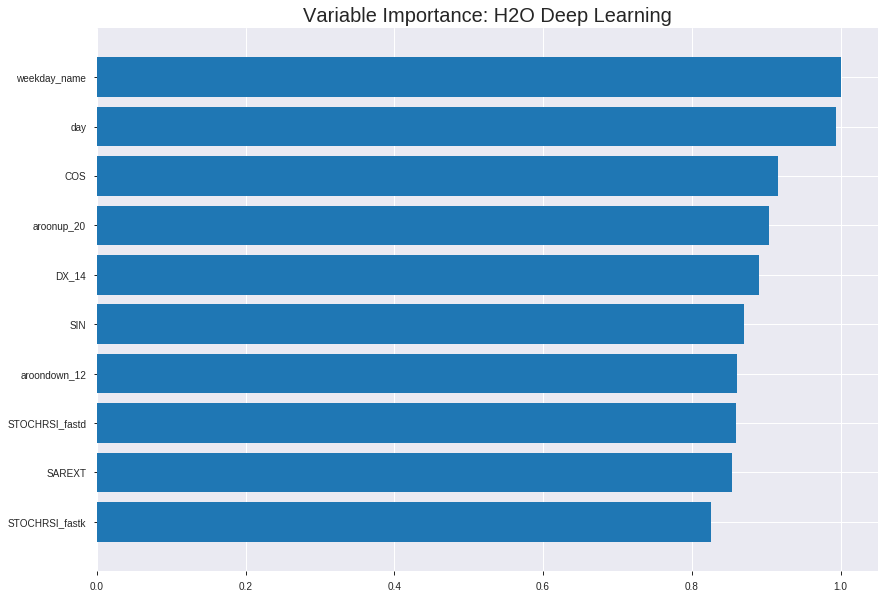

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_134310_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22978977931198424
RMSE: 0.47936393200989186
LogLoss: 0.6502360720210495
Mean Per-Class Error: 0.3751964488840658
AUC: 0.665421073964149
pr_auc: 0.6910393616629003
Gini: 0.3308421479282979
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44887893482484936: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      170  648   0.7922   (648.0/818.0)
1      64   871   0.0684   (64.0/935.0)
Total  234  1519  0.4062   (712.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448879     0.709861  292
max f2                       0.291507     0.854756  366
max f0point5                 0.560076     0.647587  179
max accuracy                 0.549373     0.625214  197
max precision                0.963092     1         0
max recall                   0.202644     1         395
max specificity              0.963092     1         0
max absolute_mcc             0.57752      0.258466  158
max min_per_class_accuracy   0.556076     0.613692  185
max mean_per_class_accuracy  0.560076     0.624804  179

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 54.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.80881            1.87487   1.87487            1                0.859838  1                           0.859838            0.0192513       0.0192513                  87.4866    87.4866
    2        0.0205362                   0.775176           1.77071   1.82279            0.944444         0.787432  0.972222                    0.823635            0.0181818       0.0374332                  77.0707    82.2787
    3        0.0302339                   0.739419           1.76458   1.80412            0.941176         0.755748  0.962264                    0.80186             0.0171123       0.0545455                  76.458     80.4117
    4        0.040502                    0.721242           1.45823   1.71643            0.777778         0.729278  0.915493                    0.783459            0.0149733       0.0695187                  45.8229    71.6427
    5        0.0501997                   0.700461           1.54401   1.68312            0.823529         0.709174  0.897727                    0.769108            0.0149733       0.084492                   54.4008    68.3119
    6        0.100399                    0.664576           1.1931    1.43811            0.636364         0.680929  0.767045                    0.725019            0.059893        0.144385                   19.3097    43.8108
    7        0.150029                    0.631146           1.20681   1.36159            0.643678         0.646343  0.726236                    0.698993            0.059893        0.204278                   20.681     36.1595
    8        0.200228                    0.60944            1.23571   1.33003            0.659091         0.620253  0.709402                    0.679252            0.0620321       0.26631                    23.5707    33.0033
    9        0.300057                    0.584913           1.33919   1.33308            0.714286         0.59633   0.711027                    0.651664            0.13369         0.4                        33.919     33.308
    10       0.399886                    0.567565           1.08207   1.27042            0.577143         0.576161  0.677603                    0.632815            0.108021        0.508021                   8.20657    27.0416
    11       0.500285                    0.556751           1.02265   1.22069            0.545455         0.561007  0.651083                    0.618404            0.102674        0.610695                   2.26544    22.0694
    12       0.600114                    0.546843           0.996358  1.18338            0.531429         0.552104  0.631179                    0.607375            0.0994652       0.71016                    -0.364248  18.3376
    13       0.699943                    0.526418           0.728519  1.1185             0.388571         0.537642  0.596577                    0.59743             0.0727273       0.782888                   -27.1481   11.8502
    14       0.799772                    0.486664           0.867795  1.08721            0.462857         0.507522  0.579886                    0.586207            0.086631        0.869519                   -13.2205   8.72085
    15       0.899601                    0.41747            0.792801  1.05454            0.422857         0.458035  0.56246                     0.571984            0.0791444       0.948663                   -20.7199   5.4538
    16       1                           0.124277           0.511327  1                  0.272727         0.33146   0.533371                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25916027036647077
RMSE: 0.5090778627739285
LogLoss: 0.713585260463083
Mean Per-Class Error: 0.4724496322353693
AUC: 0.4853613687240166
pr_auc: 0.5082446577214474
Gini: -0.02927726255196683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34609693749962783: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    227  0.9619   (227.0/236.0)
1      4    261  0.0151   (4.0/265.0)
Total  13   488  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.346097     0.693227   386
max f2                       0.178252     0.848815   399
max f0point5                 0.369029     0.58944    381
max accuracy                 0.520128     0.540918   280
max precision                0.868369     1          0
max recall                   0.178252     1          399
max specificity              0.868369     1          0
max absolute_mcc             0.603834     0.0981235  111
max min_per_class_accuracy   0.558767     0.471698   196
max mean_per_class_accuracy  0.520128     0.52755    280

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 55.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.775547           1.26038   1.26038            0.666667         0.800849  0.666667                    0.800849            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.749304           0.756226  1.03122            0.4              0.75835   0.545455                    0.781531            0.00754717      0.0226415                  -24.3774  3.12178
    3        0.0319361                   0.729224           0.756226  0.945283           0.4              0.736387  0.5                         0.767424            0.00754717      0.0301887                  -24.3774  -5.4717
    4        0.0419162                   0.716999           0.756226  0.90027            0.4              0.721167  0.47619                     0.75641             0.00754717      0.0377358                  -24.3774  -9.97305
    5        0.0518962                   0.704321           0.756226  0.872569           0.4              0.707936  0.461538                    0.747088            0.00754717      0.045283                   -24.3774  -12.7431
    6        0.101796                    0.673395           0.831849  0.852608           0.44             0.687314  0.45098                     0.717787            0.0415094       0.0867925                  -16.8151  -14.7392
    7        0.151697                    0.641208           1.05872   0.920407           0.56             0.654634  0.486842                    0.697013            0.0528302       0.139623                   5.8717    -7.95929
    8        0.201597                    0.618268           0.756226  0.879768           0.4              0.62847   0.465347                    0.680047            0.0377358       0.177358                   -24.3774  -12.0232
    9        0.301397                    0.590341           0.945283  0.901462           0.5              0.603516  0.476821                    0.654706            0.0943396       0.271698                   -5.4717   -9.8538
    10       0.401198                    0.566668           0.983094  0.921769           0.52             0.576371  0.487562                    0.635219            0.0981132       0.369811                   -1.69057  -7.82315
    11       0.500998                    0.558429           1.05872   0.949049           0.56             0.561548  0.501992                    0.620544            0.10566         0.475472                   5.8717    -5.09509
    12       0.600798                    0.548328           1.24777   0.998671           0.66             0.553083  0.528239                    0.609338            0.124528        0.6                        24.7774   -0.13289
    13       0.700599                    0.530318           1.17215   1.02338            0.62             0.539662  0.541311                    0.599412            0.116981        0.716981                   17.2151   2.33833
    14       0.800399                    0.500066           0.945283  1.01365            0.5              0.513976  0.53616                     0.588759            0.0943396       0.811321                   -5.4717   1.36451
    15       0.9002                      0.454589           0.945283  1.00607            0.5              0.476419  0.532151                    0.576305            0.0943396       0.90566                    -5.4717   0.606618
    16       1                           0.178252           0.945283  1                  0.5              0.373602  0.528942                    0.556075


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:46:12  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:46:14  1 min 22.991 sec  1542 obs/sec      1.95265   1             3423       0.497499         0.688081            0.00554795     0.559533        0.586569           1.35407          0.458642                         0.512076           0.718168              -0.0524129       0.43361           0.482359             0.315094           0.471058
    2019-08-27 13:46:21  1 min 29.696 sec  2464 obs/sec      11.745    6             20589      0.479364         0.650236            0.0767281      0.665421        0.691039           1.87487          0.406161                         0.509078           0.713585              -0.0401261       0.485361          0.508245             1.26038            0.461078
    2019-08-27 13:46:26  1 min 35.559 sec  2758 obs/sec      21.5208   11            37726      0.471666         0.628551            0.106142       0.719569        0.749675           1.87487          0.352539                         0.5348             0.809813              -0.147888        0.49956           0.512787             1.26038            0.471058
    2019-08-27 13:46:32  1 min 41.288 sec  2909 obs/sec      31.2921   16            54855      0.43264          0.549381            0.24794        0.7922          0.813247           1.87487          0.324016                         0.536052           0.80998               -0.153273        0.4937            0.512221             0.945283           0.471058
    2019-08-27 13:46:38  1 min 46.921 sec  3006 obs/sec      41.0753   21            72005      0.407603         0.498618            0.332467       0.859598        0.865147           1.87487          0.241871                         0.538108           0.832572              -0.162134        0.51228           0.529403             0.945283           0.471058
    2019-08-27 13:46:43  1 min 52.482 sec  3078 obs/sec      50.8408   26            89124      0.392055         0.463642            0.38242        0.878144        0.881725           1.87487          0.211637                         0.547365           0.894132              -0.202464        0.514023          0.529293             0.630189           0.461078
    2019-08-27 13:46:44  1 min 53.045 sec  3076 obs/sec      50.8408   26            89124      0.479364         0.650236            0.0767281      0.665421        0.691039           1.87487          0.406161                         0.509078           0.713585              -0.0401261       0.485361          0.508245             1.26038            0.461078

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
weekday_name        1.0                    1.0                  0.02818946294180253
day                 0.9932802319526672     0.9932802319526672   0.028000036289454737
COS                 0.9152114391326904     0.9152114391326904   0.02579931894734474
aroonup_20          0.9031221866607666     0.9031221866607666   0.02545852941279335
DX_14               0.8897855281829834     0.8897855281829834   0.0250825761728664
---                 ---                    ---                  ---
CDL3LINESTRIKE      0.525334358215332      0.525334358215332    0.014808893422966719
CDLADVANCEBLOCK     0.5172876715660095     0.5172876715660095   0.014582061647861345
CDLUPSIDEGAP2CROWS  0.5114468932151794     0.5114468932151794   0.014417413242989337
CDLUNIQUE3RIVER     0.5106832385063171     0.5106832385063171   0.01439588622687353
CDL2CROWS           0.4931807816028595     0.4931807816028595   0.013902501366603015


See the whole table with table.as_data_frame()


('accuracy', 0.5737051792828686)

('F1', 0.6170798898071626)

('auc', 0.5564298561151079)

('logloss', 0.715247906751095)

('mean_per_class_error', 0.43778905447070915)

('rmse', 0.5100254896350149)

('mse', 0.2601260000774367)

deeplearning prediction progress: |███████████████████████████████████████| 100%


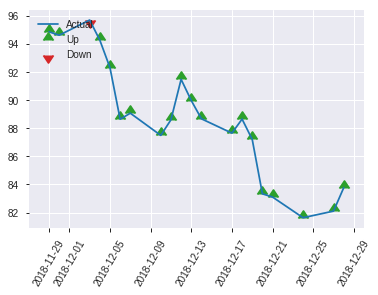


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2601260000774367
RMSE: 0.5100254896350149
LogLoss: 0.715247906751095
Mean Per-Class Error: 0.43778905447070915
AUC: 0.5564298561151079
pr_auc: 0.48813385558378813
Gini: 0.11285971223021574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20654775378101783: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.206548     0.61708   249
max f2                       0.206548     0.801144  249
max f0point5                 0.555943     0.518293  134
max accuracy                 0.630806     0.573705  40
max precision                0.769609     0.666667  2
max recall                   0.206548     1         249
max specificity              0.803896     0.992806  0
max absolute_mcc             0.577819     0.127019  96
max min_per_class_accuracy   0.560267     0.539568  124
max mean_per_class_accuracy  0.577819     0.562211  96

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 55.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.763286           1.49405   1.49405            0.666667         0.783829  0.666667                    0.783829            0.0178571       0.0178571                  49.4048   49.4048
    2        0.0239044                   0.725508           0.747024  1.12054            0.333333         0.736003  0.5                         0.759916            0.00892857      0.0267857                  -25.2976  12.0536
    3        0.0318725                   0.70312            0         0.840402           0                0.709077  0.375                       0.747206            0               0.0267857                  -100      -15.9598
    4        0.0438247                   0.6952             1.49405   1.01867            0.666667         0.69668   0.454545                    0.733426            0.0178571       0.0446429                  49.4048   1.86688
    5        0.0517928                   0.692679           2.24107   1.20673            1                0.69341   0.538462                    0.72727             0.0178571       0.0625                     124.107   20.6731
    6        0.103586                    0.653336           1.03434   1.12054            0.461538         0.672667  0.5                         0.699968            0.0535714       0.116071                   3.43407   12.0536
    7        0.151394                    0.633151           1.49405   1.23849            0.666667         0.642554  0.552632                    0.681838            0.0714286       0.1875                     49.4048   23.8487
    8        0.203187                    0.613409           0.861951  1.14251            0.384615         0.623145  0.509804                    0.666877            0.0446429       0.232143                   -13.8049  14.2507
    9        0.302789                    0.589447           1.16536   1.15002            0.52             0.60059   0.513158                    0.645072            0.116071        0.348214                   16.5357   15.0023
    10       0.40239                     0.575426           1.16536   1.15382            0.52             0.581843  0.514851                    0.629421            0.116071        0.464286                   16.5357   15.3819
    11       0.501992                    0.559116           0.896429  1.10275            0.4              0.565309  0.492063                    0.6167              0.0892857       0.553571                   -10.3571  10.2749
    12       0.601594                    0.550003           0.896429  1.06859            0.4              0.554766  0.476821                    0.606446            0.0892857       0.642857                   -10.3571  6.85904
    13       0.701195                    0.537892           0.806786  1.0314             0.36             0.544347  0.460227                    0.597625            0.0803571       0.723214                   -19.3214  3.14022
    14       0.800797                    0.491901           1.07571   1.03691            0.48             0.516105  0.462687                    0.587486            0.107143        0.830357                   7.57143   3.69136
    15       0.900398                    0.434848           0.806786  1.01146            0.36             0.466547  0.451327                    0.574108            0.0803571       0.910714                   -19.3214  1.1457
    16       1                           0.206548           0.896429  1                  0.4              0.351766  0.446215                    0.551962         

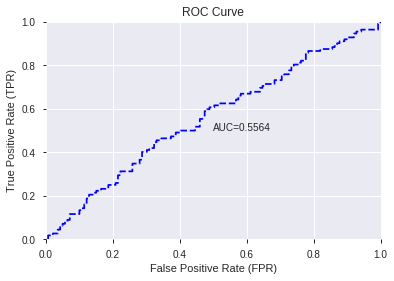

This function is available for GLM models only


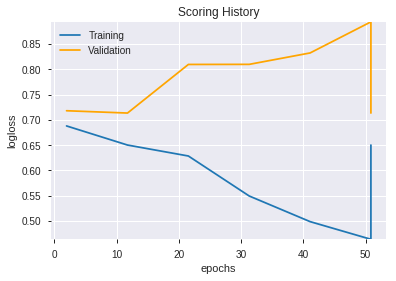

--2019-08-27 13:50:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_134310_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_134310_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'day',
 'COS',
 'aroonup_20',
 'DX_14',
 'SIN',
 'aroondown_12',
 'STOCHRSI_fastd',
 'SAREXT',
 'STOCHRSI_fastk',
 'aroondown_20',
 'STOCHF_fastk',
 'weekday',
 'HT_PHASOR_quadrature',
 'dayofweek',
 'days_in_month',
 'CDLSPINNINGTOP',
 'aroondown_14',
 'aroonup_12',
 'aroondown_8',
 'HT_DCPERIOD',
 'BETA_8',
 'BETA_12',
 'quarter',
 'CORREL_12',
 'HT_TRENDMODE',
 'month',
 'dayofyear',
 'AROONOSC_14',
 'BETA_14',
 'DIV',
 'CDLLONGLEGGEDDOJI',
 'weekofyear',
 'TANH',
 'CDLHIGHWAVE',
 'CDLCLOSINGMARUBOZU',
 'week',
 'CDLDOJI',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLRISEFALL3METHODS',
 'CDLINNECK',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLADVANCEBLOCK',
 'CDLUPSIDEGAP2CROWS',
 'CDLUNIQUE3RIVER',
 'CDL2CROWS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_135058_model_1  0.51047  0.700904              0.496403  0.50386  0.253874

variable  relative_importance  scaled_importance  percentage
0             aroonup_20             0.013249           1.000000    0.050134
1          days_in_month             0.012695           0.958171    0.048037
2         CDLSPINNINGTOP             0.012360           0.932909    0.046771
3         STOCHRSI_fastd             0.012051           0.909545    0.045599
4      CDL3WHITESOLDIERS             0.011486           0.866893    0.043461
5       CDLSTICKSANDWICH             0.011219           0.846763    0.042452
6              CORREL_24             0.010541           0.795614    0.039888
7         CDLRICKSHAWMAN             0.010080           0.760777    0.038141
8           weekday_name             0.010039           0.757726    0.037988
9              CDLINNECK             0.009368           0.707033    0.035447
10                   SIN             0.007911           0.597090    0.029935
11                   day             0.007650           0.577382    0.028947
12             CDL2CROWS             0.007587           0.572605    0.028707
13          aroondown_12             0.006977           0.526559    0.026399
14        CDL3LINESTRIKE             0.006727           0.507720    0.025454
15       CDLUNIQUE3RIVER             0.006350           0.479257    0.024027
16                  TANH             0.006147           0.463956    0.023260
17                   DIV             0.005958           0.449687    0.022545
18                BETA_8             0.005689           0.429414    0.021528
19           HT_DCPERIOD             0.005463           0.412316    0.020671
20             dayofweek             0.005114           0.385950    0.019349
21               weekday             0.005103           0.385116    0.019308
22     CDLLONGLEGGEDDOJI             0.005069           0.382557    0.019179
23               BETA_12             0.004879           0.368241    0.018461
24                SAREXT             0.004703           0.354963    0.017796
25    CDLUPSIDEGAP2CROWS             0.004654           0.351239    0.017609
26               CDLDOJI             0.004383           0.330771    0.016583
27          aroondown_20             0.004243           0.320235    0.016055
28           aroondown_8             0.004212           0.317926    0.015939
29          STOCHF_fastk             0.003892           0.293751    0.014727
30          HT_TRENDMODE             0.003710           0.280025    0.014039
31           AROONOSC_14             0.003479           0.262547    0.013163
32          aroondown_14             0.003162           0.238630    0.011964
33  HT_PHASOR_quadrature             0.003005           0.226834    0.011372
34            weekofyear             0.002883           0.217624    0.010910
35                  week             0.002862           0.216039    0.010831
36                   COS             0.002618           0.197579    0.009905
37       CDLADVANCEBLOCK             0.002194           0.165574    0.008301
38           CDLPIERCING             0.002110           0.159267    0.007985
39                 month             0.001849           0.139534    0.006995
40               BETA_14             0.001670           0.126060    0.006320
41                 DX_14             0.001546           0.116681    0.005850
42    CDLCLOSINGMARUBOZU             0.001457           0.109956    0.005513
43             CORREL_12             0.001318           0.099445    0.004986
44        STOCHRSI_fastk             0.001277           0.096380    0.004832
45             dayofyear             0.001163           0.087756    0.004400
46           CDLHIGHWAVE             0.000889           0.067104    0.003364
47               quarter             0.000594           0.044800    0.002246
48   CDLRISEFALL3METHODS             0.000507           0.038289    0.001920
49            aroonup_12             0.000187           0.014151    0.000709

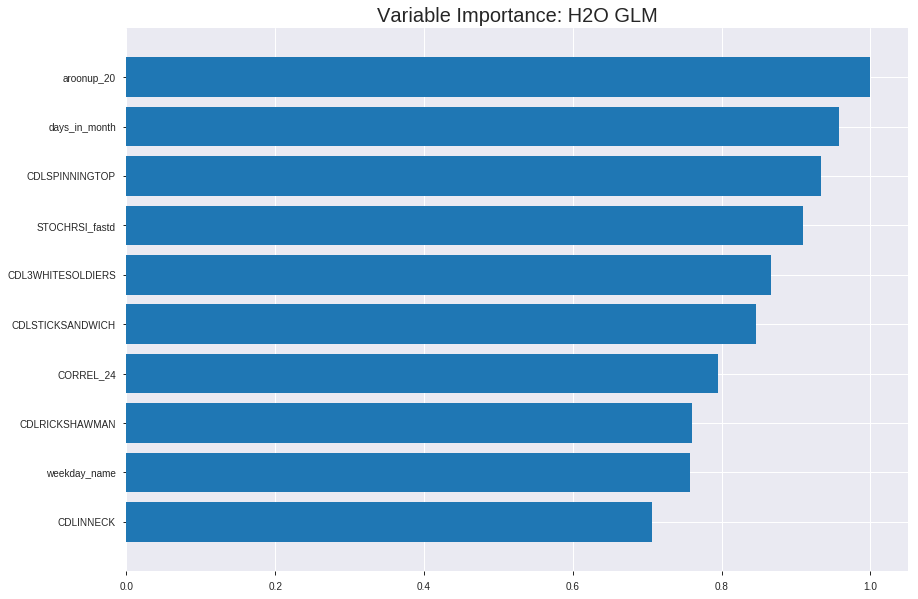

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135058_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2472338897523654
RMSE: 0.49722619576241694
LogLoss: 0.6875882976785291
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2422.359308081908
Residual deviance: 2410.684571660923
AIC: 2512.684571660923
AUC: 0.5720094661558778
pr_auc: 0.6010692628570521
Gini: 0.14401893231175555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5160716772894809: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      75   743   0.9083   (743.0/818.0)
1      29   906   0.031    (29.0/935.0)
Total  104  1649  0.4404   (772.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516072     0.701238  351
max f2                       0.49282      0.851238  398
max f0point5                 0.516373     0.60208   349
max accuracy                 0.523202     0.561894  302
max precision                0.611303     1         0
max recall                   0.49282      1         398
max specificity              0.611303     1         0
max absolute_mcc             0.516373     0.12969   349
max min_per_class_accuracy   0.532301     0.545232  219
max mean_per_class_accuracy  0.531114     0.556189  230

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.57069            1.45823   1.45823            0.777778         0.588604  0.777778                    0.588604            0.0149733       0.0149733                  45.8229   45.8229
    2        0.0205362                   0.563521           1.14575   1.30199            0.611111         0.566939  0.694444                    0.577772            0.0117647       0.026738                   14.5752   30.199
    3        0.0302339                   0.558884           1.32344   1.30887            0.705882         0.560939  0.698113                    0.572373            0.0128342       0.0395722                  32.3435   30.8869
    4        0.040502                    0.556864           1.04159   1.24111            0.555556         0.557866  0.661972                    0.568695            0.0106952       0.0502674                  4.15924   24.1109
    5        0.0501997                   0.554655           1.32344   1.25701            0.705882         0.555657  0.670455                    0.566176            0.0128342       0.0631016                  32.3435   25.7013
    6        0.100399                    0.548413           1.25701   1.25701            0.670455         0.551211  0.670455                    0.558694            0.0631016       0.126203                   25.7013   25.7013
    7        0.150029                    0.544355           1.20681   1.24041            0.643678         0.546296  0.661597                    0.554592            0.059893        0.186096                   20.681    24.0406
    8        0.200228                    0.541712           0.980044  1.17513            0.522727         0.542947  0.626781                    0.551673            0.0491979       0.235294                   -1.99562  17.513
    9        0.300057                    0.538265           1.00707   1.11922            0.537143         0.539895  0.596958                    0.547754            0.100535        0.335829                   0.707105  11.9217
    10       0.399886                    0.535129           0.97493   1.0832             0.52             0.536616  0.577746                    0.544974            0.0973262       0.433155                   -2.50695  8.31967
    11       0.500285                    0.532336           1.09722   1.08601            0.585227         0.53374   0.579247                    0.542719            0.11016         0.543316                   9.72229   8.60115
    12       0.600114                    0.52976            1.00707   1.07288            0.537143         0.530998  0.572243                    0.54077             0.100535        0.64385                    0.707105  7.28798
    13       0.699943                    0.52723            0.932076  1.0528             0.497143         0.528532  0.561532                    0.539024            0.0930481       0.736898                   -6.79236  5.27978
    14       0.799772                    0.523728           0.985644  1.04442            0.525714         0.525562  0.557061                    0.537344            0.0983957       0.835294                   -1.4356   4.44155
    15       0.899601                    0.51893            0.953503  1.03433            0.508571         0.521455  0.55168                     0.535581            0.0951872       0.930481                   -4.64966  3.4327
    16       1                           0.46325            0.692422  1                  0.369318         0.513576  0.533371                    0.533371            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2487660572925906
RMSE: 0.4987645309087151
LogLoss: 0.690667688253621
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 692.8933692915758
Residual deviance: 692.0490236301282
AIC: 794.0490236301282
AUC: 0.5277982091461465
pr_auc: 0.566575949890824
Gini: 0.055596418292293004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4985688951758972: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    236  1        (236.0/236.0)
1      0    265  0        (0.0/265.0)
Total  0    501  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498569     0.691906  399
max f2                       0.498569     0.848815  399
max f0point5                 0.505613     0.584704  394
max accuracy                 0.530152     0.546906  222
max precision                0.592977     1         0
max recall                   0.498569     1         399
max specificity              0.592977     1         0
max absolute_mcc             0.564172     0.103898  5
max min_per_class_accuracy   0.532194     0.529661  198
max mean_per_class_accuracy  0.534599     0.549408  170

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.564172           1.89057   1.89057            1                0.573208  1                           0.573208            0.0226415       0.0226415                  89.0566   89.0566
    2        0.0219561                   0.562877           0.756226  1.37496            0.4              0.563366  0.727273                    0.568735            0.00754717      0.0301887                  -24.3774  37.4957
    3        0.0319361                   0.555997           0.756226  1.1816             0.4              0.558818  0.625                       0.565636            0.00754717      0.0377358                  -24.3774  18.1604
    4        0.0419162                   0.553349           1.13434   1.17035            0.6              0.554409  0.619048                    0.562963            0.0113208       0.0490566                  13.434    17.035
    5        0.0518962                   0.551296           1.13434   1.16343            0.6              0.55248   0.615385                    0.560947            0.0113208       0.0603774                  13.434    16.3425
    6        0.101796                    0.546549           1.05872   1.1121             0.56             0.548203  0.588235                    0.5547              0.0528302       0.113208                   5.8717    11.2098
    7        0.151697                    0.543365           1.20996   1.14429            0.64             0.544748  0.605263                    0.551426            0.0603774       0.173585                   20.9962   14.429
    8        0.201597                    0.541024           0.907472  1.08567            0.48             0.542083  0.574257                    0.549114            0.045283        0.218868                   -9.25283  8.56716
    9        0.301397                    0.537516           1.13434   1.10179            0.6              0.53958   0.582781                    0.545957            0.113208        0.332075                   13.434    10.1787
    10       0.401198                    0.535357           1.05872   1.09107            0.56             0.536563  0.577114                    0.54362             0.10566         0.437736                   5.8717    9.10729
    11       0.500998                    0.532213           0.907472  1.0545             0.48             0.533714  0.557769                    0.541647            0.090566        0.528302                   -9.25283  5.4499
    12       0.600798                    0.529344           0.983094  1.04264            0.52             0.530619  0.551495                    0.539815            0.0981132       0.626415                   -1.69057  4.26377
    13       0.700599                    0.52629            0.718415  0.996452           0.38             0.527866  0.527066                    0.538113            0.0716981       0.698113                   -28.1585  -0.354781
    14       0.800399                    0.523347           0.983094  0.994787           0.52             0.524815  0.526185                    0.536455            0.0981132       0.796226                   -1.69057  -0.521338
    15       0.9002                      0.518873           0.945283  0.989298           0.5              0.521085  0.523282                    0.534751            0.0943396       0.890566                   -5.4717   -1.07016
    16       1                           0.498569           1.09653   1                  0.58             0.51325   0.528942                    0.532605       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:50:59  0.000 sec   2            2.4       51            1.37726           1.38149
    2019-08-27 13:50:59  0.039 sec   4            1.5       51            1.37518           1.38134
    2019-08-27 13:50:59  0.069 sec   6            0.91      51            1.37247           1.3816
    2019-08-27 13:50:59  0.095 sec   8            0.56      51            1.36917           1.38261
    2019-08-27 13:50:59  0.117 sec   10           0.35      51            1.36541           1.3847
    2019-08-27 13:50:59  0.142 sec   12           0.22      51            1.36143           1.38813
    2019-08-27 13:50:59  0.166 sec   14           0.13      51            1.35751           1.393

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6187845303867404)

('auc', 0.5104701952723535)

('logloss', 0.7009043626935704)

('mean_per_class_error', 0.4450796505652621)

('rmse', 0.5038595082936238)

('mse', 0.2538744040978923)

glm prediction progress: |████████████████████████████████████████████████| 100%


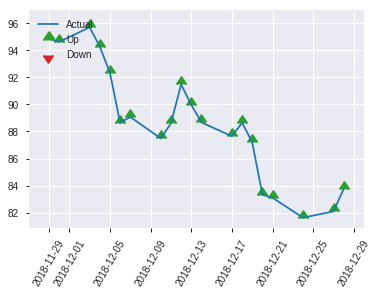


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2538744040978923
RMSE: 0.5038595082936238
LogLoss: 0.7009043626935704
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 352.68995809423006
Residual deviance: 351.85399007217234
AIC: 453.85399007217234
AUC: 0.5104701952723535
pr_auc: 0.4769989550658814
Gini: 0.020940390544706977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5048190407462021: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    138  0.9928   (138.0/139.0)
1      0    112  0        (0.0/112.0)
Total  1    250  0.5498   (138.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504819     0.618785  249
max f2                       0.504819     0.802292  249
max f0point5                 0.504819     0.503597  249
max accuracy                 0.540769     0.589641  40
max precision                0.573988     1         0
max recall                   0.504819     1         249
max specificity              0.573988     1         0
max absolute_mcc             0.540769     0.145367  40
max min_per_class_accuracy   0.53139      0.5       124
max mean_per_class_accuracy  0.539999     0.55492   42

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 53.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.565983           1.49405   1.49405            0.666667         0.570053  0.666667                    0.570053            0.0178571       0.0178571                  49.4048   49.4048
    2        0.0239044                   0.559456           1.49405   1.49405            0.666667         0.562786  0.666667                    0.56642             0.0178571       0.0357143                  49.4048   49.4048
    3        0.0318725                   0.555656           2.24107   1.6808             1                0.557569  0.75                        0.564207            0.0178571       0.0535714                  124.107   68.0804
    4        0.0438247                   0.553146           0.747024  1.42614            0.333333         0.553914  0.636364                    0.5614              0.00892857      0.0625                     -25.2976  42.6136
    5        0.0517928                   0.552383           0         1.20673            0                0.552867  0.538462                    0.560087            0               0.0625                     -100      20.6731
    6        0.103586                    0.544496           1.20673   1.20673            0.538462         0.54719   0.538462                    0.553639            0.0625          0.125                      20.6731   20.6731
    7        0.151394                    0.541265           1.49405   1.29746            0.666667         0.543174  0.578947                    0.550334            0.0714286       0.196429                   49.4048   29.7462
    8        0.203187                    0.539256           1.03434   1.23039            0.461538         0.539995  0.54902                     0.547699            0.0535714       0.25                       3.43407   23.0392
    9        0.302789                    0.536583           0.6275    1.03207            0.28             0.537728  0.460526                    0.544419            0.0625          0.3125                     -37.25    3.20724
    10       0.40239                     0.534259           0.896429  0.998497           0.4              0.535451  0.445545                    0.542199            0.0892857       0.401786                   -10.3571  -0.150283
    11       0.501992                    0.53102            0.986071  0.996032           0.44             0.532605  0.444444                    0.540295            0.0982143       0.5                        -1.39286  -0.396825
    12       0.601594                    0.527528           0.896429  0.979541           0.4              0.529135  0.437086                    0.538448            0.0892857       0.589286                   -10.3571  -2.04588
    13       0.701195                    0.524989           1.16536   1.00594            0.52             0.526364  0.448864                    0.536731            0.116071        0.705357                   16.5357   0.593547
    14       0.800797                    0.522189           0.986071  1.00346            0.44             0.523449  0.447761                    0.535079            0.0982143       0.803571                   -1.39286  0.346482
    15       0.900398                    0.516618           0.806786  0.981708           0.36             0.519101  0.438053                    0.533312            0.0803571       0.883929                   -19.3214  -1.82917
    16       1                           0.444381           1.16536   1                  0.52             0.508762  0.446215                    0.530867 

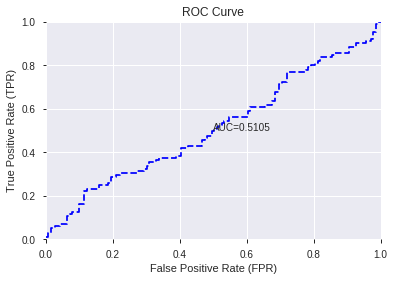

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


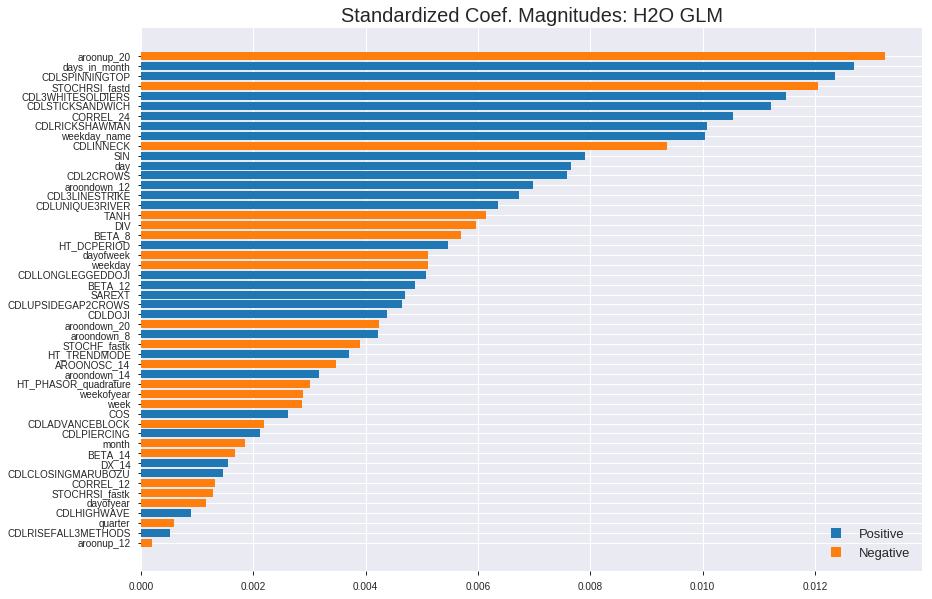

'log_likelihood'
--2019-08-27 13:51:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135058_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135058_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroonup_20',
 'days_in_month',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastd',
 'CDL3WHITESOLDIERS',
 'CDLSTICKSANDWICH',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'CDLINNECK',
 'SIN',
 'day',
 'CDL2CROWS',
 'aroondown_12',
 'CDL3LINESTRIKE',
 'CDLUNIQUE3RIVER',
 'TANH',
 'DIV',
 'BETA_8',
 'HT_DCPERIOD',
 'dayofweek',
 'weekday',
 'CDLLONGLEGGEDDOJI',
 'BETA_12',
 'SAREXT',
 'CDLUPSIDEGAP2CROWS',
 'CDLDOJI',
 'aroondown_20',
 'aroondown_8',
 'STOCHF_fastk',
 'HT_TRENDMODE',
 'AROONOSC_14',
 'aroondown_14',
 'HT_PHASOR_quadrature',
 'weekofyear',
 'week',
 'COS',
 'CDLADVANCEBLOCK',
 'CDLPIERCING',
 'month',
 'BETA_14',
 'DX_14',
 'CDLCLOSINGMARUBOZU',
 'CORREL_12',
 'STOCHRSI_fastk',
 'dayofyear',
 'CDLHIGHWAVE',
 'quarter',
 'CDLRISEFALL3METHODS',
 'aroonup_12']

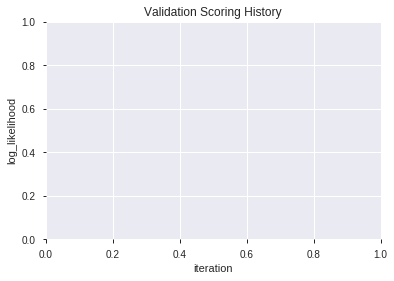

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_135113_model_1  0.518435  0.698942              0.472957  0.502698  0.252705
1  XGBoost_grid_1_AutoML_20190827_135113_model_2  0.512975  0.699306              0.496403  0.503049  0.253059
2  XGBoost_grid_1_AutoML_20190827_135113_model_5  0.499101  0.727373              0.475687  0.515602  0.265845
3               XGBoost_1_AutoML_20190827_135113  0.498073  0.710701              0.481886  0.508174  0.258241
4               XGBoost_3_AutoML_20190827_135113  0.489979  0.705426              0.483749  0.505778  0.255811
5  XGBoost_grid_1_AutoML_20190827_135113_model_6  0.484006  0.704089              0.482014  0.505408  0.255437
6               XGBoost_2_AutoML_20190827_135113  0.480858  0.707410              0.455839  0.506942  0.256990
7  XGBoost_grid_1_AutoML_20190827_135113_model_7  0.479638  0.720586              0.492806  0.512767  0.262930
8  XGBoost_grid_1_AutoML_20190827_135113_model_3  0.478225  0.710569              0.500000  0.508144  0.258211
9  XGBoost_grid_1_AutoML_20190827_135113_model_4  0.457541  0.706944              0.472090  0.506816  0.256862

variable  relative_importance  scaled_importance  percentage
0                    SIN           355.875793           1.000000    0.076124
1         STOCHRSI_fastd           279.082062           0.784212    0.059697
2                 BETA_8           276.160553           0.776003    0.059072
3            HT_DCPERIOD           265.627319           0.746405    0.056819
4                    DIV           256.076477           0.719567    0.054776
5                    COS           242.555115           0.681572    0.051884
6              dayofyear           230.685303           0.648219    0.049345
7   HT_PHASOR_quadrature           229.443848           0.644730    0.049079
8                 SAREXT           227.530304           0.639353    0.048670
9           STOCHF_fastk           224.764893           0.631582    0.048078
10                   day           223.840210           0.628984    0.047881
11                 DX_14           204.835281           0.575581    0.043815
12               BETA_12           172.688385           0.485249    0.036939
13             CORREL_24           172.596741           0.484992    0.036919
14               BETA_14           172.542892           0.484840    0.036908
15        STOCHRSI_fastk           128.440918           0.360915    0.027474
16             CORREL_12           128.028625           0.359756    0.027386
17            aroonup_20           117.267609           0.329518    0.025084
18             dayofweek           107.711121           0.302665    0.023040
19                  TANH            88.189545           0.247810    0.018864
20          aroondown_20            84.340965           0.236996    0.018041
21          weekday_name            79.152992           0.222417    0.016931
22           aroondown_8            62.664803           0.176086    0.013404
23         days_in_month            54.965900           0.154452    0.011758
24          aroondown_14            53.632637           0.150706    0.011472
25        CDLRICKSHAWMAN            51.581436           0.144942    0.011034
26                  week            39.059223           0.109755    0.008355
27           AROONOSC_14            37.606430           0.105673    0.008044
28          aroondown_12            34.351982           0.096528    0.007348
29            aroonup_12            26.991524           0.075845    0.005774
30               weekday            25.735670           0.072316    0.005505
31     CDLLONGLEGGEDDOJI             6.679871           0.018770    0.001429
32          HT_TRENDMODE             5.356476           0.015052    0.001146
33           CDLHIGHWAVE             3.840958           0.010793    0.000822
34        CDLSPINNINGTOP             2.175087           0.006112    0.000465
35            weekofyear             1.937359           0.005444    0.000414
36               quarter             0.947219           0.002662    0.000203

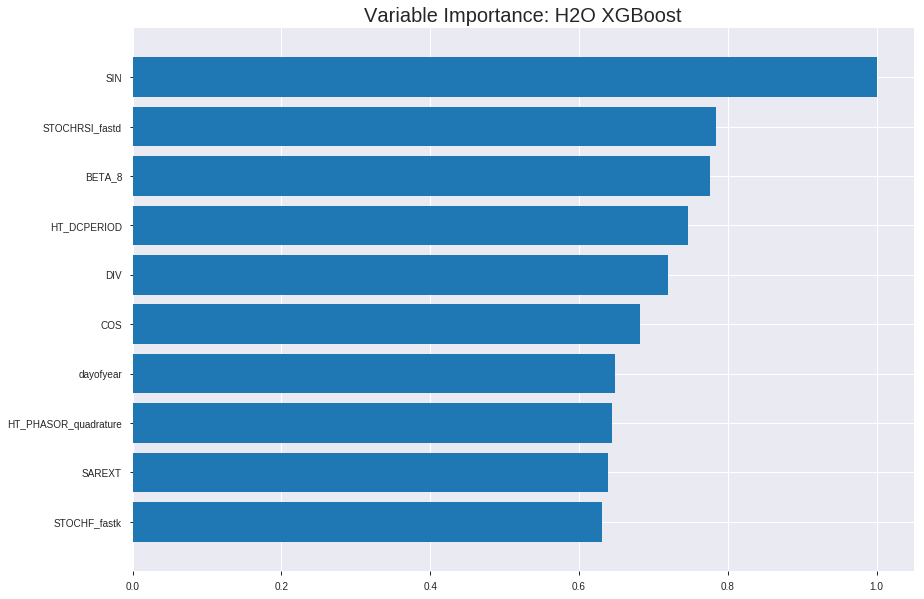

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_135113_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18580589934077324
RMSE: 0.43105208425522457
LogLoss: 0.5611298786052831
Mean Per-Class Error: 0.1522671704823294
AUC: 0.9286161630689173
pr_auc: 0.9365071245564572
Gini: 0.8572323261378345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4979629474026816: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      604  214   0.2616   (214.0/818.0)
1      64   871   0.0684   (64.0/935.0)
Total  668  1085  0.1586   (278.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497963     0.862376  235
max f2                       0.477137     0.91498   257
max f0point5                 0.558761     0.873121  171
max accuracy                 0.519881     0.849401  214
max precision                0.824331     1         0
max recall                   0.387962     1         343
max specificity              0.824331     1         0
max absolute_mcc             0.51869      0.697166  215
max min_per_class_accuracy   0.528925     0.840642  205
max mean_per_class_accuracy  0.519881     0.847733  214

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.748814           1.87487    1.87487            1                0.761741  1                           0.761741            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.729998           1.87487    1.87487            1                0.739066  1                           0.750404            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.714833           1.87487    1.87487            1                0.721134  1                           0.741015            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.705716           1.87487    1.87487            1                0.709713  1                           0.733079            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.6986             1.87487    1.87487            1                0.701806  1                           0.727038            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.663334           1.87487    1.87487            1                0.679211  1                           0.703125            0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.642557           1.83177    1.86061            0.977011         0.652645  0.992395                    0.686426            0.0909091       0.279144                   83.1766   86.0609
    8        0.200228                    0.62447            1.81095    1.84816            0.965909         0.633313  0.985755                    0.67311             0.0909091       0.370053                   81.095    84.8159
    9        0.300057                    0.589106           1.72488    1.80714            0.92             0.607567  0.963878                    0.651304            0.172193        0.542246                   72.4877   80.7143
    10       0.399886                    0.559827           1.53203    1.73846            0.817143         0.574313  0.927247                    0.632084            0.152941        0.695187                   53.2034   73.8464
    11       0.500285                    0.53477            1.24636    1.63971            0.664773         0.547105  0.874572                    0.61503             0.125134        0.820321                   24.636    63.9706
    12       0.600114                    0.502708           0.921363   1.52021            0.491429         0.518894  0.810837                    0.599038            0.0919786       0.912299                   -7.86371  52.021
    13       0.699943                    0.47234            0.567817   1.38438            0.302857         0.487617  0.738386                    0.583146            0.0566845       0.968984                   -43.2183  38.4376
    14       0.799772                    0.437739           0.224984   1.23966            0.12             0.456704  0.661198                    0.567363            0.0224599       0.991444                   -77.5016  23.9658
    15       0.899601                    0.389333           0.0642811  1.10923            0.0342857        0.414373  0.59163                     0.550386            0.00641711      0.997861                   -93.5719  10.9227
    16       1                           0.260763           0.0213053  1                  0.0113636        0.354349  0.533371                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25676187816749557
RMSE: 0.5067167632588205
LogLoss: 0.7070672382041622
Mean Per-Class Error: 0.47682283338663256
AUC: 0.4935881036136872
pr_auc: 0.5210904615997811
Gini: -0.012823792772625575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3367455005645752: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    232  0.9831   (232.0/236.0)
1      2    263  0.0075   (2.0/265.0)
Total  6    495  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.336746     0.692105   394
max f2                       0.292906     0.848815   399
max f0point5                 0.419237     0.586278   330
max accuracy                 0.419237     0.542914   330
max precision                0.677412     0.666667   5
max recall                   0.292906     1          399
max specificity              0.719506     0.995763   0
max absolute_mcc             0.537554     0.0779626  126
max min_per_class_accuracy   0.49791      0.498113   199
max mean_per_class_accuracy  0.419237     0.523177   330

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.677412           1.26038   1.26038            0.666667         0.694648  0.666667                    0.694648            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.66122            0.756226  1.03122            0.4              0.667711  0.545455                    0.682404            0.00754717      0.0226415                  -24.3774  3.12178
    3        0.0319361                   0.644585           1.13434   1.06344            0.6              0.650327  0.5625                      0.67238             0.0113208       0.0339623                  13.434    6.34434
    4        0.0419162                   0.635898           0.378113  0.90027            0.2              0.638874  0.47619                     0.664402            0.00377358      0.0377358                  -62.1887  -9.97305
    5        0.0518962                   0.629417           0.756226  0.872569           0.4              0.632289  0.461538                    0.658227            0.00754717      0.045283                   -24.3774  -12.7431
    6        0.101796                    0.597032           1.28558   1.07503            0.68             0.610751  0.568627                    0.634954            0.0641509       0.109434                   28.5585   7.50277
    7        0.151697                    0.582304           0.907472  1.01991            0.48             0.589205  0.539474                    0.619905            0.045283        0.154717                   -9.25283  1.99106
    8        0.201597                    0.569066           0.680604  0.935924           0.36             0.576097  0.49505                     0.609062            0.0339623       0.188679                   -31.9396  -6.40762
    9        0.301397                    0.540964           0.86966   0.913982           0.46             0.55499   0.483444                    0.591157            0.0867925       0.275472                   -13.034   -8.60177
    10       0.401198                    0.520273           1.05872   0.949986           0.56             0.5292    0.502488                    0.575745            0.10566         0.381132                   5.8717    -5.00141
    11       0.500998                    0.496996           1.17215   0.994242           0.62             0.509143  0.525896                    0.562478            0.116981        0.498113                   17.2151   -0.57581
    12       0.600798                    0.475518           1.02091   0.998671           0.54             0.48584   0.528239                    0.549747            0.101887        0.6                        2.09057   -0.13289
    13       0.700599                    0.454013           0.983094  0.996452           0.52             0.466037  0.527066                    0.537823            0.0981132       0.698113                   -1.69057  -0.354781
    14       0.800399                    0.430862           1.17215   1.01836            0.62             0.441638  0.538653                    0.52583             0.116981        0.815094                   17.2151   1.83598
    15       0.9002                      0.400754           0.945283  1.01026            0.5              0.416023  0.534368                    0.513656            0.0943396       0.909434                   -5.4717   1.02581
    16       1                           0.292848           0.907472  1                  0.48             0.368827  0.528942                    0.499202


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:51:20  0.031 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.471058
    2019-08-27 13:51:20  0.168 sec   5                  0.492216         0.677663            0.728646        0.746703           1.78559          0.358813                         0.499738           0.692625              0.517421          0.534218             0.315094           0.467066
    2019-08-27 13:51:20  0.260 sec   10                 0.483529         0.660571            0.794139        0.810681           1.87487          0.313177                         0.499786           0.692724              0.520915          0.547426             1.26038            0.469062
    2019-08-27 13:51:20  0.359 sec   15                 0.476083         0.64605             0.824987        0.841895           1.87487          0.276669                         0.499863           0.692893              0.525464          0.551415             0.945283           0.471058
    2019-08-27 13:51:20  0.455 sec   20                 0.468308         0.631058            0.850958        0.865698           1.87487          0.249287                         0.500611           0.694406              0.520011          0.544448             0.945283           0.469062
    2019-08-27 13:51:20  0.570 sec   25                 0.460263         0.615678            0.87025         0.883615           1.87487          0.233314                         0.502443           0.698122              0.507891          0.52966              0.945283           0.467066
    2019-08-27 13:51:20  0.682 sec   30                 0.45331          0.602504            0.886256        0.899164           1.87487          0.216771                         0.502922           0.699096              0.507707          0.528724             1.26038            0.467066
    2019-08-27 13:51:21  0.802 sec   35                 0.447347         0.591274            0.898621        0.910179           1.87487          0.184826                         0.50385            0.701007              0.502079          0.523373             0.945283           0.46507
    2019-08-27 13:51:21  0.921 sec   40                 0.442277         0.581771            0.906905        0.916735           1.87487          0.175699                         0.505025           0.703519              0.500552          0.520418             0.945283           0.469062
    2019-08-27 13:51:21  1.029 sec   45                 0.436049         0.570339            0.921471        0.929771           1.87487          0.160867                         0.505785           0.705121              0.49693           0.521947             1.26038            0.469062
    2019-08-27 13:51:21  1.146 sec   50                 0.431052         0.56113             0.928616        0.936507           1.87487          0.158585                         0.506717           0.707067              0.493588          0.52109              1.26038            0.467066

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
SIN             355.87579345703125     1.0                    0.07612375830305637
STOCHRSI_fastd  279.0820617675781      0.7842119832218224     0.05969716346913851
BETA_8          276.1605529785156      0.7760026336600483     0.05907223692727272
HT_DCPERIOD     265.6273193359375      0.7464045720997025     0.056819121242813964
DIV             256.07647705078125     0.7195669999446033     0.05477614438663836
---             ---                    ---                    ---
HT_TRENDMODE    5.356475830078125      0.01505153182250613    0.0011457791705472183
CDLHIGHWAVE     3.8409576416015625     0.010792972470225972   0.0008216016276950233
CDLSPINNINGTOP  2.1750872135162354     0.006111927963369212   0.0004652629270492095
weekofyear      1.9373588562011719     0.005443918613798862   0.0004144115447783343
quarter         0.9472188949584961     0.0026616558708786246  0.00020261524820067546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6267806267806266)

('auc', 0.5184352517985612)

('logloss', 0.6989421733619923)

('mean_per_class_error', 0.4634827852004111)

('rmse', 0.5026975948598156)

('mse', 0.2527048718778433)

xgboost prediction progress: |████████████████████████████████████████████| 100%


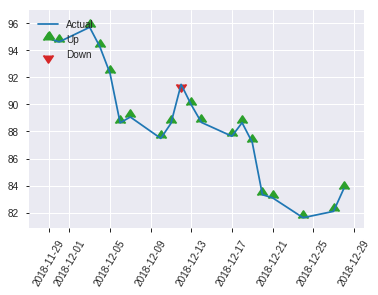


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2527048718778433
RMSE: 0.5026975948598156
LogLoss: 0.6989421733619923
Mean Per-Class Error: 0.4634827852004111
AUC: 0.5184352517985612
pr_auc: 0.460191850740666
Gini: 0.036870503597122406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3519483208656311: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   129  0.9281   (129.0/139.0)
1      2    110  0.0179   (2.0/112.0)
Total  12   239  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351948     0.626781  238
max f2                       0.341799     0.802023  243
max f0point5                 0.351948     0.514981  238
max accuracy                 0.618951     0.565737  10
max precision                0.753047     1         0
max recall                   0.275977     1         250
max specificity              0.753047     1         0
max absolute_mcc             0.351948     0.12601   238
max min_per_class_accuracy   0.482173     0.52518   124
max mean_per_class_accuracy  0.472967     0.536517  139

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 48.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.718425           1.49405   1.49405            0.666667         0.746611  0.666667                    0.746611            0.0178571       0.0178571                  49.4048   49.4048
    2        0.0239044                   0.641576           0.747024  1.12054            0.333333         0.663568  0.5                         0.705089            0.00892857      0.0267857                  -25.2976  12.0536
    3        0.0318725                   0.629809           1.12054   1.12054            0.5              0.633647  0.5                         0.687229            0.00892857      0.0357143                  12.0536   12.0536
    4        0.0438247                   0.618951           2.24107   1.42614            1                0.62303   0.636364                    0.66972             0.0267857       0.0625                     124.107   42.6136
    5        0.0517928                   0.613247           0         1.20673            0                0.616206  0.538462                    0.661487            0               0.0625                     -100      20.6731
    6        0.103586                    0.581218           0.861951  1.03434            0.384615         0.59602   0.461538                    0.628754            0.0446429       0.107143                   -13.8049  3.43407
    7        0.151394                    0.561897           0.93378   1.00258            0.416667         0.567796  0.447368                    0.609504            0.0446429       0.151786                   -6.62202  0.258459
    8        0.203187                    0.547022           1.37912   1.09856            0.615385         0.552305  0.490196                    0.594924            0.0714286       0.223214                   37.9121   9.85644
    9        0.302789                    0.526722           1.07571   1.09105            0.48             0.536001  0.486842                    0.575541            0.107143        0.330357                   7.57143   9.10479
    10       0.40239                     0.504342           0.896429  1.04287            0.4              0.514153  0.465347                    0.560346            0.0892857       0.419643                   -10.3571  4.28748
    11       0.501992                    0.481976           1.07571   1.04939            0.48             0.492962  0.468254                    0.546976            0.107143        0.526786                   7.57143   4.93906
    12       0.601594                    0.466862           1.07571   1.05375            0.48             0.474094  0.470199                    0.53491             0.107143        0.633929                   7.57143   5.37488
    13       0.701195                    0.440973           0.537857  0.980469           0.24             0.45569   0.4375                      0.523657            0.0535714       0.6875                     -46.2143  -1.95312
    14       0.800797                    0.413533           1.07571   0.992315           0.48             0.428279  0.442786                    0.511794            0.107143        0.794643                   7.57143   -0.768479
    15       0.900398                    0.384086           0.986071  0.991625           0.44             0.396171  0.442478                    0.499004            0.0982143       0.892857                   -1.39286  -0.837547
    16       1                           0.275977           1.07571   1                  0.48             0.348961  0.446215                    0.484059   

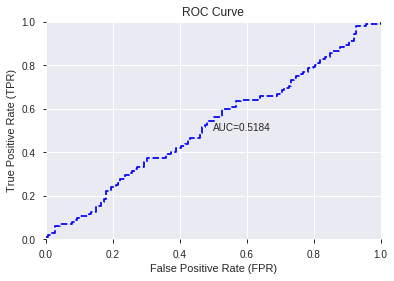

This function is available for GLM models only


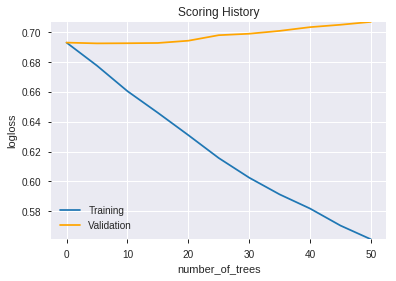

--2019-08-27 13:51:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_135113_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_135113_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'STOCHRSI_fastd',
 'BETA_8',
 'HT_DCPERIOD',
 'DIV',
 'COS',
 'dayofyear',
 'HT_PHASOR_quadrature',
 'SAREXT',
 'STOCHF_fastk',
 'day',
 'DX_14',
 'BETA_12',
 'CORREL_24',
 'BETA_14',
 'STOCHRSI_fastk',
 'CORREL_12',
 'aroonup_20',
 'dayofweek',
 'TANH',
 'aroondown_20',
 'weekday_name',
 'aroondown_8',
 'days_in_month',
 'aroondown_14',
 'CDLRICKSHAWMAN',
 'week',
 'AROONOSC_14',
 'aroondown_12',
 'aroonup_12',
 'weekday',
 'CDLLONGLEGGEDDOJI',
 'HT_TRENDMODE',
 'CDLHIGHWAVE',
 'CDLSPINNINGTOP',
 'weekofyear',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_135146_model_1  0.5  15.411725                   0.5  0.667993  0.446215

variable  relative_importance  scaled_importance    percentage
0                    CDLHARAMI         8.724186e-03           1.000000  1.482296e-02
1               is_month_start         6.504674e-03           0.745591  1.105187e-02
2               CDLSPINNINGTOP         5.738238e-03           0.657739  9.749643e-03
3                days_in_month         5.600028e-03           0.641897  9.514814e-03
4            HT_PHASOR_inphase         5.506864e-03           0.631218  9.356523e-03
...                        ...                  ...                ...           ...
1039  BBANDS_middleband_24_3_3         1.278180e-06           0.000147  2.171712e-06
1040  BBANDS_middleband_20_3_3         1.124396e-06           0.000129  1.910423e-06
1041  BBANDS_middleband_24_3_2         5.305351e-07           0.000061  9.014139e-07
1042             MINMAX_max_14         4.942760e-07           0.000057  8.398074e-07
1043  BBANDS_middleband_30_1_4         1.769807e-07           0.000020  3.007019e-07

[1044 rows x 4 columns]

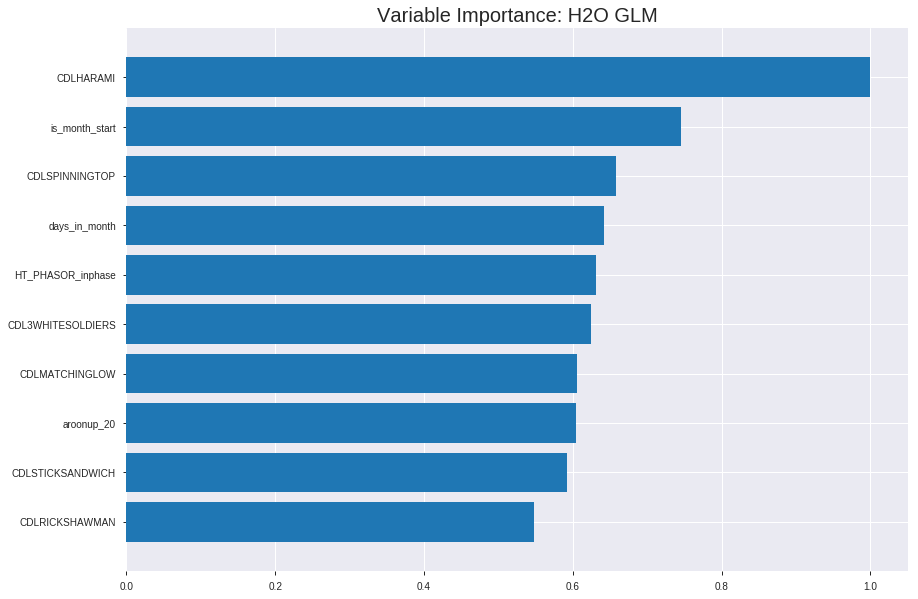

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135146_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24623409725226394
RMSE: 0.4962198073961417
LogLoss: 0.6855838933774423
Null degrees of freedom: 1752
Residual degrees of freedom: 708
Null deviance: 2422.359308081908
Residual deviance: 2403.657130181313
AIC: 4493.657130181313
AUC: 0.5859929657570964
pr_auc: 0.6008480851527878
Gini: 0.17198593151419272
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4783352290915797: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   806   0.9853   (806.0/818.0)
1      2    933   0.0021   (2.0/935.0)
Total  14   1739  0.4609   (808.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478335     0.697831  387
max f2                       0.478335     0.851433  387
max f0point5                 0.515989     0.604733  280
max accuracy                 0.524741     0.572162  243
max precision                0.618973     1         0
max recall                   0.442026     1         397
max specificity              0.618973     1         0
max absolute_mcc             0.53804      0.138466  174
max min_per_class_accuracy   0.534347     0.567237  194
max mean_per_class_accuracy  0.53804      0.568804  174

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.582355           0.937433  0.937433           0.5              0.592221  0.5                         0.592221            0.00962567      0.00962567                 -6.25668  -6.25668
    2        0.0205362                   0.574699           1.04159   0.989513           0.555556         0.57802   0.527778                    0.58512             0.0106952       0.0203209                  4.15924   -1.04872
    3        0.0302339                   0.571275           1.65429   1.20274            0.882353         0.572919  0.641509                    0.581206            0.0160428       0.0363636                  65.4294   20.2744
    4        0.040502                    0.569056           1.14575   1.1883             0.611111         0.570089  0.633803                    0.578388            0.0117647       0.0481283                  14.5752   18.8296
    5        0.0501997                   0.567559           1.21315   1.1931             0.647059         0.568327  0.636364                    0.576444            0.0117647       0.059893                   21.3149   19.3097
    6        0.100399                    0.559945           1.27832   1.23571            0.681818         0.563256  0.659091                    0.56985             0.0641711       0.124064                   27.8318   23.5707
    7        0.150029                    0.554595           1.24991   1.24041            0.666667         0.557322  0.661597                    0.565706            0.0620321       0.186096                   24.9911   24.0406
    8        0.200228                    0.551048           1.06526   1.1965             0.568182         0.552648  0.638177                    0.562432            0.0534759       0.239572                   6.52649   19.6496
    9        0.300057                    0.545141           1.08207   1.15843            0.577143         0.547803  0.617871                    0.557565            0.108021        0.347594                   8.20657   15.8425
    10       0.399886                    0.539763           1.11421   1.14739            0.594286         0.542417  0.611983                    0.553783            0.11123         0.458824                   11.4206   14.7386
    11       0.500285                    0.534479           1.03331   1.12449            0.551136         0.537175  0.599772                    0.55045             0.103743        0.562567                   3.3307    12.4492
    12       0.600114                    0.528781           0.94279   1.09427            0.502857         0.531762  0.58365                     0.547341            0.0941176       0.656684                   -5.72101  9.42661
    13       0.699943                    0.523038           0.94279   1.07266            0.502857         0.525941  0.572127                    0.544289            0.0941176       0.750802                   -5.72101  7.26619
    14       0.799772                    0.514988           0.932076  1.05511            0.497143         0.519446  0.562767                    0.541188            0.0930481       0.84385                    -6.79236  5.51138
    15       0.899601                    0.50559            0.728519  1.01887            0.388571         0.510773  0.543437                    0.537813            0.0727273       0.916578                   -27.1481  1.88715
    16       1                           0.416849           0.830907  1                  0.443182         0.493572  0.533371                    0.533371       



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.35216270658023785
RMSE: 0.5934329840683258
LogLoss: 5.4192343995706205
Null degrees of freedom: 500
Residual degrees of freedom: -544
Null deviance: 692.8933692915758
Residual deviance: 58216.807277513384
AIC: 60306.807277513384
AUC: 0.536728493763991
pr_auc: 0.5612238947340722
Gini: 0.07345698752798202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.3836175364627794e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    236  1        (236.0/236.0)
1      0    265  0        (0.0/265.0)
Total  0    501  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.38362e-48  0.691906   394
max f2                       2.38362e-48  0.848815   394
max f0point5                 1.81602e-42  0.590637   392
max accuracy                 4.9354e-42   0.552894   390
max precision                0.538709     0.833333   5
max recall                   2.38362e-48  1          394
max specificity              0.549877     0.995763   0
max absolute_mcc             0.514538     0.0903239  117
max min_per_class_accuracy   0.496252     0.495763   250
max mean_per_class_accuracy  0.00029852   0.540462   341

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 29.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.538709           1.57547   1.57547            0.833333         0.542482     0.833333                    0.542482            0.0188679       0.0188679                  57.5472   57.5472
    2        0.0219561                   0.537523           0.756226  1.20309            0.4              0.538006     0.636364                    0.540447            0.00754717      0.0264151                  -24.3774  20.3087
    3        0.0319361                   0.533308           1.13434   1.1816             0.6              0.534243     0.625                       0.538509            0.0113208       0.0377358                  13.434    18.1604
    4        0.0419162                   0.530564           0.756226  1.08032            0.4              0.531551     0.571429                    0.536852            0.00754717      0.045283                   -24.3774  8.03235
    5        0.0518962                   0.529703           1.13434   1.09071            0.6              0.529987     0.576923                    0.535532            0.0113208       0.0566038                  13.434    9.07112
    6        0.101796                    0.526239           1.28558   1.18624            0.68             0.527925     0.627451                    0.531803            0.0641509       0.120755                   28.5585   18.6238
    7        0.151697                    0.520237           1.05872   1.14429            0.56             0.523777     0.605263                    0.529163            0.0528302       0.173585                   5.8717    14.429
    8        0.201597                    0.516859           1.05872   1.12311            0.56             0.518312     0.594059                    0.526477            0.0528302       0.226415                   5.8717    12.3109
    9        0.301397                    0.509475           0.907472  1.05171            0.48             0.513209     0.556291                    0.522084            0.090566        0.316981                   -9.25283  5.17056
    10       0.401198                    0.503917           0.86966   1.00642            0.46             0.506655     0.532338                    0.518246            0.0867925       0.403774                   -13.034   0.642073
    11       0.500998                    0.496252           0.945283  0.994242           0.5              0.500476     0.525896                    0.514706            0.0943396       0.498113                   -5.4717   -0.57581
    12       0.600798                    0.133433           1.28558   1.04264            0.68             0.392109     0.551495                    0.494341            0.128302        0.626415                   28.5585   4.26377
    13       0.700599                    1.84423e-06        1.05872   1.04493            0.56             0.0192846    0.552707                    0.426669            0.10566         0.732075                   5.8717    4.49282
    14       0.800399                    1.72245e-60        1.02091   1.04193            0.54             3.27357e-08  0.551122                    0.373469            0.101887        0.833962                   2.09057   4.19329
    15       1                           0                  0.831849  1                  0.44             9.89353e-64  0.528942                    0.298924            0.166038        1                          -16.8151  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:51:51  0.000 sec   2            3.4       1045          1.37117           116.201
    2019-08-27 13:51:53  2.331 sec   4            2.5       1045          1.36851           121.119
    2019-08-27 13:51:55  4.640 sec   6            1.8       1045          1.36535           126.686
    2019-08-27 13:51:58  6.989 sec   8            1.3       1045          1.36168           132.714
    2019-08-27 13:52:00  9.313 sec   10           0.97      1045          1.3575            138.827

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.44621513944223107)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6170798898071626)

('auc', 0.5)

('logloss', 15.4117249252191)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.6679933678130577)

('mse', 0.44621513944223107)

glm prediction progress: |████████████████████████████████████████████████| 100%


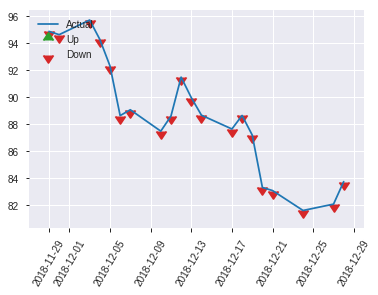


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.44621513944223107
RMSE: 0.6679933678130577
LogLoss: 15.4117249252191
Null degrees of freedom: 250
Residual degrees of freedom: -794
Null deviance: 352.68995809423006
Residual deviance: 158680.79775122716
AIC: 160770.79775122716
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.61708   0
max f2                       0            0.801144  0
max f0point5                 0            0.501792  0
max accuracy                 0            0.446215  0
max precision                0            0.446215  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 44.62 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.446215         0        0.446215                    0                   1               1                          0       0

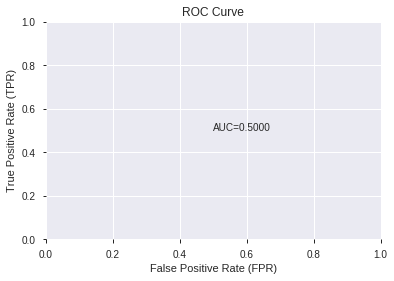

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


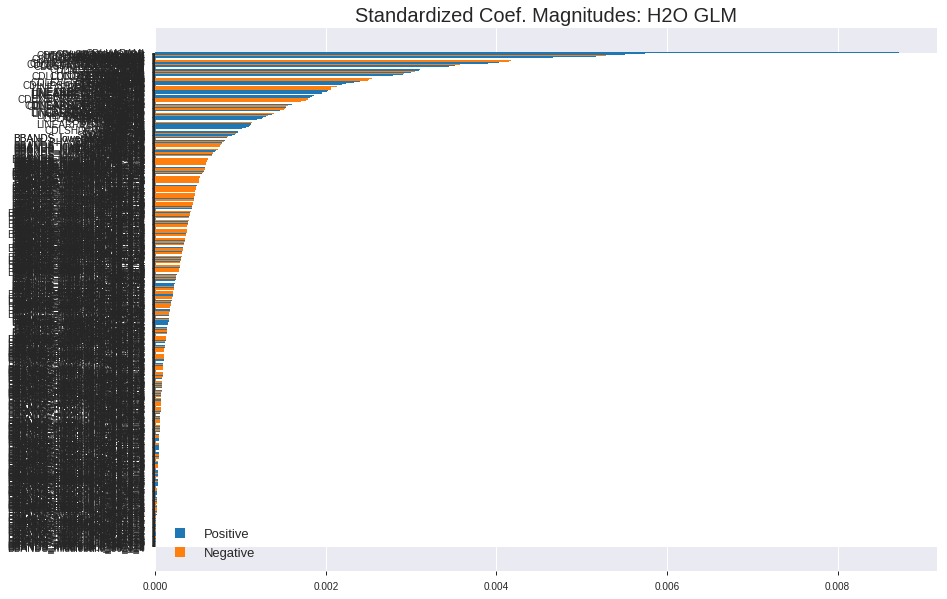

'log_likelihood'
--2019-08-27 13:52:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135146_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135146_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

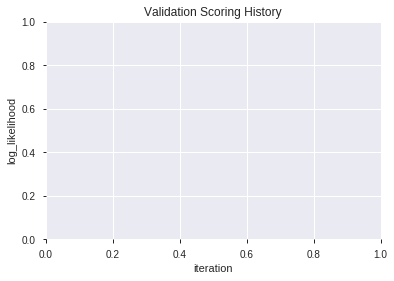

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_135238  0.542523  0.687959              0.496403  0.497164  0.247172
1  XGBoost_grid_1_AutoML_20190827_135238_model_5  0.537834  0.705104              0.481019  0.504506  0.254527
2               XGBoost_2_AutoML_20190827_135238  0.525822  0.692320              0.480152  0.499405  0.249406
3  XGBoost_grid_1_AutoML_20190827_135238_model_3  0.521326  0.704861              0.492806  0.504701  0.254723
4  XGBoost_grid_1_AutoML_20190827_135238_model_1  0.508800  0.703791              0.485483  0.504344  0.254363
5  XGBoost_grid_1_AutoML_20190827_135238_model_7  0.498651  0.713436              0.476554  0.508871  0.258950
6  XGBoost_grid_1_AutoML_20190827_135238_model_6  0.496146  0.724542              0.500000  0.513077  0.263248
7               XGBoost_1_AutoML_20190827_135238  0.487860  0.704419              0.500000  0.504810  0.254833
8  XGBoost_grid_1_AutoML_20190827_135238_model_2  0.477711  0.695649              0.496403  0.501228  0.251229
9  XGBoost_grid_1_AutoML_20190827_135238_model_4  0.471994  0.698767              0.485612  0.502781  0.252789

variable  relative_importance  scaled_importance  percentage
0                    BETA_12           132.800812           1.000000    0.024850
1                     Volume           112.476646           0.846958    0.021047
2                        DIV            91.540024           0.689303    0.017129
3          HT_PHASOR_inphase            90.823273           0.683906    0.016995
4             STOCHRSI_fastd            89.086586           0.670829    0.016670
..                       ...                  ...                ...         ...
292  BBANDS_lowerband_30_1_4             1.266885           0.009540    0.000237
293  BBANDS_upperband_14_0_2             1.211161           0.009120    0.000227
294   BBANDS_lowerband_8_4_4             0.828176           0.006236    0.000155
295  BBANDS_lowerband_14_1_5             0.534309           0.004023    0.000100
296              AROONOSC_14             0.045868           0.000345    0.000009

[297 rows x 4 columns]

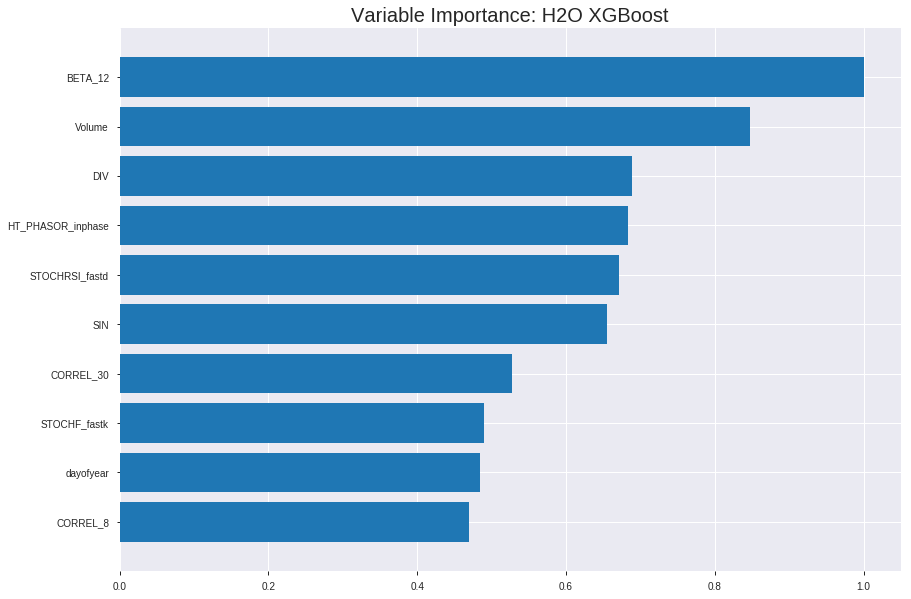

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_135238


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1786802699999249
RMSE: 0.4227058906614916
LogLoss: 0.5466956357944689
Mean Per-Class Error: 0.09542381967234548
AUC: 0.961063896552175
pr_auc: 0.9642177766342066
Gini: 0.9221277931043499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5237589478492737: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      733  85   0.1039   (85.0/818.0)
1      82   853  0.0877   (82.0/935.0)
Total  815  938  0.0953   (167.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523759     0.910838  196
max f2                       0.480672     0.930873  240
max f0point5                 0.539448     0.917254  180
max accuracy                 0.52583      0.904735  194
max precision                0.770161     1         0
max recall                   0.397293     1         323
max specificity              0.770161     1         0
max absolute_mcc             0.52583      0.808745  194
max min_per_class_accuracy   0.52583      0.9022    194
max mean_per_class_accuracy  0.52583      0.904576  194

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.73064            1.87487    1.87487            1                0.746631  1                           0.746631            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.716031           1.87487    1.87487            1                0.724055  1                           0.735343            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.702751           1.87487    1.87487            1                0.707306  1                           0.72635             0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.693914           1.87487    1.87487            1                0.697767  1                           0.719103            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.687213           1.87487    1.87487            1                0.691208  1                           0.713714            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.661276           1.87487    1.87487            1                0.672396  1                           0.693055            0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.644198           1.87487    1.87487            1                0.653383  1                           0.679932            0.0930481       0.281283                   87.4866   87.4866
    8        0.200228                    0.62829            1.87487    1.87487            1                0.636711  1                           0.669096            0.0941176       0.375401                   87.4866   87.4866
    9        0.300057                    0.598554           1.81059    1.85348            0.965714         0.612206  0.988593                    0.650169            0.180749        0.55615                    81.0585   85.348
    10       0.399886                    0.568734           1.62846    1.7973             0.868571         0.584459  0.958631                    0.633765            0.162567        0.718717                   62.8455   79.7304
    11       0.500285                    0.536037           1.51268    1.74018            0.806818         0.553247  0.928164                    0.617606            0.151872        0.870588                   51.2676   74.0184
    12       0.600114                    0.499218           0.76066    1.57724            0.405714         0.517346  0.841255                    0.600928            0.0759358       0.946524                   -23.934   57.724
    13       0.699943                    0.468692           0.385687   1.4073             0.205714         0.484033  0.750611                    0.584256            0.0385027       0.985027                   -61.4313  40.7296
    14       0.799772                    0.432144           0.107135   1.24501            0.0571429        0.449803  0.664051                    0.567473            0.0106952       0.995722                   -89.2865  24.5008
    15       0.899601                    0.392681           0.0428541  1.1116             0.0228571        0.413835  0.592898                    0.550424            0.00427807      1                          -95.7146  11.1604
    16       1                           0.205573           0          1                  0                0.345694  0.533371                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2617331332109999
RMSE: 0.511598605560062
LogLoss: 0.7178548997910021
Mean Per-Class Error: 0.4776383114806524
AUC: 0.5078349856092101
pr_auc: 0.5462622658304489
Gini: 0.015669971218420287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29311084747314453: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    228  0.9661   (228.0/236.0)
1      4    261  0.0151   (4.0/265.0)
Total  12   489  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293111     0.692308  388
max f2                       0.25155      0.848815  399
max f0point5                 0.293111     0.587573  388
max accuracy                 0.293111     0.536926  388
max precision                0.726912     1         0
max recall                   0.25155      1         399
max specificity              0.726912     1         0
max absolute_mcc             0.648257     0.112336  6
max min_per_class_accuracy   0.441155     0.520755  201
max mean_per_class_accuracy  0.451701     0.522362  192

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 45.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.650043           1.89057   1.89057            1                0.671908  1                           0.671908            0.0226415       0.0226415                  89.0566   89.0566
    2        0.0219561                   0.629931           0.756226  1.37496            0.4              0.635244  0.727273                    0.655242            0.00754717      0.0301887                  -24.3774  37.4957
    3        0.0319361                   0.61868            0.378113  1.06344            0.2              0.62118   0.5625                      0.644598            0.00377358      0.0339623                  -62.1887  6.34434
    4        0.0419162                   0.61322            1.13434   1.08032            0.6              0.615579  0.571429                    0.637689            0.0113208       0.045283                   13.434    8.03235
    5        0.0518962                   0.602922           0.378113  0.945283           0.2              0.606227  0.5                         0.631638            0.00377358      0.0490566                  -62.1887  -5.4717
    6        0.101796                    0.568018           0.983094  0.963818           0.52             0.588367  0.509804                    0.610427            0.0490566       0.0981132                  -1.69057  -3.6182
    7        0.151697                    0.548578           1.13434   1.01991            0.6              0.558887  0.539474                    0.593473            0.0566038       0.154717                   13.434    1.99106
    8        0.201597                    0.537192           1.13434   1.04823            0.6              0.542672  0.554455                    0.580899            0.0566038       0.211321                   13.434    4.82346
    9        0.301397                    0.505651           0.983094  1.02667            0.52             0.519934  0.543046                    0.560712            0.0981132       0.309434                   -1.69057  2.6665
    10       0.401198                    0.476151           1.05872   1.03464            0.56             0.489408  0.547264                    0.542975            0.10566         0.415094                   5.8717    3.46381
    11       0.500998                    0.441155           1.05872   1.03943            0.56             0.459437  0.549801                    0.526334            0.10566         0.520755                   5.8717    3.94347
    12       0.600798                    0.418822           0.907472  1.01751            0.48             0.429129  0.538206                    0.510187            0.090566        0.611321                   -9.25283  1.75139
    13       0.700599                    0.391194           0.945283  1.00722            0.5              0.405347  0.532764                    0.495252            0.0943396       0.70566                    -5.4717   0.722464
    14       0.800399                    0.366695           0.680604  0.966499           0.36             0.378398  0.511222                    0.480682            0.0679245       0.773585                   -31.9396  -3.35012
    15       0.9002                      0.334139           1.17215   0.989298           0.62             0.35222   0.523282                    0.46644             0.116981        0.890566                   17.2151   -1.07016
    16       1                           0.25155            1.09653   1                  0.58             0.306775  0.528942                    0.450505       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:52:51  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.471058
    2019-08-27 13:52:53  1.277 sec   5                  0.492035         0.677311            0.739155        0.764606           1.87487          0.362236                         0.501599           0.696371              0.512568          0.564875             1.26038            0.471058
    2019-08-27 13:52:53  1.508 sec   10                 0.482878         0.659339            0.816204        0.830067           1.87487          0.2664                           0.502605           0.698438              0.511041          0.546426             1.08032            0.471058
    2019-08-27 13:52:53  1.722 sec   15                 0.476543         0.646986            0.842271        0.856387           1.87487          0.24016                          0.505225           0.70385               0.498929          0.534735             1.26038            0.467066
    2019-08-27 13:52:53  1.968 sec   20                 0.467934         0.630423            0.876023        0.888853           1.87487          0.209355                         0.507348           0.708369              0.499488          0.532216             0.945283           0.471058
    2019-08-27 13:52:53  2.219 sec   25                 0.458143         0.611901            0.912264        0.922941           1.87487          0.17741                          0.509244           0.712527              0.50008           0.532868             1.26038            0.469062
    2019-08-27 13:52:54  2.445 sec   30                 0.451636         0.599667            0.92133         0.93134            1.87487          0.166001                         0.508655           0.711205              0.497354          0.539378             1.57547            0.469062
    2019-08-27 13:52:54  2.686 sec   35                 0.443482         0.58451             0.936825        0.944204           1.87487          0.134626                         0.508012           0.709993              0.511401          0.54701              1.57547            0.469062
    2019-08-27 13:52:54  2.929 sec   40                 0.435508         0.569892            0.947673        0.953453           1.87487          0.114661                         0.509945           0.714195              0.507955          0.54643              1.89057            0.471058
    2019-08-27 13:52:54  3.166 sec   45                 0.428451         0.557045            0.956311        0.960861           1.87487          0.107245                         0.511154           0.716878              0.509738          0.546234             1.89057            0.467066
    2019-08-27 13:52:55  3.434 sec   50                 0.422706         0.546696            0.961064        0.964218           1.87487          0.0952653                        0.511599           0.717855              0.507835          0.546262             1.89057            0.463074

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BETA_12                  132.80081176757812     1.0                    0.024850377787169982
Volume                   112.47664642333984     0.846957521767196      0.02104721438560006
DIV                      91.54002380371094      0.6893031946515513     0.017129444796994218
HT_PHASOR_inphase        90.82327270507812      0.6839060055147317     0.016995322607955436
STOCHRSI_fastd           89.08658599853516      0.6708286253133031     0.01667034476948348
---                      ---                    ---                    ---
BBANDS_lowerband_30_1_4  1.2668848037719727     0.009539736895503442   0.00023706606584346463
BBANDS_upperband_14_0_2  1.211160659790039      0.009120129942501833   0.0002266386745392514
BBANDS_lowerband_8_4_4   0.8281755447387695     0.006236223511857776   0.00015497251023489765
BBANDS_lowerband_14_1_5  0.5343093872070312     0.004023389466490272   9.998274822720355e-05
AROONOSC_14              0.045867919921875      0.0003453888520060474  8.58304345582722e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6187845303867404)

('auc', 0.5425231243576568)

('logloss', 0.6879590793058681)

('mean_per_class_error', 0.44228545734840696)

('rmse', 0.4971643445974995)

('mse', 0.2471723855390612)

xgboost prediction progress: |████████████████████████████████████████████| 100%


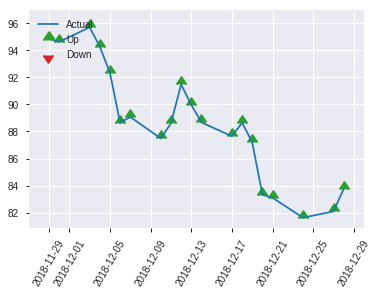


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2471723855390612
RMSE: 0.4971643445974995
LogLoss: 0.6879590793058681
Mean Per-Class Error: 0.44228545734840696
AUC: 0.5425231243576568
pr_auc: 0.503611098598035
Gini: 0.08504624871531363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2810218036174774: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    138  0.9928   (138.0/139.0)
1      0    112  0        (0.0/112.0)
Total  1    250  0.5498   (138.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281022     0.618785  249
max f2                       0.281022     0.802292  249
max f0point5                 0.3828       0.522487  160
max accuracy                 0.528961     0.573705  10
max precision                0.584741     1         0
max recall                   0.281022     1         249
max specificity              0.584741     1         0
max absolute_mcc             0.31207      0.144973  240
max min_per_class_accuracy   0.410576     0.535714  123
max mean_per_class_accuracy  0.3828       0.557715  160

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 41.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.571612           2.24107   2.24107            1                0.582742  1                           0.582742            0.0267857       0.0267857                  124.107   124.107
    2        0.0239044                   0.550261           1.49405   1.86756            0.666667         0.556119  0.833333                    0.569431            0.0178571       0.0446429                  49.4048   86.756
    3        0.0318725                   0.539376           1.12054   1.6808             0.5              0.545052  0.75                        0.563336            0.00892857      0.0535714                  12.0536   68.0804
    4        0.0438247                   0.528961           1.49405   1.62987            0.666667         0.532511  0.727273                    0.554929            0.0178571       0.0714286                  49.4048   62.987
    5        0.0517928                   0.526881           0         1.37912            0                0.52759   0.615385                    0.550723            0               0.0714286                  -100      37.9121
    6        0.103586                    0.509615           1.20673   1.29293            0.538462         0.516416  0.576923                    0.533569            0.0625          0.133929                   20.6731   29.2926
    7        0.151394                    0.488823           1.12054   1.23849            0.5              0.499892  0.552632                    0.522934            0.0535714       0.1875                     12.0536   23.8487
    8        0.203187                    0.471211           0.861951  1.14251            0.384615         0.48007   0.509804                    0.512008            0.0446429       0.232143                   -13.8049  14.2507
    9        0.302789                    0.445765           1.16536   1.15002            0.52             0.456764  0.513158                    0.493836            0.116071        0.348214                   16.5357   15.0023
    10       0.40239                     0.42502            0.717143  1.04287            0.32             0.434664  0.465347                    0.479189            0.0714286       0.419643                   -28.2857  4.28748
    11       0.501992                    0.408545           1.16536   1.06718            0.52             0.416225  0.47619                     0.466696            0.116071        0.535714                   16.5357   6.71769
    12       0.601594                    0.38902            0.986071  1.05375            0.44             0.398716  0.470199                    0.455441            0.0982143       0.633929                   -1.39286  5.37488
    13       0.701195                    0.371007           0.986071  1.04414            0.44             0.380511  0.465909                    0.444798            0.0982143       0.732143                   -1.39286  4.41356
    14       0.800797                    0.350892           0.896429  1.02576            0.4              0.362219  0.457711                    0.434527            0.0892857       0.821429                   -10.3571  2.5764
    15       0.900398                    0.329995           0.806786  1.00154            0.36             0.343117  0.446903                    0.424415            0.0803571       0.901786                   -19.3214  0.154077
    16       1                           0.27081            0.986071  1                  0.44             0.30995   0.446215                    0.413014           

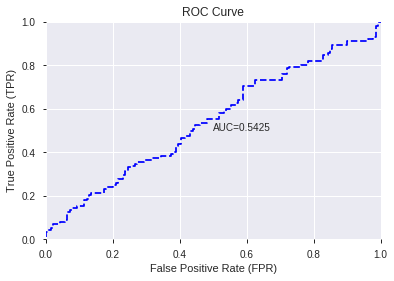

This function is available for GLM models only


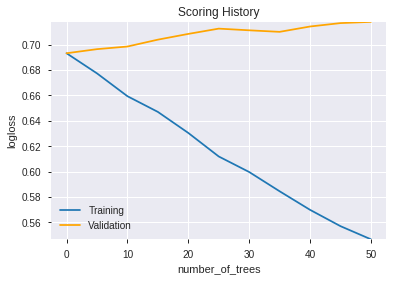

--2019-08-27 13:53:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_135238',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_135238',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_8ce1',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_135346_model_8  0.556783  0.703414              0.500000  0.505098  0.255124
1  DeepLearning_grid_1_AutoML_20190827_135346_model_9  0.522161  0.691989              0.500000  0.499421  0.249421
2  DeepLearning_grid_1_AutoML_20190827_135346_model_7  0.499165  0.885810              0.492806  0.560965  0.314682
3  DeepLearning_grid_1_AutoML_20190827_135346_model_4  0.491650  0.982938              0.496403  0.585952  0.343340
4  DeepLearning_grid_1_AutoML_20190827_135346_model_6  0.482849  0.713888              0.500000  0.509331  0.259419
5  DeepLearning_grid_1_AutoML_20190827_135346_model_1  0.481308  1.301052              0.500000  0.608552  0.370335
6  DeepLearning_grid_1_AutoML_20190827_135346_model_5  0.473407  0.706656              0.486479  0.506153  0.256191
7  DeepLearning_grid_1_AutoML_20190827_135346_model_3  0.437307  1.007688              0.500000  0.590981  0.349259
8               DeepLearning_1_AutoML_20190827_135346  0.435252  0.916380              0.500000  0.584469  0.341604
9  DeepLearning_grid_1_AutoML_20190827_135346_model_2  0.432490  0.993958              0.496403  0.597511  0.357019

variable  relative_importance  scaled_importance  percentage
0             aroonup_20             1.000000           1.000000    0.024180
1              dayofweek             0.917043           0.917043    0.022174
2           weekday_name             0.913818           0.913818    0.022096
3                    SIN             0.910229           0.910229    0.022009
4         STOCHRSI_fastk             0.905496           0.905496    0.021895
5                    day             0.903831           0.903831    0.021855
6                    COS             0.900339           0.900339    0.021770
7             aroonup_12             0.894471           0.894471    0.021628
8           aroondown_14             0.883739           0.883739    0.021369
9                 BETA_8             0.877044           0.877044    0.021207
10          STOCHF_fastk             0.869463           0.869463    0.021024
11             dayofyear             0.867592           0.867592    0.020978
12         days_in_month             0.859672           0.859672    0.020787
13          aroondown_12             0.857876           0.857876    0.020744
14               weekday             0.855249           0.855249    0.020680
15                 DX_14             0.851124           0.851124    0.020580
16    CDLCLOSINGMARUBOZU             0.845897           0.845897    0.020454
17          aroondown_20             0.844463           0.844463    0.020419
18           aroondown_8             0.842948           0.842948    0.020383
19        STOCHRSI_fastd             0.841766           0.841766    0.020354
20          HT_TRENDMODE             0.837825           0.837825    0.020259
21           HT_DCPERIOD             0.836689           0.836689    0.020231
22        CDLSPINNINGTOP             0.831324           0.831324    0.020102
23               BETA_14             0.827191           0.827191    0.020002
24     CDLLONGLEGGEDDOJI             0.827152           0.827152    0.020001
25               quarter             0.826764           0.826764    0.019991
26           CDLHIGHWAVE             0.825153           0.825153    0.019952
27                  TANH             0.824384           0.824384    0.019934
28            weekofyear             0.822410           0.822410    0.019886
29             CORREL_12             0.822357           0.822357    0.019885
30                  week             0.806707           0.806707    0.019506
31                SAREXT             0.801514           0.801514    0.019381
32               CDLDOJI             0.793417           0.793417    0.019185
33  HT_PHASOR_quadrature             0.790263           0.790263    0.019109
34           AROONOSC_14             0.787229           0.787229    0.019035
35   CDLRISEFALL3METHODS             0.786571           0.786571    0.019019
36                 month             0.785063           0.785063    0.018983
37                   DIV             0.783844           0.783844    0.018953
38      CDLSTICKSANDWICH             0.782565           0.782565    0.018923
39        CDLRICKSHAWMAN             0.774153           0.774153    0.018719
40     CDL3WHITESOLDIERS             0.773322           0.773322    0.018699
41        CDL3LINESTRIKE             0.772042           0.772042    0.018668
42               BETA_12             0.768339           0.768339    0.018579
43       CDLUNIQUE3RIVER             0.766977           0.766977    0.018546
44             CDLINNECK             0.763640           0.763640    0.018465
45       CDLADVANCEBLOCK             0.753395           0.753395    0.018217
46           CDLPIERCING             0.742939           0.742939    0.017964
47             CDL2CROWS             0.738125           0.738125    0.017848
48             CORREL_24             0.736373           0.736373    0.017806
49    CDLUPSIDEGAP2CROWS             0.726480           0.726480    0.017566

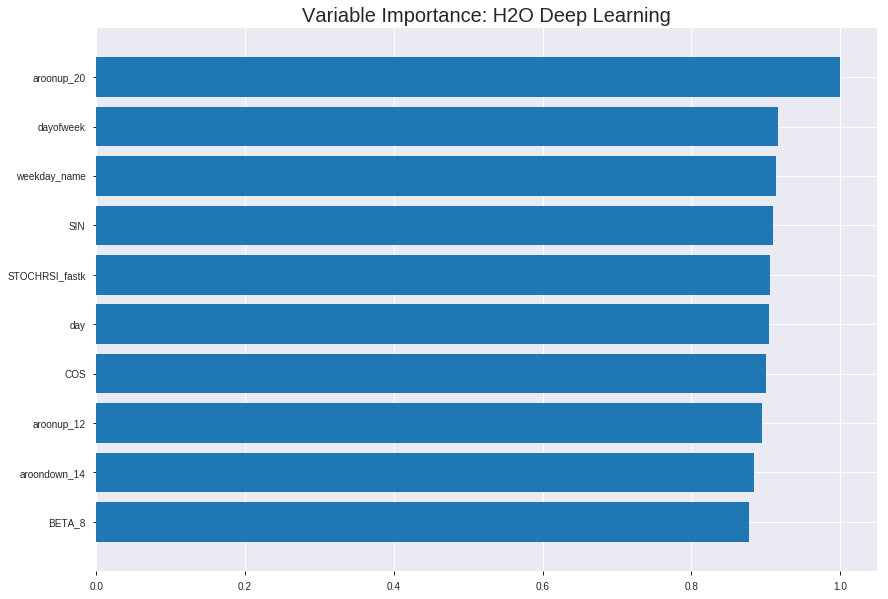

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_135346_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24888718873917218
RMSE: 0.49888594762648125
LogLoss: 0.6909198889089427
Mean Per-Class Error: 0.4928088594851143
AUC: 0.49636389785965507
pr_auc: 0.48551990720237764
Gini: -0.007272204280689865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5346570637525253: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    817   0.9988   (817.0/818.0)
1      0    935   0        (0.0/935.0)
Total  1    1752  0.4661   (817.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.534657     0.695943   398
max f2                       0.534657     0.851238   398
max f0point5                 0.534657     0.588569   398
max accuracy                 0.534657     0.533942   398
max precision                0.542912     1          0
max recall                   0.534657     1          398
max specificity              0.542912     1          0
max absolute_mcc             0.536054     0.0472819  40
max min_per_class_accuracy   0.535976     0.325183   41
max mean_per_class_accuracy  0.535617     0.507191   238

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.536573           0.833274  0.833274           0.444444         0.537956  0.444444                    0.537956            0.00855615      0.00855615                 -16.6726  -16.6726
    2        0.0205362                   0.536195           0.833274  0.833274           0.444444         0.536393  0.444444                    0.537174            0.00855615      0.0171123                  -16.6726  -16.6726
    3        0.675984                    0.535976           1.00678   1.00151            0.536989         0.535977  0.534177                    0.536013            0.659893        0.677005                   0.6782    0.151086
    4        0.699943                    0.535936           0.982073  1.00085            0.52381          0.535957  0.533822                    0.536011            0.0235294       0.700535                   -1.79272  0.0845504
    5        0.799772                    0.535789           1.00707   1.00162            0.537143         0.535873  0.534237                    0.535994            0.100535        0.80107                    0.707105  0.162259
    6        0.899601                    0.535546           1.00707   1.00223            0.537143         0.535674  0.534559                    0.535959            0.100535        0.901604                   0.707105  0.22272
    7        1                           0.534219           0.980044  1                  0.522727         0.535328  0.533371                    0.535895            0.0983957       1                          -1.99562  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24918503267796163
RMSE: 0.49918436742145844
LogLoss: 0.6915164610782185
Mean Per-Class Error: 0.44748960665174287
AUC: 0.525999360409338
pr_auc: 0.5111919708472371
Gini: 0.05199872081867607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5352214278746755: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    232  0.9831   (232.0/236.0)
1      2    263  0.0075   (2.0/265.0)
Total  6    495  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535221     0.692105  185
max f2                       0.534899     0.848815  191
max f0point5                 0.535775     0.597015  78
max accuracy                 0.535867     0.56487   52
max precision                0.54109      1         0
max recall                   0.534899     1         191
max specificity              0.54109      1         0
max absolute_mcc             0.535867     0.116322  52
max min_per_class_accuracy   0.535976     0.377119  16
max mean_per_class_accuracy  0.535867     0.55251   52

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.536909           1.26038   1.26038            0.666667         0.538395  0.666667                    0.538395            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.536288           0.756226  1.03122            0.4              0.536602  0.545455                    0.53758             0.00754717      0.0226415                  -24.3774  3.12178
    3        0.0319361                   0.535995           0.378113  0.827123           0.2              0.536116  0.4375                      0.537123            0.00377358      0.0264151                  -62.1887  -17.2877
    4        0.644711                    0.535976           1.04074   1.03015            0.550489         0.535976  0.544892                    0.536033            0.637736        0.664151                   4.07351   3.01536
    5        0.700599                    0.535889           1.41792   1.06109            0.75             0.535929  0.561254                    0.536024            0.0792453       0.743396                   41.7925   6.10869
    6        0.800399                    0.535726           0.86966   1.03722            0.46             0.53581   0.548628                    0.535998            0.0867925       0.830189                   -13.034   3.72183
    7        0.9002                      0.53555            0.680604  0.997682           0.36             0.535654  0.527716                    0.53596             0.0679245       0.898113                   -31.9396  -0.23177
    8        1                           0.534899           1.02091   1                  0.54             0.535379  0.528942                    0.535902            0.101887        1                          2.09057   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:59:18  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:59:20  1 min 14.101 sec  624 obs/sec       0.561323  1             984        0.568248         0.864733            -0.297404      0.502735        0.544971           1.45823          0.464347                         0.575535           0.886352              -0.329417        0.429485          0.480175             0.945283           0.469062
    2019-08-27 13:59:31  1 min 25.111 sec  1020 obs/sec      6.75242   12            11837      0.498886         0.69092             -3.36151e-06   0.496364        0.48552            0.833274         0.466058                         0.499184           0.691516              -9.10199e-05     0.525999          0.511192             1.26038            0.467066
    2019-08-27 13:59:41  1 min 35.396 sec  1182 obs/sec      14.0924   25            24704      0.498454         0.690049            0.00172808     0.564198        0.574889           1.04159          0.44324                          0.49971            0.692581              -0.00219955      0.522769          0.529851             1.26038            0.45509
    2019-08-27 13:59:51  1 min 45.569 sec  1280 obs/sec      21.9681   39            38510      0.501049         0.695336            -0.0086918     0.568865        0.597996           1.45823          0.434113                         0.503377           0.700092              -0.0169626       0.501551          0.522824             0.630189           0.471058
    2019-08-27 14:00:02  1 min 55.976 sec  1347 obs/sec      30.3411   54            53188      0.488594         0.670033            0.0408299      0.620519        0.643552           1.56239          0.416999                         0.506108           0.707824              -0.0280275       0.45331           0.498092             0.630189           0.471058
    2019-08-27 14:00:12  2 min  6.268 sec  1374 obs/sec      38.251    68            67054      0.476798         0.643603            0.086584       0.673532        0.707381           1.87487          0.387336                         0.502635           0.707743              -0.0139646       0.504733          0.510373             0.630189           0.457086
    2019-08-27 14:00:22  2 min 16.162 sec  1403 obs/sec      46.1746   82            80944      0.459595         0.602684            0.15131        0.704415        0.735865           1.87487          0.369652                         0.528728           0.795703              -0.121973        0.476271          0.491239             0.315094           0.471058
    2019-08-27 14:00:23  2 min 17.174 sec  1402 obs/sec      46.1746   82            80944      0.498886         0.69092             -3.36151e-06   0.496364        0.48552            0.833274         0.466058                         0.499184           0.691516              -9.10199e-05     0.525999          0.511192             1.26038            0.467066

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
aroonup_20          1.0                    1.0                  0.02418013161042897
dayofweek           0.9170433878898621     0.9170433878898621   0.022174229811650528
weekday_name        0.9138180613517761     0.9138180613517761   0.022096240991473
SIN                 0.9102293848991394     0.9102293848991394   0.022009466322541
STOCHRSI_fastk      0.9054964184761047     0.9054964184761047   0.02189502257152428
---                 ---                    ---                  ---
CDLADVANCEBLOCK     0.7533954381942749     0.7533954381942749   0.018217200850234372
CDLPIERCING         0.7429385781288147     0.7429385781288147   0.017964352597619703
CDL2CROWS           0.738124668598175      0.738124668598175    0.017847951631608138
CORREL_24           0.7363729476928711     0.7363729476928711   0.01780559478957315
CDLUPSIDEGAP2CROWS  0.726479709148407      0.726479709148407    0.01756637497951464


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6170798898071626)

('auc', 0.5567831449126412)

('logloss', 0.7034141653386703)

('mean_per_class_error', 0.4262911099691675)

('rmse', 0.5050976537028959)

('mse', 0.25512363977617064)

deeplearning prediction progress: |███████████████████████████████████████| 100%


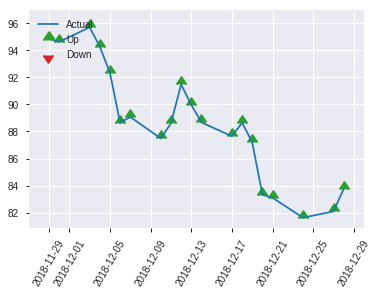


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25512363977617064
RMSE: 0.5050976537028959
LogLoss: 0.7034141653386703
Mean Per-Class Error: 0.4262911099691675
AUC: 0.5567831449126412
pr_auc: 0.3073405365648106
Gini: 0.1135662898252825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5349098148067216: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.53491      0.61708   88
max f2                       0.53491      0.801144  88
max f0point5                 0.535959     0.536616  7
max accuracy                 0.535959     0.553785  7
max precision                0.535959     0.5       7
max recall                   0.53491      1         88
max specificity              0.53611      0.992806  0
max absolute_mcc             0.535959     0.156747  7
max min_per_class_accuracy   0.535976     0.395683  2
max mean_per_class_accuracy  0.535959     0.573709  7

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.657371                    0.535976           1.10016   1.10016            0.490909         0.535977  0.490909                    0.535977            0.723214        0.723214                   10.0162   10.0162
    2        0.701195                    0.535936           0.814935  1.08234            0.363636         0.535955  0.482955                    0.535976            0.0357143       0.758929                   -18.5065  8.23356
    3        0.800797                    0.535746           0.986071  1.07036            0.44             0.535821  0.477612                    0.535957            0.0982143       0.857143                   -1.39286  7.03625
    4        0.900398                    0.535518           0.717143  1.03129            0.32             0.535626  0.460177                    0.53592             0.0714286       0.928571                   -28.2857  3.12895
    5        1                           0.53491            0.717143  1                  0.32             0.535304  0.446215                    0.535859            0.0714286       1                          -28.2857  0

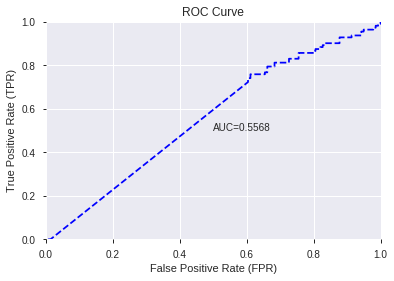

This function is available for GLM models only


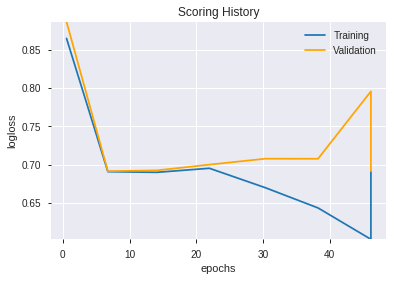

--2019-08-27 14:01:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_135346_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_135346_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroonup_20',
 'dayofweek',
 'weekday_name',
 'SIN',
 'STOCHRSI_fastk',
 'day',
 'COS',
 'aroonup_12',
 'aroondown_14',
 'BETA_8',
 'STOCHF_fastk',
 'dayofyear',
 'days_in_month',
 'aroondown_12',
 'weekday',
 'DX_14',
 'CDLCLOSINGMARUBOZU',
 'aroondown_20',
 'aroondown_8',
 'STOCHRSI_fastd',
 'HT_TRENDMODE',
 'HT_DCPERIOD',
 'CDLSPINNINGTOP',
 'BETA_14',
 'CDLLONGLEGGEDDOJI',
 'quarter',
 'CDLHIGHWAVE',
 'TANH',
 'weekofyear',
 'CORREL_12',
 'week',
 'SAREXT',
 'CDLDOJI',
 'HT_PHASOR_quadrature',
 'AROONOSC_14',
 'CDLRISEFALL3METHODS',
 'month',
 'DIV',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'BETA_12',
 'CDLUNIQUE3RIVER',
 'CDLINNECK',
 'CDLADVANCEBLOCK',
 'CDLPIERCING',
 'CDL2CROWS',
 'CORREL_24',
 'CDLUPSIDEGAP2CROWS']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_140146_model_1  0.51047  0.700904              0.496403  0.50386  0.253874

variable  relative_importance  scaled_importance  percentage
0             aroonup_20             0.013249           1.000000    0.050134
1          days_in_month             0.012695           0.958171    0.048037
2         CDLSPINNINGTOP             0.012360           0.932909    0.046771
3         STOCHRSI_fastd             0.012051           0.909545    0.045599
4      CDL3WHITESOLDIERS             0.011486           0.866893    0.043461
5       CDLSTICKSANDWICH             0.011219           0.846763    0.042452
6              CORREL_24             0.010541           0.795614    0.039888
7         CDLRICKSHAWMAN             0.010080           0.760777    0.038141
8           weekday_name             0.010039           0.757726    0.037988
9              CDLINNECK             0.009368           0.707033    0.035447
10                   SIN             0.007911           0.597090    0.029935
11                   day             0.007650           0.577382    0.028947
12             CDL2CROWS             0.007587           0.572605    0.028707
13          aroondown_12             0.006977           0.526559    0.026399
14        CDL3LINESTRIKE             0.006727           0.507720    0.025454
15       CDLUNIQUE3RIVER             0.006350           0.479257    0.024027
16                  TANH             0.006147           0.463956    0.023260
17                   DIV             0.005958           0.449687    0.022545
18                BETA_8             0.005689           0.429414    0.021528
19           HT_DCPERIOD             0.005463           0.412316    0.020671
20             dayofweek             0.005114           0.385950    0.019349
21               weekday             0.005103           0.385116    0.019308
22     CDLLONGLEGGEDDOJI             0.005069           0.382557    0.019179
23               BETA_12             0.004879           0.368241    0.018461
24                SAREXT             0.004703           0.354963    0.017796
25    CDLUPSIDEGAP2CROWS             0.004654           0.351239    0.017609
26               CDLDOJI             0.004383           0.330771    0.016583
27          aroondown_20             0.004243           0.320235    0.016055
28           aroondown_8             0.004212           0.317926    0.015939
29          STOCHF_fastk             0.003892           0.293751    0.014727
30          HT_TRENDMODE             0.003710           0.280025    0.014039
31           AROONOSC_14             0.003479           0.262547    0.013163
32          aroondown_14             0.003162           0.238630    0.011964
33  HT_PHASOR_quadrature             0.003005           0.226834    0.011372
34            weekofyear             0.002883           0.217624    0.010910
35                  week             0.002862           0.216039    0.010831
36                   COS             0.002618           0.197579    0.009905
37       CDLADVANCEBLOCK             0.002194           0.165574    0.008301
38           CDLPIERCING             0.002110           0.159267    0.007985
39                 month             0.001849           0.139534    0.006995
40               BETA_14             0.001670           0.126060    0.006320
41                 DX_14             0.001546           0.116681    0.005850
42    CDLCLOSINGMARUBOZU             0.001457           0.109956    0.005513
43             CORREL_12             0.001318           0.099445    0.004986
44        STOCHRSI_fastk             0.001277           0.096380    0.004832
45             dayofyear             0.001163           0.087756    0.004400
46           CDLHIGHWAVE             0.000889           0.067104    0.003364
47               quarter             0.000594           0.044800    0.002246
48   CDLRISEFALL3METHODS             0.000507           0.038289    0.001920
49            aroonup_12             0.000187           0.014151    0.000709

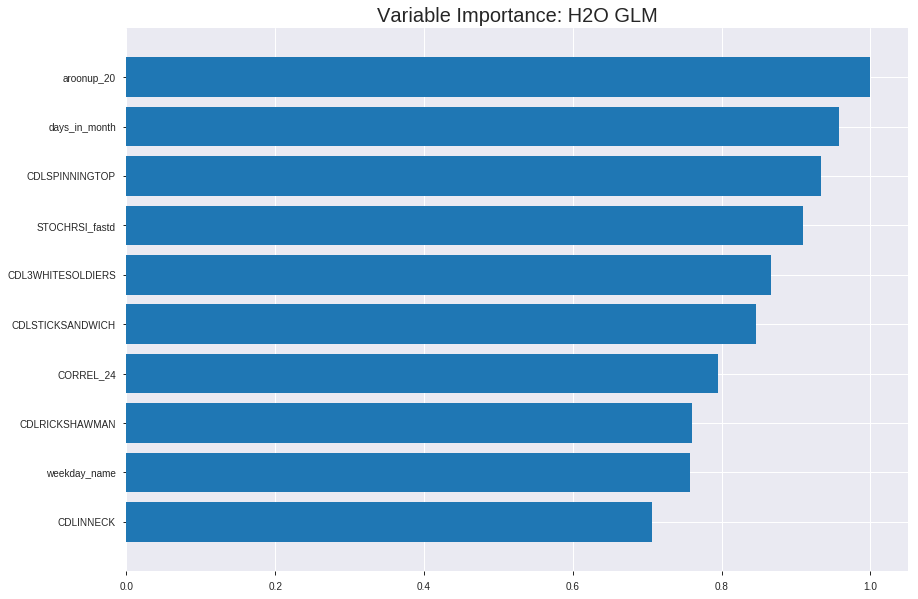

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_140146_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2472338897523654
RMSE: 0.49722619576241694
LogLoss: 0.6875882976785291
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2422.359308081908
Residual deviance: 2410.684571660923
AIC: 2512.684571660923
AUC: 0.5720094661558778
pr_auc: 0.6010692628570521
Gini: 0.14401893231175555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5160716772894809: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      75   743   0.9083   (743.0/818.0)
1      29   906   0.031    (29.0/935.0)
Total  104  1649  0.4404   (772.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516072     0.701238  351
max f2                       0.49282      0.851238  398
max f0point5                 0.516373     0.60208   349
max accuracy                 0.523202     0.561894  302
max precision                0.611303     1         0
max recall                   0.49282      1         398
max specificity              0.611303     1         0
max absolute_mcc             0.516373     0.12969   349
max min_per_class_accuracy   0.532301     0.545232  219
max mean_per_class_accuracy  0.531114     0.556189  230

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.57069            1.45823   1.45823            0.777778         0.588604  0.777778                    0.588604            0.0149733       0.0149733                  45.8229   45.8229
    2        0.0205362                   0.563521           1.14575   1.30199            0.611111         0.566939  0.694444                    0.577772            0.0117647       0.026738                   14.5752   30.199
    3        0.0302339                   0.558884           1.32344   1.30887            0.705882         0.560939  0.698113                    0.572373            0.0128342       0.0395722                  32.3435   30.8869
    4        0.040502                    0.556864           1.04159   1.24111            0.555556         0.557866  0.661972                    0.568695            0.0106952       0.0502674                  4.15924   24.1109
    5        0.0501997                   0.554655           1.32344   1.25701            0.705882         0.555657  0.670455                    0.566176            0.0128342       0.0631016                  32.3435   25.7013
    6        0.100399                    0.548413           1.25701   1.25701            0.670455         0.551211  0.670455                    0.558694            0.0631016       0.126203                   25.7013   25.7013
    7        0.150029                    0.544355           1.20681   1.24041            0.643678         0.546296  0.661597                    0.554592            0.059893        0.186096                   20.681    24.0406
    8        0.200228                    0.541712           0.980044  1.17513            0.522727         0.542947  0.626781                    0.551673            0.0491979       0.235294                   -1.99562  17.513
    9        0.300057                    0.538265           1.00707   1.11922            0.537143         0.539895  0.596958                    0.547754            0.100535        0.335829                   0.707105  11.9217
    10       0.399886                    0.535129           0.97493   1.0832             0.52             0.536616  0.577746                    0.544974            0.0973262       0.433155                   -2.50695  8.31967
    11       0.500285                    0.532336           1.09722   1.08601            0.585227         0.53374   0.579247                    0.542719            0.11016         0.543316                   9.72229   8.60115
    12       0.600114                    0.52976            1.00707   1.07288            0.537143         0.530998  0.572243                    0.54077             0.100535        0.64385                    0.707105  7.28798
    13       0.699943                    0.52723            0.932076  1.0528             0.497143         0.528532  0.561532                    0.539024            0.0930481       0.736898                   -6.79236  5.27978
    14       0.799772                    0.523728           0.985644  1.04442            0.525714         0.525562  0.557061                    0.537344            0.0983957       0.835294                   -1.4356   4.44155
    15       0.899601                    0.51893            0.953503  1.03433            0.508571         0.521455  0.55168                     0.535581            0.0951872       0.930481                   -4.64966  3.4327
    16       1                           0.46325            0.692422  1                  0.369318         0.513576  0.533371                    0.533371            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2487660572925906
RMSE: 0.4987645309087151
LogLoss: 0.690667688253621
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 692.8933692915758
Residual deviance: 692.0490236301282
AIC: 794.0490236301282
AUC: 0.5277982091461465
pr_auc: 0.566575949890824
Gini: 0.055596418292293004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4985688951758972: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    236  1        (236.0/236.0)
1      0    265  0        (0.0/265.0)
Total  0    501  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498569     0.691906  399
max f2                       0.498569     0.848815  399
max f0point5                 0.505613     0.584704  394
max accuracy                 0.530152     0.546906  222
max precision                0.592977     1         0
max recall                   0.498569     1         399
max specificity              0.592977     1         0
max absolute_mcc             0.564172     0.103898  5
max min_per_class_accuracy   0.532194     0.529661  198
max mean_per_class_accuracy  0.534599     0.549408  170

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.564172           1.89057   1.89057            1                0.573208  1                           0.573208            0.0226415       0.0226415                  89.0566   89.0566
    2        0.0219561                   0.562877           0.756226  1.37496            0.4              0.563366  0.727273                    0.568735            0.00754717      0.0301887                  -24.3774  37.4957
    3        0.0319361                   0.555997           0.756226  1.1816             0.4              0.558818  0.625                       0.565636            0.00754717      0.0377358                  -24.3774  18.1604
    4        0.0419162                   0.553349           1.13434   1.17035            0.6              0.554409  0.619048                    0.562963            0.0113208       0.0490566                  13.434    17.035
    5        0.0518962                   0.551296           1.13434   1.16343            0.6              0.55248   0.615385                    0.560947            0.0113208       0.0603774                  13.434    16.3425
    6        0.101796                    0.546549           1.05872   1.1121             0.56             0.548203  0.588235                    0.5547              0.0528302       0.113208                   5.8717    11.2098
    7        0.151697                    0.543365           1.20996   1.14429            0.64             0.544748  0.605263                    0.551426            0.0603774       0.173585                   20.9962   14.429
    8        0.201597                    0.541024           0.907472  1.08567            0.48             0.542083  0.574257                    0.549114            0.045283        0.218868                   -9.25283  8.56716
    9        0.301397                    0.537516           1.13434   1.10179            0.6              0.53958   0.582781                    0.545957            0.113208        0.332075                   13.434    10.1787
    10       0.401198                    0.535357           1.05872   1.09107            0.56             0.536563  0.577114                    0.54362             0.10566         0.437736                   5.8717    9.10729
    11       0.500998                    0.532213           0.907472  1.0545             0.48             0.533714  0.557769                    0.541647            0.090566        0.528302                   -9.25283  5.4499
    12       0.600798                    0.529344           0.983094  1.04264            0.52             0.530619  0.551495                    0.539815            0.0981132       0.626415                   -1.69057  4.26377
    13       0.700599                    0.52629            0.718415  0.996452           0.38             0.527866  0.527066                    0.538113            0.0716981       0.698113                   -28.1585  -0.354781
    14       0.800399                    0.523347           0.983094  0.994787           0.52             0.524815  0.526185                    0.536455            0.0981132       0.796226                   -1.69057  -0.521338
    15       0.9002                      0.518873           0.945283  0.989298           0.5              0.521085  0.523282                    0.534751            0.0943396       0.890566                   -5.4717   -1.07016
    16       1                           0.498569           1.09653   1                  0.58             0.51325   0.528942                    0.532605       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:01:46  0.000 sec   2            2.4       51            1.37726           1.38149
    2019-08-27 14:01:46  0.026 sec   4            1.5       51            1.37518           1.38134
    2019-08-27 14:01:46  0.051 sec   6            0.91      51            1.37247           1.3816
    2019-08-27 14:01:46  0.077 sec   8            0.56      51            1.36917           1.38261
    2019-08-27 14:01:46  0.105 sec   10           0.35      51            1.36541           1.3847
    2019-08-27 14:01:46  0.135 sec   12           0.22      51            1.36143           1.38813
    2019-08-27 14:01:46  0.161 sec   14           0.13      51            1.35751           1.393

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6187845303867404)

('auc', 0.5104701952723535)

('logloss', 0.7009043626935704)

('mean_per_class_error', 0.4450796505652621)

('rmse', 0.5038595082936238)

('mse', 0.2538744040978923)

glm prediction progress: |████████████████████████████████████████████████| 100%


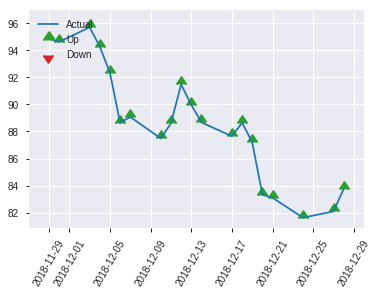


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2538744040978923
RMSE: 0.5038595082936238
LogLoss: 0.7009043626935704
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 352.68995809423006
Residual deviance: 351.85399007217234
AIC: 453.85399007217234
AUC: 0.5104701952723535
pr_auc: 0.4769989550658814
Gini: 0.020940390544706977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5048190407462021: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    138  0.9928   (138.0/139.0)
1      0    112  0        (0.0/112.0)
Total  1    250  0.5498   (138.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504819     0.618785  249
max f2                       0.504819     0.802292  249
max f0point5                 0.504819     0.503597  249
max accuracy                 0.540769     0.589641  40
max precision                0.573988     1         0
max recall                   0.504819     1         249
max specificity              0.573988     1         0
max absolute_mcc             0.540769     0.145367  40
max min_per_class_accuracy   0.53139      0.5       124
max mean_per_class_accuracy  0.539999     0.55492   42

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 53.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.565983           1.49405   1.49405            0.666667         0.570053  0.666667                    0.570053            0.0178571       0.0178571                  49.4048   49.4048
    2        0.0239044                   0.559456           1.49405   1.49405            0.666667         0.562786  0.666667                    0.56642             0.0178571       0.0357143                  49.4048   49.4048
    3        0.0318725                   0.555656           2.24107   1.6808             1                0.557569  0.75                        0.564207            0.0178571       0.0535714                  124.107   68.0804
    4        0.0438247                   0.553146           0.747024  1.42614            0.333333         0.553914  0.636364                    0.5614              0.00892857      0.0625                     -25.2976  42.6136
    5        0.0517928                   0.552383           0         1.20673            0                0.552867  0.538462                    0.560087            0               0.0625                     -100      20.6731
    6        0.103586                    0.544496           1.20673   1.20673            0.538462         0.54719   0.538462                    0.553639            0.0625          0.125                      20.6731   20.6731
    7        0.151394                    0.541265           1.49405   1.29746            0.666667         0.543174  0.578947                    0.550334            0.0714286       0.196429                   49.4048   29.7462
    8        0.203187                    0.539256           1.03434   1.23039            0.461538         0.539995  0.54902                     0.547699            0.0535714       0.25                       3.43407   23.0392
    9        0.302789                    0.536583           0.6275    1.03207            0.28             0.537728  0.460526                    0.544419            0.0625          0.3125                     -37.25    3.20724
    10       0.40239                     0.534259           0.896429  0.998497           0.4              0.535451  0.445545                    0.542199            0.0892857       0.401786                   -10.3571  -0.150283
    11       0.501992                    0.53102            0.986071  0.996032           0.44             0.532605  0.444444                    0.540295            0.0982143       0.5                        -1.39286  -0.396825
    12       0.601594                    0.527528           0.896429  0.979541           0.4              0.529135  0.437086                    0.538448            0.0892857       0.589286                   -10.3571  -2.04588
    13       0.701195                    0.524989           1.16536   1.00594            0.52             0.526364  0.448864                    0.536731            0.116071        0.705357                   16.5357   0.593547
    14       0.800797                    0.522189           0.986071  1.00346            0.44             0.523449  0.447761                    0.535079            0.0982143       0.803571                   -1.39286  0.346482
    15       0.900398                    0.516618           0.806786  0.981708           0.36             0.519101  0.438053                    0.533312            0.0803571       0.883929                   -19.3214  -1.82917
    16       1                           0.444381           1.16536   1                  0.52             0.508762  0.446215                    0.530867 

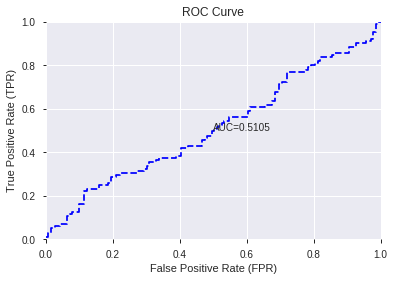

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


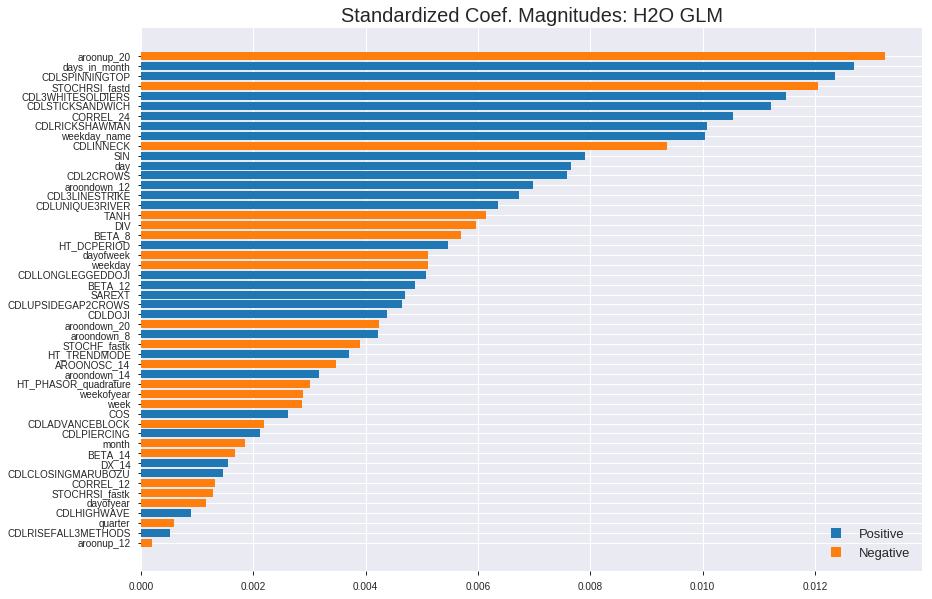

'log_likelihood'
--2019-08-27 14:01:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_140146_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_140146_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroonup_20',
 'days_in_month',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastd',
 'CDL3WHITESOLDIERS',
 'CDLSTICKSANDWICH',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'CDLINNECK',
 'SIN',
 'day',
 'CDL2CROWS',
 'aroondown_12',
 'CDL3LINESTRIKE',
 'CDLUNIQUE3RIVER',
 'TANH',
 'DIV',
 'BETA_8',
 'HT_DCPERIOD',
 'dayofweek',
 'weekday',
 'CDLLONGLEGGEDDOJI',
 'BETA_12',
 'SAREXT',
 'CDLUPSIDEGAP2CROWS',
 'CDLDOJI',
 'aroondown_20',
 'aroondown_8',
 'STOCHF_fastk',
 'HT_TRENDMODE',
 'AROONOSC_14',
 'aroondown_14',
 'HT_PHASOR_quadrature',
 'weekofyear',
 'week',
 'COS',
 'CDLADVANCEBLOCK',
 'CDLPIERCING',
 'month',
 'BETA_14',
 'DX_14',
 'CDLCLOSINGMARUBOZU',
 'CORREL_12',
 'STOCHRSI_fastk',
 'dayofyear',
 'CDLHIGHWAVE',
 'quarter',
 'CDLRISEFALL3METHODS',
 'aroonup_12']

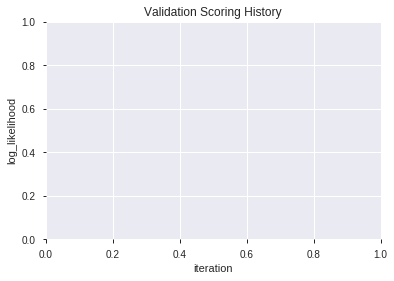

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_140201_model_1  0.518435  0.698942              0.472957  0.502698  0.252705
1  XGBoost_grid_1_AutoML_20190827_140201_model_2  0.512975  0.699306              0.496403  0.503049  0.253059
2  XGBoost_grid_1_AutoML_20190827_140201_model_5  0.499101  0.727373              0.475687  0.515602  0.265845
3               XGBoost_1_AutoML_20190827_140201  0.498073  0.710701              0.481886  0.508174  0.258241
4               XGBoost_3_AutoML_20190827_140201  0.489979  0.705426              0.483749  0.505778  0.255811
5  XGBoost_grid_1_AutoML_20190827_140201_model_6  0.484006  0.704089              0.482014  0.505408  0.255437
6               XGBoost_2_AutoML_20190827_140201  0.480858  0.707410              0.455839  0.506942  0.256990
7  XGBoost_grid_1_AutoML_20190827_140201_model_7  0.479638  0.720586              0.492806  0.512767  0.262930
8  XGBoost_grid_1_AutoML_20190827_140201_model_3  0.478225  0.710569              0.500000  0.508144  0.258211
9  XGBoost_grid_1_AutoML_20190827_140201_model_4  0.457541  0.706944              0.472090  0.506816  0.256862

variable  relative_importance  scaled_importance  percentage
0                    SIN           355.875793           1.000000    0.076124
1         STOCHRSI_fastd           279.082062           0.784212    0.059697
2                 BETA_8           276.160553           0.776003    0.059072
3            HT_DCPERIOD           265.627319           0.746405    0.056819
4                    DIV           256.076477           0.719567    0.054776
5                    COS           242.555115           0.681572    0.051884
6              dayofyear           230.685303           0.648219    0.049345
7   HT_PHASOR_quadrature           229.443848           0.644730    0.049079
8                 SAREXT           227.530304           0.639353    0.048670
9           STOCHF_fastk           224.764893           0.631582    0.048078
10                   day           223.840210           0.628984    0.047881
11                 DX_14           204.835281           0.575581    0.043815
12               BETA_12           172.688385           0.485249    0.036939
13             CORREL_24           172.596741           0.484992    0.036919
14               BETA_14           172.542892           0.484840    0.036908
15        STOCHRSI_fastk           128.440918           0.360915    0.027474
16             CORREL_12           128.028625           0.359756    0.027386
17            aroonup_20           117.267609           0.329518    0.025084
18             dayofweek           107.711121           0.302665    0.023040
19                  TANH            88.189545           0.247810    0.018864
20          aroondown_20            84.340965           0.236996    0.018041
21          weekday_name            79.152992           0.222417    0.016931
22           aroondown_8            62.664803           0.176086    0.013404
23         days_in_month            54.965900           0.154452    0.011758
24          aroondown_14            53.632637           0.150706    0.011472
25        CDLRICKSHAWMAN            51.581436           0.144942    0.011034
26                  week            39.059223           0.109755    0.008355
27           AROONOSC_14            37.606430           0.105673    0.008044
28          aroondown_12            34.351982           0.096528    0.007348
29            aroonup_12            26.991524           0.075845    0.005774
30               weekday            25.735670           0.072316    0.005505
31     CDLLONGLEGGEDDOJI             6.679871           0.018770    0.001429
32          HT_TRENDMODE             5.356476           0.015052    0.001146
33           CDLHIGHWAVE             3.840958           0.010793    0.000822
34        CDLSPINNINGTOP             2.175087           0.006112    0.000465
35            weekofyear             1.937359           0.005444    0.000414
36               quarter             0.947219           0.002662    0.000203

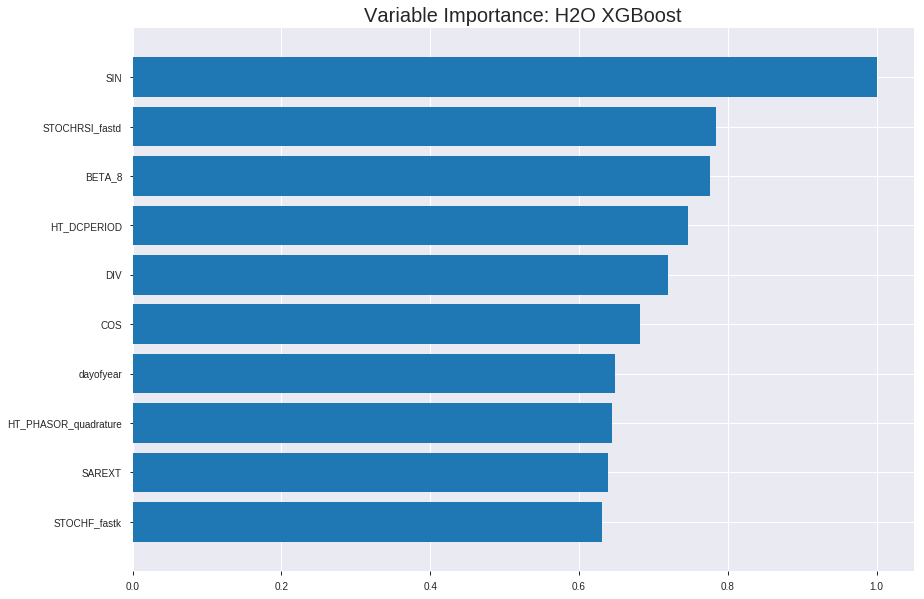

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_140201_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18580589934077324
RMSE: 0.43105208425522457
LogLoss: 0.5611298786052831
Mean Per-Class Error: 0.1522671704823294
AUC: 0.9286161630689173
pr_auc: 0.9365071245564572
Gini: 0.8572323261378345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4979629474026816: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      604  214   0.2616   (214.0/818.0)
1      64   871   0.0684   (64.0/935.0)
Total  668  1085  0.1586   (278.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497963     0.862376  235
max f2                       0.477137     0.91498   257
max f0point5                 0.558761     0.873121  171
max accuracy                 0.519881     0.849401  214
max precision                0.824331     1         0
max recall                   0.387962     1         343
max specificity              0.824331     1         0
max absolute_mcc             0.51869      0.697166  215
max min_per_class_accuracy   0.528925     0.840642  205
max mean_per_class_accuracy  0.519881     0.847733  214

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.748814           1.87487    1.87487            1                0.761741  1                           0.761741            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.729998           1.87487    1.87487            1                0.739066  1                           0.750404            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.714833           1.87487    1.87487            1                0.721134  1                           0.741015            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.705716           1.87487    1.87487            1                0.709713  1                           0.733079            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.6986             1.87487    1.87487            1                0.701806  1                           0.727038            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.663334           1.87487    1.87487            1                0.679211  1                           0.703125            0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.642557           1.83177    1.86061            0.977011         0.652645  0.992395                    0.686426            0.0909091       0.279144                   83.1766   86.0609
    8        0.200228                    0.62447            1.81095    1.84816            0.965909         0.633313  0.985755                    0.67311             0.0909091       0.370053                   81.095    84.8159
    9        0.300057                    0.589106           1.72488    1.80714            0.92             0.607567  0.963878                    0.651304            0.172193        0.542246                   72.4877   80.7143
    10       0.399886                    0.559827           1.53203    1.73846            0.817143         0.574313  0.927247                    0.632084            0.152941        0.695187                   53.2034   73.8464
    11       0.500285                    0.53477            1.24636    1.63971            0.664773         0.547105  0.874572                    0.61503             0.125134        0.820321                   24.636    63.9706
    12       0.600114                    0.502708           0.921363   1.52021            0.491429         0.518894  0.810837                    0.599038            0.0919786       0.912299                   -7.86371  52.021
    13       0.699943                    0.47234            0.567817   1.38438            0.302857         0.487617  0.738386                    0.583146            0.0566845       0.968984                   -43.2183  38.4376
    14       0.799772                    0.437739           0.224984   1.23966            0.12             0.456704  0.661198                    0.567363            0.0224599       0.991444                   -77.5016  23.9658
    15       0.899601                    0.389333           0.0642811  1.10923            0.0342857        0.414373  0.59163                     0.550386            0.00641711      0.997861                   -93.5719  10.9227
    16       1                           0.260763           0.0213053  1                  0.0113636        0.354349  0.533371                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25676187816749557
RMSE: 0.5067167632588205
LogLoss: 0.7070672382041622
Mean Per-Class Error: 0.47682283338663256
AUC: 0.4935881036136872
pr_auc: 0.5210904615997811
Gini: -0.012823792772625575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3367455005645752: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    232  0.9831   (232.0/236.0)
1      2    263  0.0075   (2.0/265.0)
Total  6    495  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.336746     0.692105   394
max f2                       0.292906     0.848815   399
max f0point5                 0.419237     0.586278   330
max accuracy                 0.419237     0.542914   330
max precision                0.677412     0.666667   5
max recall                   0.292906     1          399
max specificity              0.719506     0.995763   0
max absolute_mcc             0.537554     0.0779626  126
max min_per_class_accuracy   0.49791      0.498113   199
max mean_per_class_accuracy  0.419237     0.523177   330

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.677412           1.26038   1.26038            0.666667         0.694648  0.666667                    0.694648            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.66122            0.756226  1.03122            0.4              0.667711  0.545455                    0.682404            0.00754717      0.0226415                  -24.3774  3.12178
    3        0.0319361                   0.644585           1.13434   1.06344            0.6              0.650327  0.5625                      0.67238             0.0113208       0.0339623                  13.434    6.34434
    4        0.0419162                   0.635898           0.378113  0.90027            0.2              0.638874  0.47619                     0.664402            0.00377358      0.0377358                  -62.1887  -9.97305
    5        0.0518962                   0.629417           0.756226  0.872569           0.4              0.632289  0.461538                    0.658227            0.00754717      0.045283                   -24.3774  -12.7431
    6        0.101796                    0.597032           1.28558   1.07503            0.68             0.610751  0.568627                    0.634954            0.0641509       0.109434                   28.5585   7.50277
    7        0.151697                    0.582304           0.907472  1.01991            0.48             0.589205  0.539474                    0.619905            0.045283        0.154717                   -9.25283  1.99106
    8        0.201597                    0.569066           0.680604  0.935924           0.36             0.576097  0.49505                     0.609062            0.0339623       0.188679                   -31.9396  -6.40762
    9        0.301397                    0.540964           0.86966   0.913982           0.46             0.55499   0.483444                    0.591157            0.0867925       0.275472                   -13.034   -8.60177
    10       0.401198                    0.520273           1.05872   0.949986           0.56             0.5292    0.502488                    0.575745            0.10566         0.381132                   5.8717    -5.00141
    11       0.500998                    0.496996           1.17215   0.994242           0.62             0.509143  0.525896                    0.562478            0.116981        0.498113                   17.2151   -0.57581
    12       0.600798                    0.475518           1.02091   0.998671           0.54             0.48584   0.528239                    0.549747            0.101887        0.6                        2.09057   -0.13289
    13       0.700599                    0.454013           0.983094  0.996452           0.52             0.466037  0.527066                    0.537823            0.0981132       0.698113                   -1.69057  -0.354781
    14       0.800399                    0.430862           1.17215   1.01836            0.62             0.441638  0.538653                    0.52583             0.116981        0.815094                   17.2151   1.83598
    15       0.9002                      0.400754           0.945283  1.01026            0.5              0.416023  0.534368                    0.513656            0.0943396       0.909434                   -5.4717   1.02581
    16       1                           0.292848           0.907472  1                  0.48             0.368827  0.528942                    0.499202


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:02:05  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.471058
    2019-08-27 14:02:05  0.132 sec   5                  0.492216         0.677663            0.728646        0.746703           1.78559          0.358813                         0.499738           0.692625              0.517421          0.534218             0.315094           0.467066
    2019-08-27 14:02:05  0.205 sec   10                 0.483529         0.660571            0.794139        0.810681           1.87487          0.313177                         0.499786           0.692724              0.520915          0.547426             1.26038            0.469062
    2019-08-27 14:02:06  0.280 sec   15                 0.476083         0.64605             0.824987        0.841895           1.87487          0.276669                         0.499863           0.692893              0.525464          0.551415             0.945283           0.471058
    2019-08-27 14:02:06  0.362 sec   20                 0.468308         0.631058            0.850958        0.865698           1.87487          0.249287                         0.500611           0.694406              0.520011          0.544448             0.945283           0.469062
    2019-08-27 14:02:06  0.451 sec   25                 0.460263         0.615678            0.87025         0.883615           1.87487          0.233314                         0.502443           0.698122              0.507891          0.52966              0.945283           0.467066
    2019-08-27 14:02:06  0.527 sec   30                 0.45331          0.602504            0.886256        0.899164           1.87487          0.216771                         0.502922           0.699096              0.507707          0.528724             1.26038            0.467066
    2019-08-27 14:02:06  0.607 sec   35                 0.447347         0.591274            0.898621        0.910179           1.87487          0.184826                         0.50385            0.701007              0.502079          0.523373             0.945283           0.46507
    2019-08-27 14:02:06  0.683 sec   40                 0.442277         0.581771            0.906905        0.916735           1.87487          0.175699                         0.505025           0.703519              0.500552          0.520418             0.945283           0.469062
    2019-08-27 14:02:06  0.761 sec   45                 0.436049         0.570339            0.921471        0.929771           1.87487          0.160867                         0.505785           0.705121              0.49693           0.521947             1.26038            0.469062
    2019-08-27 14:02:06  0.837 sec   50                 0.431052         0.56113             0.928616        0.936507           1.87487          0.158585                         0.506717           0.707067              0.493588          0.52109              1.26038            0.467066

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
SIN             355.87579345703125     1.0                    0.07612375830305637
STOCHRSI_fastd  279.0820617675781      0.7842119832218224     0.05969716346913851
BETA_8          276.1605529785156      0.7760026336600483     0.05907223692727272
HT_DCPERIOD     265.6273193359375      0.7464045720997025     0.056819121242813964
DIV             256.07647705078125     0.7195669999446033     0.05477614438663836
---             ---                    ---                    ---
HT_TRENDMODE    5.356475830078125      0.01505153182250613    0.0011457791705472183
CDLHIGHWAVE     3.8409576416015625     0.010792972470225972   0.0008216016276950233
CDLSPINNINGTOP  2.1750872135162354     0.006111927963369212   0.0004652629270492095
weekofyear      1.9373588562011719     0.005443918613798862   0.0004144115447783343
quarter         0.9472188949584961     0.0026616558708786246  0.00020261524820067546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6267806267806266)

('auc', 0.5184352517985612)

('logloss', 0.6989421733619923)

('mean_per_class_error', 0.4634827852004111)

('rmse', 0.5026975948598156)

('mse', 0.2527048718778433)

xgboost prediction progress: |████████████████████████████████████████████| 100%


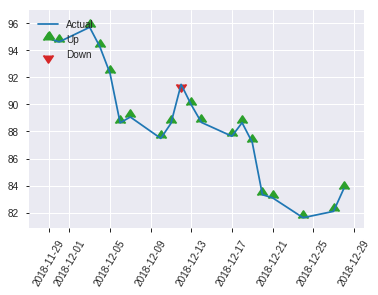


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2527048718778433
RMSE: 0.5026975948598156
LogLoss: 0.6989421733619923
Mean Per-Class Error: 0.4634827852004111
AUC: 0.5184352517985612
pr_auc: 0.460191850740666
Gini: 0.036870503597122406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3519483208656311: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   129  0.9281   (129.0/139.0)
1      2    110  0.0179   (2.0/112.0)
Total  12   239  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351948     0.626781  238
max f2                       0.341799     0.802023  243
max f0point5                 0.351948     0.514981  238
max accuracy                 0.618951     0.565737  10
max precision                0.753047     1         0
max recall                   0.275977     1         250
max specificity              0.753047     1         0
max absolute_mcc             0.351948     0.12601   238
max min_per_class_accuracy   0.482173     0.52518   124
max mean_per_class_accuracy  0.472967     0.536517  139

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 48.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.718425           1.49405   1.49405            0.666667         0.746611  0.666667                    0.746611            0.0178571       0.0178571                  49.4048   49.4048
    2        0.0239044                   0.641576           0.747024  1.12054            0.333333         0.663568  0.5                         0.705089            0.00892857      0.0267857                  -25.2976  12.0536
    3        0.0318725                   0.629809           1.12054   1.12054            0.5              0.633647  0.5                         0.687229            0.00892857      0.0357143                  12.0536   12.0536
    4        0.0438247                   0.618951           2.24107   1.42614            1                0.62303   0.636364                    0.66972             0.0267857       0.0625                     124.107   42.6136
    5        0.0517928                   0.613247           0         1.20673            0                0.616206  0.538462                    0.661487            0               0.0625                     -100      20.6731
    6        0.103586                    0.581218           0.861951  1.03434            0.384615         0.59602   0.461538                    0.628754            0.0446429       0.107143                   -13.8049  3.43407
    7        0.151394                    0.561897           0.93378   1.00258            0.416667         0.567796  0.447368                    0.609504            0.0446429       0.151786                   -6.62202  0.258459
    8        0.203187                    0.547022           1.37912   1.09856            0.615385         0.552305  0.490196                    0.594924            0.0714286       0.223214                   37.9121   9.85644
    9        0.302789                    0.526722           1.07571   1.09105            0.48             0.536001  0.486842                    0.575541            0.107143        0.330357                   7.57143   9.10479
    10       0.40239                     0.504342           0.896429  1.04287            0.4              0.514153  0.465347                    0.560346            0.0892857       0.419643                   -10.3571  4.28748
    11       0.501992                    0.481976           1.07571   1.04939            0.48             0.492962  0.468254                    0.546976            0.107143        0.526786                   7.57143   4.93906
    12       0.601594                    0.466862           1.07571   1.05375            0.48             0.474094  0.470199                    0.53491             0.107143        0.633929                   7.57143   5.37488
    13       0.701195                    0.440973           0.537857  0.980469           0.24             0.45569   0.4375                      0.523657            0.0535714       0.6875                     -46.2143  -1.95312
    14       0.800797                    0.413533           1.07571   0.992315           0.48             0.428279  0.442786                    0.511794            0.107143        0.794643                   7.57143   -0.768479
    15       0.900398                    0.384086           0.986071  0.991625           0.44             0.396171  0.442478                    0.499004            0.0982143       0.892857                   -1.39286  -0.837547
    16       1                           0.275977           1.07571   1                  0.48             0.348961  0.446215                    0.484059   

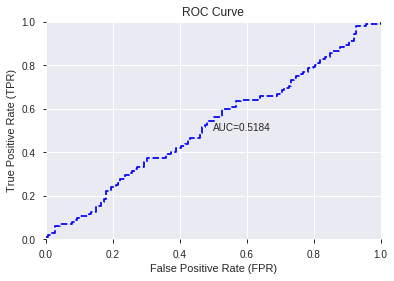

This function is available for GLM models only


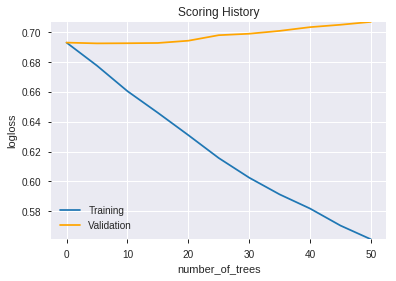

--2019-08-27 14:02:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_140201_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_140201_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'STOCHRSI_fastd',
 'BETA_8',
 'HT_DCPERIOD',
 'DIV',
 'COS',
 'dayofyear',
 'HT_PHASOR_quadrature',
 'SAREXT',
 'STOCHF_fastk',
 'day',
 'DX_14',
 'BETA_12',
 'CORREL_24',
 'BETA_14',
 'STOCHRSI_fastk',
 'CORREL_12',
 'aroonup_20',
 'dayofweek',
 'TANH',
 'aroondown_20',
 'weekday_name',
 'aroondown_8',
 'days_in_month',
 'aroondown_14',
 'CDLRICKSHAWMAN',
 'week',
 'AROONOSC_14',
 'aroondown_12',
 'aroonup_12',
 'weekday',
 'CDLLONGLEGGEDDOJI',
 'HT_TRENDMODE',
 'CDLHIGHWAVE',
 'CDLSPINNINGTOP',
 'weekofyear',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_140231_model_9  0.5   0.703232                   0.5  0.505008  0.255033
1  DeepLearning_grid_1_AutoML_20190827_140231_model_1  0.5  15.411725                   0.5  0.667993  0.446215
2  DeepLearning_grid_1_AutoML_20190827_140231_model_2  0.5  19.127051                   0.5  0.744167  0.553785
3  DeepLearning_grid_1_AutoML_20190827_140231_model_8  0.5   0.701254                   0.5  0.504032  0.254048
4  DeepLearning_grid_1_AutoML_20190827_140231_model_3  0.5  15.411725                   0.5  0.667993  0.446215
5  DeepLearning_grid_1_AutoML_20190827_140231_model_4  0.5  19.127051                   0.5  0.744167  0.553785
6               DeepLearning_1_AutoML_20190827_140231  0.5  19.127051                   0.5  0.744167  0.553785
7  DeepLearning_grid_1_AutoML_20190827_140231_model_5  0.5   0.700207                   0.5  0.503514  0.253526
8  DeepLearning_grid_1_AutoML_20190827_140231_model_6  0.5   0.697159                   0.5  0.502001  0.252005
9  DeepLearning_grid_1_AutoML_20190827_140231_model_7  0.5  19.127051                   0.5  0.744167  0.553785

variable  relative_importance  scaled_importance  percentage
0             aroondown_8             1.000000           1.000000    0.001260
1              AROONOSC_8             0.993391           0.993391    0.001251
2          STOCHRSI_fastk             0.975773           0.975773    0.001229
3                  SAREXT             0.971304           0.971304    0.001223
4                   CCI_8             0.965327           0.965327    0.001216
...                   ...                  ...                ...         ...
1039       CDLHARAMICROSS             0.641880           0.641880    0.000809
1040           CDL3INSIDE             0.636675           0.636675    0.000802
1041        CDLHIKKAKEMOD             0.632655           0.632655    0.000797
1042     CDLCOUNTERATTACK             0.628206           0.628206    0.000791
1043  CDLXSIDEGAP3METHODS             0.620100           0.620100    0.000781

[1044 rows x 4 columns]

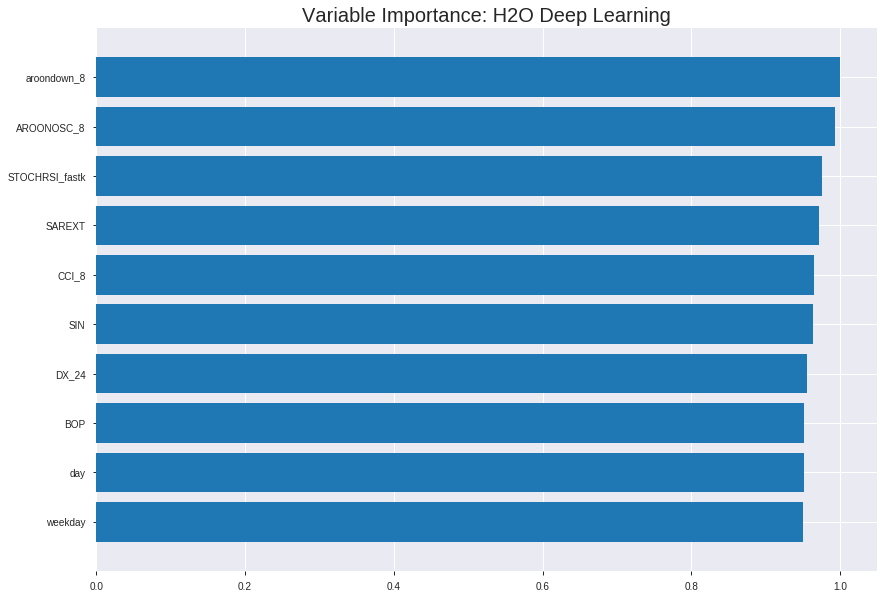

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_140231_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24888984946138415
RMSE: 0.4988886142831726
LogLoss: 0.6909252566110059
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5352414850385852: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    818   1        (818.0/818.0)
1      0    935   0        (0.0/935.0)
Total  0    1753  0.4666   (818.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535241     0.695685  0
max f2                       0.535241     0.851083  0
max f0point5                 0.535241     0.588272  0
max accuracy                 0.535241     0.533371  0
max precision                0.535241     0.533371  0
max recall                   0.535241     1         0
max specificity              0.535241     0         0
max absolute_mcc             0.535241     0         0
max min_per_class_accuracy   0.535241     0         0
max mean_per_class_accuracy  0.535241     0.5       0

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.52 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.535241           1       1                  0.533371         0.535241  0.533371                    0.535241            1               1                          0       0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24920203598804583
RMSE: 0.499201398223248
LogLoss: 0.6915506666875177
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5352414850385852: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    236  1        (236.0/236.0)
1      0    265  0        (0.0/265.0)
Total  0    501  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535241     0.691906  0
max f2                       0.535241     0.848815  0
max f0point5                 0.535241     0.583958  0
max accuracy                 0.535241     0.528942  0
max precision                0.535241     0.528942  0
max recall                   0.535241     1         0
max specificity              0.535241     0         0
max absolute_mcc             0.535241     0         0
max min_per_class_accuracy   0.535241     0         0
max mean_per_class_accuracy  0.535241     0.5       0

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 53.52 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.535241           1       1                  0.528942         0.535241  0.528942                    0.535241            1               1                          0       0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:23:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:23:39  6 min 18.474 sec  271 obs/sec       0.229321  1             402        0.579185         0.96661             -0.347827      0.502884        0.530179           1.14575          0.466629                         0.670686           6.35599               -0.805328        0.456236          0.371895             0.902957           0.471058
    2019-08-27 14:24:08  6 min 47.475 sec  383 obs/sec       6.04792   25            10602      0.498813         0.690776            0.00028743     0.522818        0.552587           1.04159          0.465488                         0.527562           2.3866                -0.117031        0.531388          0.572469             1.57547            0.471058
    2019-08-27 14:24:36  7 min 15.616 sec  421 obs/sec       12.7616   53            22371      0.500259         0.693703            -0.00551445    0.482841        0.509198           0.833274         0.466629                         0.500539           0.694259              -0.00552627      0.539471          0.562745             1.26038            0.471058
    2019-08-27 14:25:04  7 min 43.953 sec  473 obs/sec       21.243    88            37239      0.501537         0.696327            -0.0106591     0.494565        0.0539356          0.994875         0.466629                         0.502283           0.69784               -0.0125466       0.5               0                    1                  0.471058
    2019-08-27 14:25:32  8 min 11.852 sec  557 obs/sec       32.9715   137           57799      0.501178         0.695586            -0.00921205    0.5             0                  1                0.466629                         0.501895           0.697038              -0.010983        0.5               0                    1                  0.471058
    2019-08-27 14:26:01  8 min 40.719 sec  636 obs/sec       47.0884   196           82546      0.499735         0.692635            -0.00341045    0.50107         0.766115           1                0.466629                         0.50029            0.693751              -0.00452564      0.5               0                    1                  0.471058
    2019-08-27 14:26:29  9 min  8.870 sec  702 obs/sec       62.1244   259           108904     0.498889         0.690925            -1.4052e-05    0.5             0                  1                0.466629                         0.499201           0.691551              -0.000159262     0.5               0                    1                  0.471058
    2019-08-27 14:26:58  9 min 37.314 sec  774 obs/sec       79.7992   333           139888     0.499049         0.691246            -0.000656195   0.5             0                  1                0.466629                         0.499231           0.691611              -0.000279851     0.5               0                    1                  0.471058
    2019-08-27 14:27:01

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ---------------------
aroondown_8          1.0                    1.0                  0.001259605058925474
AROONOSC_8           0.9933914542198181     0.9933914542198181   0.0012512809012286165
STOCHRSI_fastk       0.9757732152938843     0.9757732152938843   0.0012290888783481524
SAREXT               0.9713042378425598     0.9713042378425598   0.0012234597317422402
CCI_8                0.9653271436691284     0.9653271436691284   0.0012159309536837121
---                  ---                    ---                  ---
CDLHARAMICROSS       0.6418800354003906     0.6418800354003906   0.0008085153398135945
CDL3INSIDE           0.6366753578186035     0.6366753578186035   0.0008019595016014995
CDLHIKKAKEMOD        0.6326553225517273     0.6326553225517273   0.0007968958448422833
CDLCOUNTERATTACK     0.6282061338424683     0.6282061338424683   0.0007912916242359865
CDLXSIDEGAP3METHODS  0.6200999617576599     0.6200999617576599   0.0007810810488694415


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.44621513944223107)

('F1', 0.6170798898071626)

('auc', 0.5)

('logloss', 0.7032317216127988)

('mean_per_class_error', 0.5)

('rmse', 0.5050078009150183)

('mse', 0.25503287898502275)

deeplearning prediction progress: |███████████████████████████████████████| 100%


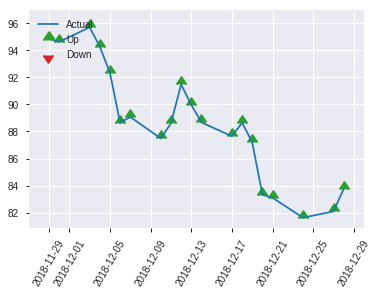


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25503287898502275
RMSE: 0.5050078009150183
LogLoss: 0.7032317216127988
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5352414850385852: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535241     0.61708   0
max f2                       0.535241     0.801144  0
max f0point5                 0.535241     0.501792  0
max accuracy                 0.535241     0.446215  0
max precision                0.535241     0.446215  0
max recall                   0.535241     1         0
max specificity              0.535241     0         0
max absolute_mcc             0.535241     0         0
max min_per_class_accuracy   0.535241     0         0
max mean_per_class_accuracy  0.535241     0.5       0

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 53.52 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.535241           1       1                  0.446215         0.535241  0.446215                    0.535241            1               1                          0       0

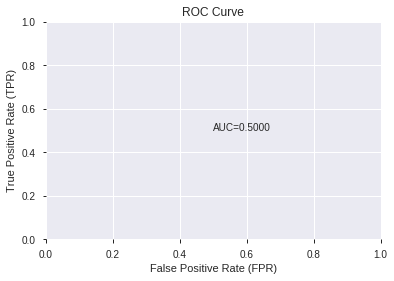

This function is available for GLM models only


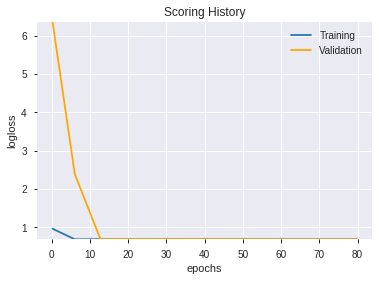

--2019-08-27 14:27:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_140231_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_140231_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroondown_8',
 'AROONOSC_8',
 'STOCHRSI_fastk',
 'SAREXT',
 'CCI_8',
 'SIN',
 'DX_24',
 'BOP',
 'day',
 'weekday',
 'aroonup_8',
 'ADX_24',
 'HT_DCPERIOD',
 'WILLR_8',
 'PLUS_DI_20',
 'BETA_12',
 'weekofyear',
 'STOCH_slowk',
 'weekday_name',
 'WILLR_24',
 'MFI_8',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'aroonup_30',
 'MACD_hist',
 'NATR_8',
 'AROONOSC_12',
 'aroonup_14',
 'month',
 'PLUS_DI_30',
 'BETA_30',
 'ROCR_20',
 'ADXR_12',
 'DX_12',
 'aroondown_12',
 'WILLR_12',
 'STOCH_slowd',
 'MACDFIX_signal_20',
 'aroondown_20',
 'CCI_12',
 'PLUS_DI_14',
 'ROCR_8',
 'PLUS_DI_8',
 'WILLR_14',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_8',
 'ADX_8',
 'ROCR100_14',
 'CORREL_8',
 'ADXR_14',
 'DIV',
 'CORREL_14',
 'MINUS_DI_8',
 'ROCR100_20',
 'NATR_12',
 'CCI_14',
 'aroonup_12',
 'ADXR_8',
 'ROC_24',
 'days_in_month',
 'AROONOSC_14',
 'BETA_20',
 'MFI_14',
 'ROCR_12',
 'CORREL_12',
 'AROONOSC_24',
 'ROCP_20',
 'DX_8',
 'quarter',
 'aroonup_20',
 'MOM_8',
 'week',
 'ADX_14',
 'MACDEX

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_142720_model_1  0.5  15.411725                   0.5  0.667993  0.446215

variable  relative_importance  scaled_importance    percentage
0                    CDLHARAMI         8.724186e-03           1.000000  1.482296e-02
1               is_month_start         6.504674e-03           0.745591  1.105187e-02
2               CDLSPINNINGTOP         5.738238e-03           0.657739  9.749643e-03
3                days_in_month         5.600028e-03           0.641897  9.514814e-03
4            HT_PHASOR_inphase         5.506864e-03           0.631218  9.356523e-03
...                        ...                  ...                ...           ...
1039  BBANDS_middleband_24_3_3         1.278180e-06           0.000147  2.171712e-06
1040  BBANDS_middleband_20_3_3         1.124396e-06           0.000129  1.910423e-06
1041  BBANDS_middleband_24_3_2         5.305351e-07           0.000061  9.014139e-07
1042             MINMAX_max_14         4.942760e-07           0.000057  8.398074e-07
1043  BBANDS_middleband_30_1_4         1.769807e-07           0.000020  3.007019e-07

[1044 rows x 4 columns]

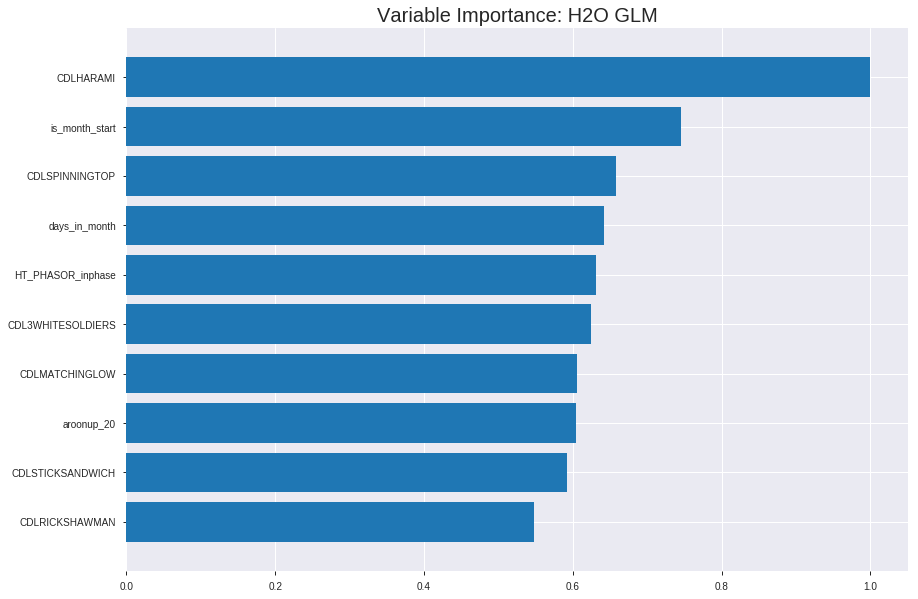

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142720_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24623409725226394
RMSE: 0.4962198073961417
LogLoss: 0.6855838933774423
Null degrees of freedom: 1752
Residual degrees of freedom: 708
Null deviance: 2422.359308081908
Residual deviance: 2403.657130181313
AIC: 4493.657130181313
AUC: 0.5859929657570964
pr_auc: 0.6008480851527878
Gini: 0.17198593151419272
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4783352290915797: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   806   0.9853   (806.0/818.0)
1      2    933   0.0021   (2.0/935.0)
Total  14   1739  0.4609   (808.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478335     0.697831  387
max f2                       0.478335     0.851433  387
max f0point5                 0.515989     0.604733  280
max accuracy                 0.524741     0.572162  243
max precision                0.618973     1         0
max recall                   0.442026     1         397
max specificity              0.618973     1         0
max absolute_mcc             0.53804      0.138466  174
max min_per_class_accuracy   0.534347     0.567237  194
max mean_per_class_accuracy  0.53804      0.568804  174

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.582355           0.937433  0.937433           0.5              0.592221  0.5                         0.592221            0.00962567      0.00962567                 -6.25668  -6.25668
    2        0.0205362                   0.574699           1.04159   0.989513           0.555556         0.57802   0.527778                    0.58512             0.0106952       0.0203209                  4.15924   -1.04872
    3        0.0302339                   0.571275           1.65429   1.20274            0.882353         0.572919  0.641509                    0.581206            0.0160428       0.0363636                  65.4294   20.2744
    4        0.040502                    0.569056           1.14575   1.1883             0.611111         0.570089  0.633803                    0.578388            0.0117647       0.0481283                  14.5752   18.8296
    5        0.0501997                   0.567559           1.21315   1.1931             0.647059         0.568327  0.636364                    0.576444            0.0117647       0.059893                   21.3149   19.3097
    6        0.100399                    0.559945           1.27832   1.23571            0.681818         0.563256  0.659091                    0.56985             0.0641711       0.124064                   27.8318   23.5707
    7        0.150029                    0.554595           1.24991   1.24041            0.666667         0.557322  0.661597                    0.565706            0.0620321       0.186096                   24.9911   24.0406
    8        0.200228                    0.551048           1.06526   1.1965             0.568182         0.552648  0.638177                    0.562432            0.0534759       0.239572                   6.52649   19.6496
    9        0.300057                    0.545141           1.08207   1.15843            0.577143         0.547803  0.617871                    0.557565            0.108021        0.347594                   8.20657   15.8425
    10       0.399886                    0.539763           1.11421   1.14739            0.594286         0.542417  0.611983                    0.553783            0.11123         0.458824                   11.4206   14.7386
    11       0.500285                    0.534479           1.03331   1.12449            0.551136         0.537175  0.599772                    0.55045             0.103743        0.562567                   3.3307    12.4492
    12       0.600114                    0.528781           0.94279   1.09427            0.502857         0.531762  0.58365                     0.547341            0.0941176       0.656684                   -5.72101  9.42661
    13       0.699943                    0.523038           0.94279   1.07266            0.502857         0.525941  0.572127                    0.544289            0.0941176       0.750802                   -5.72101  7.26619
    14       0.799772                    0.514988           0.932076  1.05511            0.497143         0.519446  0.562767                    0.541188            0.0930481       0.84385                    -6.79236  5.51138
    15       0.899601                    0.50559            0.728519  1.01887            0.388571         0.510773  0.543437                    0.537813            0.0727273       0.916578                   -27.1481  1.88715
    16       1                           0.416849           0.830907  1                  0.443182         0.493572  0.533371                    0.533371       



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.35216270658023785
RMSE: 0.5934329840683258
LogLoss: 5.4192343995706205
Null degrees of freedom: 500
Residual degrees of freedom: -544
Null deviance: 692.8933692915758
Residual deviance: 58216.807277513384
AIC: 60306.807277513384
AUC: 0.536728493763991
pr_auc: 0.5612238947340722
Gini: 0.07345698752798202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.3836175364627794e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    236  1        (236.0/236.0)
1      0    265  0        (0.0/265.0)
Total  0    501  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.38362e-48  0.691906   394
max f2                       2.38362e-48  0.848815   394
max f0point5                 1.81602e-42  0.590637   392
max accuracy                 4.9354e-42   0.552894   390
max precision                0.538709     0.833333   5
max recall                   2.38362e-48  1          394
max specificity              0.549877     0.995763   0
max absolute_mcc             0.514538     0.0903239  117
max min_per_class_accuracy   0.496252     0.495763   250
max mean_per_class_accuracy  0.00029852   0.540462   341

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 29.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.538709           1.57547   1.57547            0.833333         0.542482     0.833333                    0.542482            0.0188679       0.0188679                  57.5472   57.5472
    2        0.0219561                   0.537523           0.756226  1.20309            0.4              0.538006     0.636364                    0.540447            0.00754717      0.0264151                  -24.3774  20.3087
    3        0.0319361                   0.533308           1.13434   1.1816             0.6              0.534243     0.625                       0.538509            0.0113208       0.0377358                  13.434    18.1604
    4        0.0419162                   0.530564           0.756226  1.08032            0.4              0.531551     0.571429                    0.536852            0.00754717      0.045283                   -24.3774  8.03235
    5        0.0518962                   0.529703           1.13434   1.09071            0.6              0.529987     0.576923                    0.535532            0.0113208       0.0566038                  13.434    9.07112
    6        0.101796                    0.526239           1.28558   1.18624            0.68             0.527925     0.627451                    0.531803            0.0641509       0.120755                   28.5585   18.6238
    7        0.151697                    0.520237           1.05872   1.14429            0.56             0.523777     0.605263                    0.529163            0.0528302       0.173585                   5.8717    14.429
    8        0.201597                    0.516859           1.05872   1.12311            0.56             0.518312     0.594059                    0.526477            0.0528302       0.226415                   5.8717    12.3109
    9        0.301397                    0.509475           0.907472  1.05171            0.48             0.513209     0.556291                    0.522084            0.090566        0.316981                   -9.25283  5.17056
    10       0.401198                    0.503917           0.86966   1.00642            0.46             0.506655     0.532338                    0.518246            0.0867925       0.403774                   -13.034   0.642073
    11       0.500998                    0.496252           0.945283  0.994242           0.5              0.500476     0.525896                    0.514706            0.0943396       0.498113                   -5.4717   -0.57581
    12       0.600798                    0.133433           1.28558   1.04264            0.68             0.392109     0.551495                    0.494341            0.128302        0.626415                   28.5585   4.26377
    13       0.700599                    1.84423e-06        1.05872   1.04493            0.56             0.0192846    0.552707                    0.426669            0.10566         0.732075                   5.8717    4.49282
    14       0.800399                    1.72245e-60        1.02091   1.04193            0.54             3.27357e-08  0.551122                    0.373469            0.101887        0.833962                   2.09057   4.19329
    15       1                           0                  0.831849  1                  0.44             9.89353e-64  0.528942                    0.298924            0.166038        1                          -16.8151  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:27:24  0.000 sec   2            3.4       1045          1.37117           116.201
    2019-08-27 14:27:27  2.289 sec   4            2.5       1045          1.36851           121.119
    2019-08-27 14:27:29  4.604 sec   6            1.8       1045          1.36535           126.686
    2019-08-27 14:27:31  6.875 sec   8            1.3       1045          1.36168           132.714
    2019-08-27 14:27:33  9.193 sec   10           0.97      1045          1.3575            138.827

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.44621513944223107)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6170798898071626)

('auc', 0.5)

('logloss', 15.4117249252191)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.6679933678130577)

('mse', 0.44621513944223107)

glm prediction progress: |████████████████████████████████████████████████| 100%


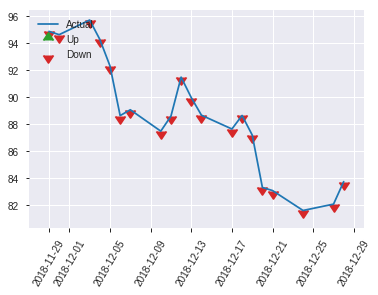


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.44621513944223107
RMSE: 0.6679933678130577
LogLoss: 15.4117249252191
Null degrees of freedom: 250
Residual degrees of freedom: -794
Null deviance: 352.68995809423006
Residual deviance: 158680.79775122716
AIC: 160770.79775122716
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.61708   0
max f2                       0            0.801144  0
max f0point5                 0            0.501792  0
max accuracy                 0            0.446215  0
max precision                0            0.446215  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 44.62 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.446215         0        0.446215                    0                   1               1                          0       0

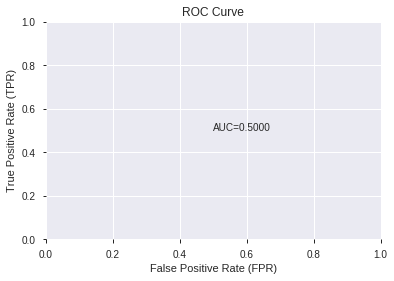

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


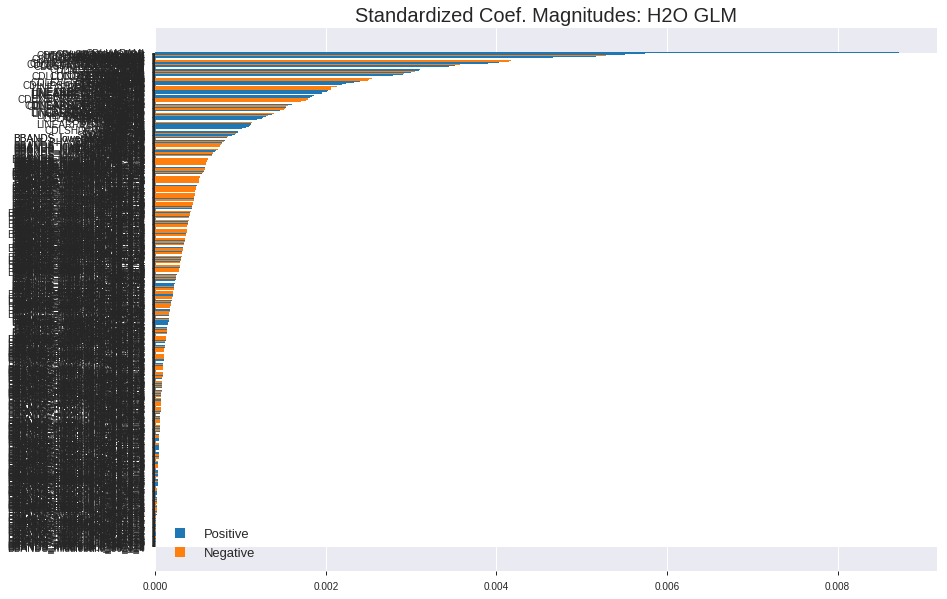

'log_likelihood'
--2019-08-27 14:28:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142720_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142720_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLHARAMI',
 'is_month_start',
 'CDLSPINNINGTOP',
 'days_in_month',
 'HT_PHASOR_inphase',
 'CDL3WHITESOLDIERS',
 'CDLMATCHINGLOW',
 'aroonup_20',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'is_quarter_start',
 'CDLSEPARATINGLINES',
 'STOCHRSI_fastd',
 'CDLINNECK',
 'CORREL_24',
 'SINH',
 'EXP',
 'COSH',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLONNECK',
 'CDLLONGLINE',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLSTALLEDPATTERN',
 'CDL2CROWS',
 'VAR_24',
 'day',
 'DIV',
 'BOP',
 'CCI_8',
 'CDLMORNINGSTAR',
 'Volume',
 'CDL3LINESTRIKE',
 'aroondown_12',
 'SIN',
 'aroonup_8',
 'aroonup_24',
 'CORREL_30',
 'VAR_30',
 'NATR_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'STDDEV_24',
 'CDLENGULFING',
 'CDLUNIQUE3RIVER',
 'CDLLONGLEGGEDDOJI',
 'BETA_12',
 'ADOSC',
 'AROONOSC_8',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'ROC_30',
 'weekday',
 'dayofweek',
 'PLUS_DI_30',
 'CDLDOJI',
 'CDLEVENINGDOJISTAR',
 'STOCH_slowd',
 'CDLHIKKAKE',
 'SAREXT',
 'HT

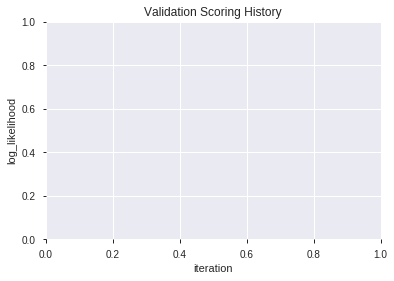

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_142811  0.542523  0.687959              0.496403  0.497164  0.247172
1  XGBoost_grid_1_AutoML_20190827_142811_model_5  0.537834  0.705104              0.481019  0.504506  0.254527
2               XGBoost_2_AutoML_20190827_142811  0.525822  0.692320              0.480152  0.499405  0.249406
3  XGBoost_grid_1_AutoML_20190827_142811_model_3  0.521326  0.704861              0.492806  0.504701  0.254723
4  XGBoost_grid_1_AutoML_20190827_142811_model_1  0.508800  0.703791              0.485483  0.504344  0.254363
5  XGBoost_grid_1_AutoML_20190827_142811_model_7  0.498651  0.713436              0.476554  0.508871  0.258950
6  XGBoost_grid_1_AutoML_20190827_142811_model_6  0.496146  0.724542              0.500000  0.513077  0.263248
7               XGBoost_1_AutoML_20190827_142811  0.487860  0.704419              0.500000  0.504810  0.254833
8  XGBoost_grid_1_AutoML_20190827_142811_model_2  0.477711  0.695649              0.496403  0.501228  0.251229
9  XGBoost_grid_1_AutoML_20190827_142811_model_4  0.471994  0.698767              0.485612  0.502781  0.252789

variable  relative_importance  scaled_importance  percentage
0                    BETA_12           132.800812           1.000000    0.024850
1                     Volume           112.476646           0.846958    0.021047
2                        DIV            91.540024           0.689303    0.017129
3          HT_PHASOR_inphase            90.823273           0.683906    0.016995
4             STOCHRSI_fastd            89.086586           0.670829    0.016670
..                       ...                  ...                ...         ...
292  BBANDS_lowerband_30_1_4             1.266885           0.009540    0.000237
293  BBANDS_upperband_14_0_2             1.211161           0.009120    0.000227
294   BBANDS_lowerband_8_4_4             0.828176           0.006236    0.000155
295  BBANDS_lowerband_14_1_5             0.534309           0.004023    0.000100
296              AROONOSC_14             0.045868           0.000345    0.000009

[297 rows x 4 columns]

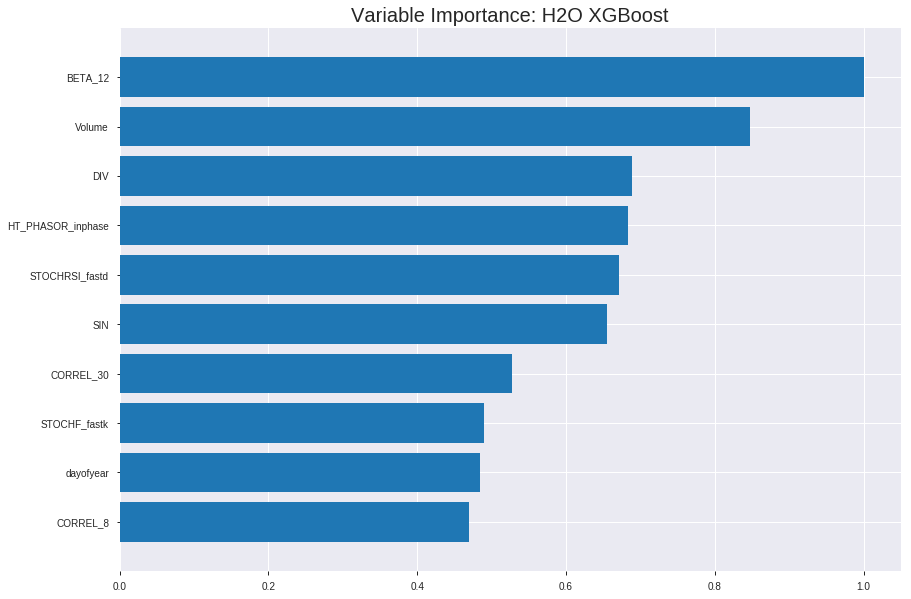

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_142811


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1786802699999249
RMSE: 0.4227058906614916
LogLoss: 0.5466956357944689
Mean Per-Class Error: 0.09542381967234548
AUC: 0.961063896552175
pr_auc: 0.9642177766342066
Gini: 0.9221277931043499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5237589478492737: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      733  85   0.1039   (85.0/818.0)
1      82   853  0.0877   (82.0/935.0)
Total  815  938  0.0953   (167.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523759     0.910838  196
max f2                       0.480672     0.930873  240
max f0point5                 0.539448     0.917254  180
max accuracy                 0.52583      0.904735  194
max precision                0.770161     1         0
max recall                   0.397293     1         323
max specificity              0.770161     1         0
max absolute_mcc             0.52583      0.808745  194
max min_per_class_accuracy   0.52583      0.9022    194
max mean_per_class_accuracy  0.52583      0.904576  194

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.73064            1.87487    1.87487            1                0.746631  1                           0.746631            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.716031           1.87487    1.87487            1                0.724055  1                           0.735343            0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.702751           1.87487    1.87487            1                0.707306  1                           0.72635             0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.693914           1.87487    1.87487            1                0.697767  1                           0.719103            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.687213           1.87487    1.87487            1                0.691208  1                           0.713714            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.661276           1.87487    1.87487            1                0.672396  1                           0.693055            0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.644198           1.87487    1.87487            1                0.653383  1                           0.679932            0.0930481       0.281283                   87.4866   87.4866
    8        0.200228                    0.62829            1.87487    1.87487            1                0.636711  1                           0.669096            0.0941176       0.375401                   87.4866   87.4866
    9        0.300057                    0.598554           1.81059    1.85348            0.965714         0.612206  0.988593                    0.650169            0.180749        0.55615                    81.0585   85.348
    10       0.399886                    0.568734           1.62846    1.7973             0.868571         0.584459  0.958631                    0.633765            0.162567        0.718717                   62.8455   79.7304
    11       0.500285                    0.536037           1.51268    1.74018            0.806818         0.553247  0.928164                    0.617606            0.151872        0.870588                   51.2676   74.0184
    12       0.600114                    0.499218           0.76066    1.57724            0.405714         0.517346  0.841255                    0.600928            0.0759358       0.946524                   -23.934   57.724
    13       0.699943                    0.468692           0.385687   1.4073             0.205714         0.484033  0.750611                    0.584256            0.0385027       0.985027                   -61.4313  40.7296
    14       0.799772                    0.432144           0.107135   1.24501            0.0571429        0.449803  0.664051                    0.567473            0.0106952       0.995722                   -89.2865  24.5008
    15       0.899601                    0.392681           0.0428541  1.1116             0.0228571        0.413835  0.592898                    0.550424            0.00427807      1                          -95.7146  11.1604
    16       1                           0.205573           0          1                  0                0.345694  0.533371                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2617331332109999
RMSE: 0.511598605560062
LogLoss: 0.7178548997910021
Mean Per-Class Error: 0.4776383114806524
AUC: 0.5078349856092101
pr_auc: 0.5462622658304489
Gini: 0.015669971218420287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29311084747314453: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    228  0.9661   (228.0/236.0)
1      4    261  0.0151   (4.0/265.0)
Total  12   489  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293111     0.692308  388
max f2                       0.25155      0.848815  399
max f0point5                 0.293111     0.587573  388
max accuracy                 0.293111     0.536926  388
max precision                0.726912     1         0
max recall                   0.25155      1         399
max specificity              0.726912     1         0
max absolute_mcc             0.648257     0.112336  6
max min_per_class_accuracy   0.441155     0.520755  201
max mean_per_class_accuracy  0.451701     0.522362  192

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 45.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.650043           1.89057   1.89057            1                0.671908  1                           0.671908            0.0226415       0.0226415                  89.0566   89.0566
    2        0.0219561                   0.629931           0.756226  1.37496            0.4              0.635244  0.727273                    0.655242            0.00754717      0.0301887                  -24.3774  37.4957
    3        0.0319361                   0.61868            0.378113  1.06344            0.2              0.62118   0.5625                      0.644598            0.00377358      0.0339623                  -62.1887  6.34434
    4        0.0419162                   0.61322            1.13434   1.08032            0.6              0.615579  0.571429                    0.637689            0.0113208       0.045283                   13.434    8.03235
    5        0.0518962                   0.602922           0.378113  0.945283           0.2              0.606227  0.5                         0.631638            0.00377358      0.0490566                  -62.1887  -5.4717
    6        0.101796                    0.568018           0.983094  0.963818           0.52             0.588367  0.509804                    0.610427            0.0490566       0.0981132                  -1.69057  -3.6182
    7        0.151697                    0.548578           1.13434   1.01991            0.6              0.558887  0.539474                    0.593473            0.0566038       0.154717                   13.434    1.99106
    8        0.201597                    0.537192           1.13434   1.04823            0.6              0.542672  0.554455                    0.580899            0.0566038       0.211321                   13.434    4.82346
    9        0.301397                    0.505651           0.983094  1.02667            0.52             0.519934  0.543046                    0.560712            0.0981132       0.309434                   -1.69057  2.6665
    10       0.401198                    0.476151           1.05872   1.03464            0.56             0.489408  0.547264                    0.542975            0.10566         0.415094                   5.8717    3.46381
    11       0.500998                    0.441155           1.05872   1.03943            0.56             0.459437  0.549801                    0.526334            0.10566         0.520755                   5.8717    3.94347
    12       0.600798                    0.418822           0.907472  1.01751            0.48             0.429129  0.538206                    0.510187            0.090566        0.611321                   -9.25283  1.75139
    13       0.700599                    0.391194           0.945283  1.00722            0.5              0.405347  0.532764                    0.495252            0.0943396       0.70566                    -5.4717   0.722464
    14       0.800399                    0.366695           0.680604  0.966499           0.36             0.378398  0.511222                    0.480682            0.0679245       0.773585                   -31.9396  -3.35012
    15       0.9002                      0.334139           1.17215   0.989298           0.62             0.35222   0.523282                    0.46644             0.116981        0.890566                   17.2151   -1.07016
    16       1                           0.25155            1.09653   1                  0.58             0.306775  0.528942                    0.450505       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:28:24  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.471058
    2019-08-27 14:28:25  1.221 sec   5                  0.492035         0.677311            0.739155        0.764606           1.87487          0.362236                         0.501599           0.696371              0.512568          0.564875             1.26038            0.471058
    2019-08-27 14:28:26  1.460 sec   10                 0.482878         0.659339            0.816204        0.830067           1.87487          0.2664                           0.502605           0.698438              0.511041          0.546426             1.08032            0.471058
    2019-08-27 14:28:26  1.686 sec   15                 0.476543         0.646986            0.842271        0.856387           1.87487          0.24016                          0.505225           0.70385               0.498929          0.534735             1.26038            0.467066
    2019-08-27 14:28:26  1.924 sec   20                 0.467934         0.630423            0.876023        0.888853           1.87487          0.209355                         0.507348           0.708369              0.499488          0.532216             0.945283           0.471058
    2019-08-27 14:28:26  2.181 sec   25                 0.458143         0.611901            0.912264        0.922941           1.87487          0.17741                          0.509244           0.712527              0.50008           0.532868             1.26038            0.469062
    2019-08-27 14:28:27  2.425 sec   30                 0.451636         0.599667            0.92133         0.93134            1.87487          0.166001                         0.508655           0.711205              0.497354          0.539378             1.57547            0.469062
    2019-08-27 14:28:27  2.669 sec   35                 0.443482         0.58451             0.936825        0.944204           1.87487          0.134626                         0.508012           0.709993              0.511401          0.54701              1.57547            0.469062
    2019-08-27 14:28:27  2.920 sec   40                 0.435508         0.569892            0.947673        0.953453           1.87487          0.114661                         0.509945           0.714195              0.507955          0.54643              1.89057            0.471058
    2019-08-27 14:28:27  3.182 sec   45                 0.428451         0.557045            0.956311        0.960861           1.87487          0.107245                         0.511154           0.716878              0.509738          0.546234             1.89057            0.467066
    2019-08-27 14:28:28  3.450 sec   50                 0.422706         0.546696            0.961064        0.964218           1.87487          0.0952653                        0.511599           0.717855              0.507835          0.546262             1.89057            0.463074

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BETA_12                  132.80081176757812     1.0                    0.024850377787169982
Volume                   112.47664642333984     0.846957521767196      0.02104721438560006
DIV                      91.54002380371094      0.6893031946515513     0.017129444796994218
HT_PHASOR_inphase        90.82327270507812      0.6839060055147317     0.016995322607955436
STOCHRSI_fastd           89.08658599853516      0.6708286253133031     0.01667034476948348
---                      ---                    ---                    ---
BBANDS_lowerband_30_1_4  1.2668848037719727     0.009539736895503442   0.00023706606584346463
BBANDS_upperband_14_0_2  1.211160659790039      0.009120129942501833   0.0002266386745392514
BBANDS_lowerband_8_4_4   0.8281755447387695     0.006236223511857776   0.00015497251023489765
BBANDS_lowerband_14_1_5  0.5343093872070312     0.004023389466490272   9.998274822720355e-05
AROONOSC_14              0.045867919921875      0.0003453888520060474  8.58304345582722e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6187845303867404)

('auc', 0.5425231243576568)

('logloss', 0.6879590793058681)

('mean_per_class_error', 0.44228545734840696)

('rmse', 0.4971643445974995)

('mse', 0.2471723855390612)

xgboost prediction progress: |████████████████████████████████████████████| 100%


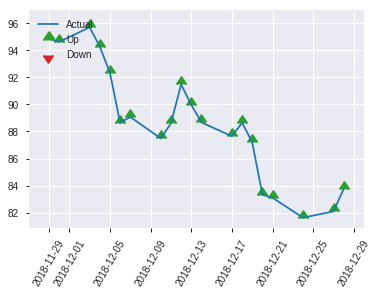


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2471723855390612
RMSE: 0.4971643445974995
LogLoss: 0.6879590793058681
Mean Per-Class Error: 0.44228545734840696
AUC: 0.5425231243576568
pr_auc: 0.503611098598035
Gini: 0.08504624871531363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2810218036174774: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    138  0.9928   (138.0/139.0)
1      0    112  0        (0.0/112.0)
Total  1    250  0.5498   (138.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281022     0.618785  249
max f2                       0.281022     0.802292  249
max f0point5                 0.3828       0.522487  160
max accuracy                 0.528961     0.573705  10
max precision                0.584741     1         0
max recall                   0.281022     1         249
max specificity              0.584741     1         0
max absolute_mcc             0.31207      0.144973  240
max min_per_class_accuracy   0.410576     0.535714  123
max mean_per_class_accuracy  0.3828       0.557715  160

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 41.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.571612           2.24107   2.24107            1                0.582742  1                           0.582742            0.0267857       0.0267857                  124.107   124.107
    2        0.0239044                   0.550261           1.49405   1.86756            0.666667         0.556119  0.833333                    0.569431            0.0178571       0.0446429                  49.4048   86.756
    3        0.0318725                   0.539376           1.12054   1.6808             0.5              0.545052  0.75                        0.563336            0.00892857      0.0535714                  12.0536   68.0804
    4        0.0438247                   0.528961           1.49405   1.62987            0.666667         0.532511  0.727273                    0.554929            0.0178571       0.0714286                  49.4048   62.987
    5        0.0517928                   0.526881           0         1.37912            0                0.52759   0.615385                    0.550723            0               0.0714286                  -100      37.9121
    6        0.103586                    0.509615           1.20673   1.29293            0.538462         0.516416  0.576923                    0.533569            0.0625          0.133929                   20.6731   29.2926
    7        0.151394                    0.488823           1.12054   1.23849            0.5              0.499892  0.552632                    0.522934            0.0535714       0.1875                     12.0536   23.8487
    8        0.203187                    0.471211           0.861951  1.14251            0.384615         0.48007   0.509804                    0.512008            0.0446429       0.232143                   -13.8049  14.2507
    9        0.302789                    0.445765           1.16536   1.15002            0.52             0.456764  0.513158                    0.493836            0.116071        0.348214                   16.5357   15.0023
    10       0.40239                     0.42502            0.717143  1.04287            0.32             0.434664  0.465347                    0.479189            0.0714286       0.419643                   -28.2857  4.28748
    11       0.501992                    0.408545           1.16536   1.06718            0.52             0.416225  0.47619                     0.466696            0.116071        0.535714                   16.5357   6.71769
    12       0.601594                    0.38902            0.986071  1.05375            0.44             0.398716  0.470199                    0.455441            0.0982143       0.633929                   -1.39286  5.37488
    13       0.701195                    0.371007           0.986071  1.04414            0.44             0.380511  0.465909                    0.444798            0.0982143       0.732143                   -1.39286  4.41356
    14       0.800797                    0.350892           0.896429  1.02576            0.4              0.362219  0.457711                    0.434527            0.0892857       0.821429                   -10.3571  2.5764
    15       0.900398                    0.329995           0.806786  1.00154            0.36             0.343117  0.446903                    0.424415            0.0803571       0.901786                   -19.3214  0.154077
    16       1                           0.27081            0.986071  1                  0.44             0.30995   0.446215                    0.413014           

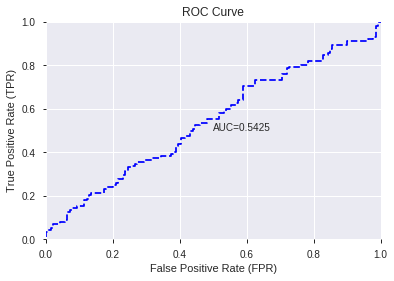

This function is available for GLM models only


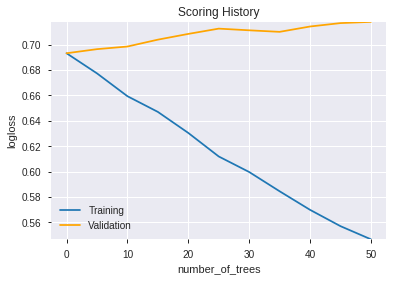

--2019-08-27 14:29:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_142811',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_142811',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_8ce1',
   'type

['BETA_12',
 'Volume',
 'DIV',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'SIN',
 'CORREL_30',
 'STOCHF_fastk',
 'dayofyear',
 'CORREL_8',
 'CCI_8',
 'PLUS_DM_8',
 'MFI_24',
 'NATR_8',
 'MACDEXT_hist',
 'TAN',
 'CORREL_14',
 'ULTOSC',
 'CORREL_12',
 'BOP',
 'ADOSC',
 'DX_8',
 'CORREL_20',
 'dayofweek',
 'BETA_8',
 'DX_12',
 'PLUS_DI_8',
 'MACDFIX_hist_24',
 'BBANDS_upperband_30_1_3',
 'ROC_8',
 'PLUS_DI_24',
 'CMO_8',
 'MFI_20',
 'NATR_20',
 'STOCH_slowk',
 'CORREL_24',
 'COS',
 'STOCH_slowd',
 'ADX_12',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_20',
 'BBANDS_lowerband_14_3_5',
 'HT_DCPERIOD',
 'PLUS_DI_30',
 'MFI_14',
 'days_in_month',
 'KAMA_30',
 'DX_30',
 'CCI_12',
 'ROC_20',
 'STDDEV_24',
 'PLUS_DI_20',
 'MOM_14',
 'CCI_14',
 'BETA_30',
 'MACDFIX_hist_12',
 'NATR_14',
 'weekday_name',
 'ROC_12',
 'PLUS_DM_24',
 'LINEARREG_ANGLE_24',
 'day',
 'LINEARREG_ANGLE_30',
 'OBV',
 'TRANGE',
 'BBANDS_lowerband_24_7_5',
 'ADXR_14',
 'ADX_20',
 'SUB',
 'DX_24',
 'ADX_8',
 'aroondown_24',
 'CCI_30',

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

681

['BBANDS_middleband_12_0_2',
 'BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_0_5',
 'MA_12_1',
 'MAVP_12_1',
 'BBANDS_upperband_12_1_2',
 'BBANDS_middleband_12_1_2',
 'BBANDS_lowerband_12_1_2',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_12_1_3',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_12_1_4',
 'BBANDS_middleband_12_1_4',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_upperband_12_1_5',
 'BBANDS_middleband_12_1_5',
 'BBANDS_lowerband_12_1_5',
 'MA_12_2',
 'MAVP_12_2',
 'BBANDS_upperband_12_2_2',
 'BBANDS_middleband_12_2_2',
 'BBANDS_lowerband_12_2_2',
 'BBANDS_upperband_12_2_3',
 'BBANDS_middleband_12_2_3',
 'BBANDS_lowerband_12_2_3',
 'BBANDS_upperband_12_2_4',
 'BBANDS_middleband_12_2_4',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_upperband_12_2_5',
 'BBANDS_midd

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_143038_model_1  0.562693  3.414748              0.472090  0.712031  0.506988
1  DeepLearning_grid_1_AutoML_20190827_143038_model_3  0.545606  0.697985              0.496403  0.501376  0.251378
2  DeepLearning_grid_1_AutoML_20190827_143038_model_9  0.536678  0.690618              0.461170  0.498735  0.248737
3  DeepLearning_grid_1_AutoML_20190827_143038_model_4  0.523767  0.785537              0.420606  0.535251  0.286494
4  DeepLearning_grid_1_AutoML_20190827_143038_model_7  0.505075  0.700898              0.500000  0.503856  0.253871
5  DeepLearning_grid_1_AutoML_20190827_143038_model_2  0.503854  0.848570              0.490076  0.551954  0.304653
6  DeepLearning_grid_1_AutoML_20190827_143038_model_8  0.500000  0.697754              0.500000  0.502297  0.252302
7  DeepLearning_grid_1_AutoML_20190827_143038_model_6  0.500000  0.699748              0.500000  0.503287  0.253298
8               DeepLearning_1_AutoML_20190827_143038  0.500000  0.690971              0.500000  0.498911  0.248912
9  DeepLearning_grid_1_AutoML_20190827_143038_model_5  0.500000  0.700020              0.500000  0.503421  0.253433

variable  relative_importance  scaled_importance  percentage
0    BBANDS_middleband_14_5_5             1.000000           1.000000    0.001589
1     BBANDS_upperband_30_2_2             0.998002           0.998002    0.001586
2              CDL3LINESTRIKE             0.991783           0.991783    0.001576
3                   MAVP_30_5             0.989357           0.989357    0.001573
4              STOCHRSI_fastk             0.988753           0.988753    0.001572
..                        ...                  ...                ...         ...
676   BBANDS_lowerband_20_1_2             0.856854           0.856854    0.001362
677  BBANDS_middleband_12_6_3             0.849744           0.849744    0.001351
678   BBANDS_upperband_12_3_3             0.841851           0.841851    0.001338
679   BBANDS_lowerband_14_7_5             0.841559           0.841559    0.001338
680                 MAVP_14_5             0.822195           0.822195    0.001307

[681 rows x 4 columns]

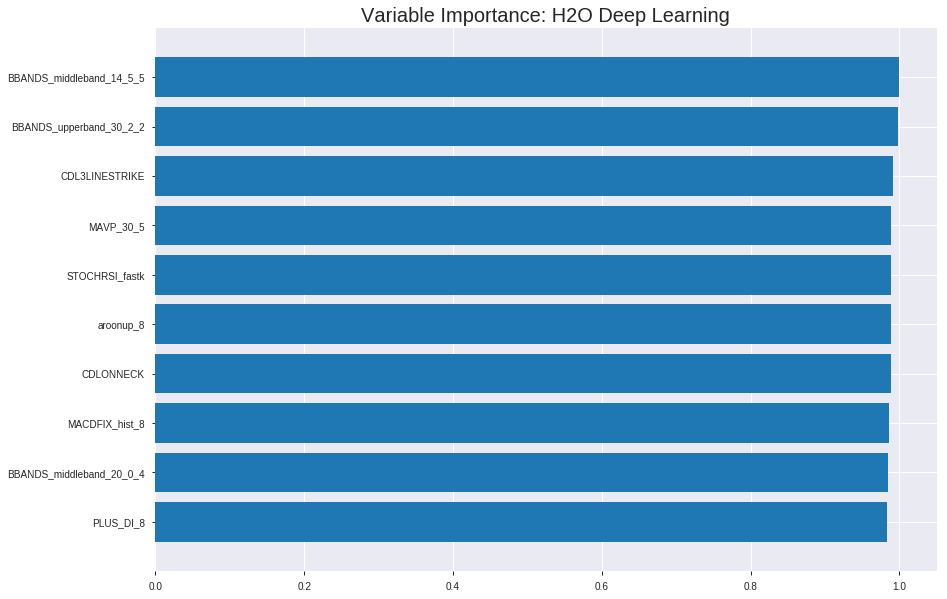

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_143038_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.39440119911700694
RMSE: 0.6280136934152049
LogLoss: 2.2512297916931847
Mean Per-Class Error: 0.4686433586548645
AUC: 0.5338264712419754
pr_auc: 0.45267474502763605
Gini: 0.0676529424839507
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.001865226012786895: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   779   0.9523   (779.0/818.0)
1      19   916   0.0203   (19.0/935.0)
Total  58   1695  0.4552   (798.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00186523   0.696578   396
max f2                       9.70085e-05  0.851083   399
max f0point5                 0.0059806    0.59516    392
max accuracy                 0.0059806    0.548203   392
max precision                0.999449     0.589744   2
max recall                   9.70085e-05  1          399
max specificity              0.999956     0.845966   0
max absolute_mcc             0.0059806    0.0840152  392
max min_per_class_accuracy   0.923695     0.526203   65
max mean_per_class_accuracy  0.821733     0.531357   113

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 69.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   1                  1.35407   1.35407            0.722222         1           0.722222                    1                   0.0139037       0.0139037                  35.407     35.407
    2        0.0205362                   1                  0.937433  1.14575            0.5              1           0.611111                    1                   0.00962567      0.0235294                  -6.25668   14.5752
    3        0.0302339                   0.999999           1.10286   1.13199            0.588235         0.999999    0.603774                    1                   0.0106952       0.0342246                  10.2863    13.1995
    4        0.040502                    0.999998           1.24991   1.16189            0.666667         0.999998    0.619718                    0.999999            0.0128342       0.0470588                  24.9911    16.1889
    5        0.0501997                   0.999995           0.772004  1.08657            0.411765         0.999997    0.579545                    0.999999            0.00748663      0.0545455                  -22.7996   8.65702
    6        0.100399                    0.999972           1.08657   1.08657            0.579545         0.999984    0.579545                    0.999992            0.0545455       0.109091                   8.65702    8.65702
    7        0.150029                    0.999871           1.05596   1.07644            0.563218         0.999934    0.574144                    0.999973            0.0524064       0.161497                   5.59592    7.64442
    8        0.200228                    0.999559           1.12918   1.08967            0.602273         0.999742    0.581197                    0.999915            0.0566845       0.218182                   12.9181    8.96659
    9        0.300057                    0.996542           0.996358  1.05862            0.531429         0.998527    0.564639                    0.999453            0.0994652       0.317647                   -0.364248  5.86222
    10       0.399886                    0.981777           0.97493   1.03773            0.52             0.990541    0.553495                    0.997228            0.0973262       0.414973                   -2.50695   3.77291
    11       0.500285                    0.923766           1.09722   1.04967            0.585227         0.957046    0.559863                    0.989164            0.11016         0.525134                   9.72229    4.96686
    12       0.600114                    0.772353           0.97493   1.03724            0.52             0.856163    0.553232                    0.967039            0.0973262       0.62246                    -2.50695   3.72359
    13       0.699943                    0.519387           1.01778   1.03446            0.542857         0.654296    0.551752                    0.922435            0.101604        0.724064                   1.77846    3.44617
    14       0.799772                    0.230346           0.857082  1.01232            0.457143         0.373914    0.539943                    0.853967            0.0855615       0.809626                   -14.2918   1.23208
    15       0.899601                    0.0355531          0.985644  1.00936            0.525714         0.112526    0.538364                    0.77169             0.0983957       0.908021                   -1.4356    0.936049
    16       1                           3.85928e-07        0.916128  1                  0.488636         0.00



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3885030712153499
RMSE: 0.6233001453676631
LogLoss: 1.5858838235501906
Mean Per-Class Error: 0.46267988487368084
AUC: 0.5164454748960665
pr_auc: 0.536343684342554
Gini: 0.03289094979213303
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.005843080410050278: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    235  0.9958   (235.0/236.0)
1      0    265  0        (0.0/265.0)
Total  1    500  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00584308   0.69281    398
max f2                       0.00584308   0.849359   398
max f0point5                 0.0424446    0.585464   390
max accuracy                 0.852614     0.542914   200
max precision                0.999993     0.75       0
max recall                   0.00584308   1          398
max specificity              0.999993     0.995763   0
max absolute_mcc             0.852614     0.0760139  200
max min_per_class_accuracy   0.924783     0.524528   156
max mean_per_class_accuracy  0.852614     0.53732    200

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 76.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.999893           1.26038   1.26038            0.666667         0.999963  0.666667                    0.999963            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.999713           0.378113  0.859348           0.2              0.999777  0.454545                    0.999879            0.00377358      0.0188679                  -62.1887  -14.0652
    3        0.0319361                   0.999588           1.89057   1.1816             1                0.999657  0.625                       0.999809            0.0188679       0.0377358                  89.0566   18.1604
    4        0.0419162                   0.999495           0.756226  1.08032            0.4              0.999544  0.571429                    0.999746            0.00754717      0.045283                   -24.3774  8.03235
    5        0.0518962                   0.999057           1.13434   1.09071            0.6              0.999242  0.576923                    0.999649            0.0113208       0.0566038                  13.434    9.07112
    6        0.101796                    0.997434           0.983094  1.03796            0.52             0.99815   0.54902                     0.998914            0.0490566       0.10566                    -1.69057  3.79578
    7        0.151697                    0.995852           0.831849  0.970159           0.44             0.996816  0.513158                    0.998224            0.0415094       0.14717                    -16.8151  -2.98411
    8        0.201597                    0.993213           1.05872   0.992079           0.56             0.99448   0.524752                    0.997297            0.0528302       0.2                        5.8717    -0.792079
    9        0.301397                    0.984824           1.13434   1.03919            0.6              0.989183  0.549669                    0.99461             0.113208        0.313208                   13.434    3.91853
    10       0.401198                    0.9698             1.05872   1.04404            0.56             0.977951  0.552239                    0.990466            0.10566         0.418868                   5.8717    4.40439
    11       0.500998                    0.924763           1.05872   1.04697            0.56             0.948558  0.553785                    0.982118            0.10566         0.524528                   5.8717    4.69668
    12       0.600798                    0.849608           1.09653   1.0552             0.58             0.88305   0.55814                     0.965662            0.109434        0.633962                   9.65283   5.51996
    13       0.700599                    0.689507           0.680604  1.00184            0.36             0.770215  0.529915                    0.93782             0.0679245       0.701887                   -31.9396  0.183841
    14       0.800399                    0.524615           0.983094  0.999501           0.52             0.617892  0.528678                    0.897929            0.0981132       0.8                        -1.69057  -0.0498753
    15       0.9002                      0.226515           1.02091   1.00187            0.54             0.379139  0.529933                    0.840413            0.101887        0.901887                   2.09057   0.187424
    16       1                           0.00556373         0.983094  1                  0.52             0.103212  0.528942                    0.76684 


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:30:41  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:30:45  4.459 sec   328 obs/sec       0.699943  1             1227       0.628014         2.25123             -0.584664      0.533826        0.452675           1.35407          0.45522                          0.6233             1.58588               -0.559237        0.516445          0.536344             1.26038            0.469062
    2019-08-27 14:30:52  12.087 sec  342 obs/sec       2.0907    3             3665       0.668744         5.5653              -0.79688       0.543629        0.587356           1.66655          0.466629                         0.673222           2.63537               -0.819003        0.484034          0.53953              1.57547            0.471058
    2019-08-27 14:31:00  19.341 sec  350 obs/sec       3.45579   5             6058       0.641609         4.01408             -0.654015      0.539339        0.352509           1.14575          0.466629                         0.686336           11.9075               -0.890565        0.479605          0.113623             0.810243           0.471058
    2019-08-27 14:31:07  26.536 sec  355 obs/sec       4.82886   7             8465       0.632726         3.32765             -0.608535      0.566455        0.375827           1.56239          0.439247                         0.685868           4.33866               -0.887984        0.468764          0.475859             1.26038            0.471058
    2019-08-27 14:31:14  33.808 sec  359 obs/sec       6.22019   9             10904      0.580024         1.55436             -0.351732      0.639758        0.650367           1.66655          0.421563                         0.692491           3.92191               -0.924623        0.480469          0.521672             0.630189           0.471058
    2019-08-27 14:31:24  44.003 sec  363 obs/sec       8.26697   12            14492      0.637637         3.73234             -0.633599      0.570571        0.514481           1.24991          0.466629                         0.727271           11.3968               -1.12281         0.530852          0.548288             1.26038            0.471058
    2019-08-27 14:31:25  44.696 sec  362 obs/sec       8.26697   12            14492      0.628014         2.25123             -0.584664      0.533826        0.452675           1.35407          0.45522                          0.6233             1.58588               -0.559237        0.516445          0.536344             1.26038            0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BBANDS_middleband_14_5_5  1.0                    1.0                  0.001589433379362
BBANDS_upperband_30_2_2   0.9980016946792603     0.9980016946792603   0.0015862572061830595
CDL3LINESTRIKE            0.9917828440666199     0.9917828440666199   0.0015763727574380632
MAVP_30_5                 0.9893571138381958     0.9893571138381958   0.0015725172208436785
STOCHRSI_fastk            0.9887527823448181     0.9887527823448181   0.0015715566761959044
---                       ---                    ---                  ---
BBANDS_lowerband_20_1_2   0.8568539023399353     0.8568539023399353   0.0013619121936156804
BBANDS_middleband_12_6_3  0.849744439125061      0.849744439125061    0.001350612175472613
BBANDS_upperband_12_3_3   0.8418505787849426     0.8418505787849426   0.001338065410356007
BBANDS_lowerband_14_7_5   0.8415590524673462     0.8415590524673462   0.0013376020486958568
MAVP_14_5                 0.8221945762634277     0.8221945762634277   0.0013068235038434875


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5936254980079682)

('F1', 0.6288951841359773)

('auc', 0.5626927029804727)

('logloss', 3.414747861273094)

('mean_per_class_error', 0.4318473792394655)

('rmse', 0.7120309836882597)

('mse', 0.5069881217320706)

deeplearning prediction progress: |███████████████████████████████████████| 100%


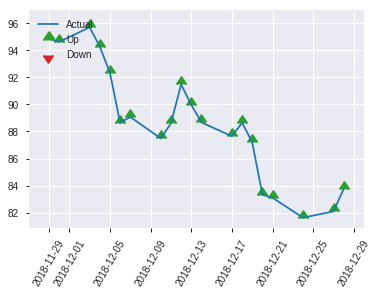


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5069881217320706
RMSE: 0.7120309836882597
LogLoss: 3.414747861273094
Mean Per-Class Error: 0.4318473792394655
AUC: 0.5626927029804727
pr_auc: 0.5079360568879658
Gini: 0.12538540596094538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5229816027757637: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    130  0.9353   (130.0/139.0)
1      1    111  0.0089   (1.0/112.0)
Total  10   241  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.522982     0.628895  238
max f2                       0.0693283    0.805755  244
max f0point5                 0.998546     0.523649  117
max accuracy                 0.99995      0.593625  33
max precision                0.999999     0.75      1
max recall                   0.0693283    1         244
max specificity              1            0.992806  0
max absolute_mcc             0.99995      0.158603  33
max min_per_class_accuracy   0.998415     0.5625    120
max mean_per_class_accuracy  0.998546     0.568153  117

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 94.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   1                  1.49405   1.49405            0.666667         1         0.666667                    1                   0.0178571       0.0178571                  49.4048   49.4048
    2        0.0239044                   0.999999           1.49405   1.49405            0.666667         0.999999  0.666667                    0.999999            0.0178571       0.0357143                  49.4048   49.4048
    3        0.0318725                   0.999998           2.24107   1.6808             1                0.999998  0.75                        0.999999            0.0178571       0.0535714                  124.107   68.0804
    4        0.0438247                   0.999997           1.49405   1.62987            0.666667         0.999997  0.727273                    0.999999            0.0178571       0.0714286                  49.4048   62.987
    5        0.0517928                   0.999995           0         1.37912            0                0.999996  0.615385                    0.999998            0               0.0714286                  -100      37.9121
    6        0.103586                    0.99998            1.20673   1.29293            0.538462         0.999988  0.576923                    0.999993            0.0625          0.133929                   20.6731   29.2926
    7        0.151394                    0.999948           1.49405   1.35644            0.666667         0.999959  0.605263                    0.999982            0.0714286       0.205357                   49.4048   35.6438
    8        0.203187                    0.999917           1.03434   1.27433            0.461538         0.999931  0.568627                    0.999969            0.0535714       0.258929                   3.43407   27.4335
    9        0.302789                    0.999764           0.986071  1.17951            0.44             0.999838  0.526316                    0.999926            0.0982143       0.357143                   -1.39286  17.9511
    10       0.40239                     0.999146           0.896429  1.10944            0.4              0.999453  0.49505                     0.999809            0.0892857       0.446429                   -10.3571  10.9441
    11       0.501992                    0.998316           1.255     1.13832            0.56             0.998714  0.507937                    0.999592            0.125           0.571429                   25.5      13.8322
    12       0.601594                    0.995682           0.6275    1.05375            0.28             0.997105  0.470199                    0.99918             0.0625          0.633929                   -37.25    5.37488
    13       0.701195                    0.991092           0.6275    0.993202           0.28             0.993683  0.443182                    0.998399            0.0625          0.696429                   -37.25    -0.679789
    14       0.800797                    0.975937           1.43429   1.04806            0.64             0.982657  0.467662                    0.996441            0.142857        0.839286                   43.4286   4.80633
    15       0.900398                    0.911226           0.896429  1.03129            0.4              0.946906  0.460177                    0.990962            0.0892857       0.928571                   -10.3571  3.12895
    16       1                           2.61511e-08        0.717143  1                  0.32             0.528651  0.446215                    0.944915        

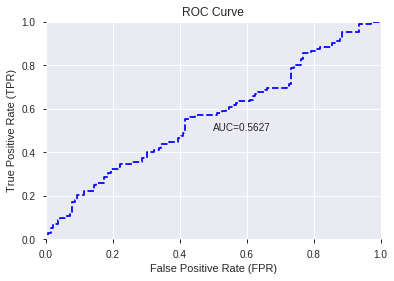

This function is available for GLM models only


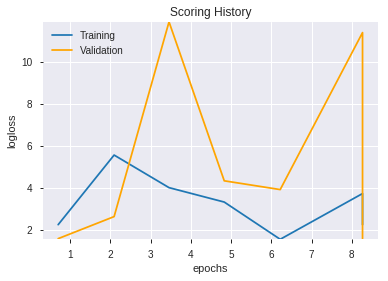

--2019-08-27 14:52:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_143038_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_143038_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_middleband_14_5_5',
 'BBANDS_upperband_30_2_2',
 'CDL3LINESTRIKE',
 'MAVP_30_5',
 'STOCHRSI_fastk',
 'aroonup_8',
 'CDLONNECK',
 'MACDFIX_hist_8',
 'BBANDS_middleband_20_0_4',
 'PLUS_DI_8',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_middleband_30_2_4',
 'CDLHIKKAKE',
 'BBANDS_lowerband_30_1_3',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_upperband_20_5_4',
 'ROCR_24',
 'BBANDS_lowerband_30_6_3',
 'MAVP_20_5',
 'BBANDS_lowerband_14_7_3',
 'aroonup_14',
 'BBANDS_middleband_12_0_5',
 'BBANDS_upperband_30_2_4',
 'PLUS_DM_14',
 'BBANDS_upperband_30_7_5',
 'MA_14_5',
 'BBANDS_middleband_20_7_4',
 'DX_12',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_middleband_30_2_3',
 'MINUS_DI_30',
 'RSI_14',
 'BBANDS_middleband_24_2_2',
 'BBANDS_upperband_14_5_4',
 'ADXR_8',
 'ADX_20',
 'BBANDS_upperband_20_0_4',
 'ROCP_12',
 'BBANDS_upperband_14_7_3',
 'MACDFIX_24',
 'CORREL_20',
 'MA_14_4',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_2_4',
 'MA_14_1',
 'ATR_8',
 'BBANDS_upperband_14_6_4',
 'MFI_8',
 'MINUS_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_145253_model_1  0.51304  0.687714              0.486479  0.497279  0.247286

variable  relative_importance  scaled_importance    percentage
0                   CDLHARAMI         8.734517e-03           1.000000  1.805301e-02
1              CDLSPINNINGTOP         5.711878e-03           0.653943  1.180564e-02
2           HT_PHASOR_inphase         5.481348e-03           0.627550  1.132917e-02
3           CDL3WHITESOLDIERS         5.464466e-03           0.625617  1.129428e-02
4                  aroonup_20         5.328558e-03           0.610058  1.101338e-02
..                        ...                  ...                ...           ...
676  BBANDS_middleband_30_7_3         3.265805e-06           0.000374  6.749958e-06
677                   MA_20_6         1.988684e-06           0.000228  4.110329e-06
678                   BETA_14         7.302692e-07           0.000084  1.509363e-06
679  BBANDS_middleband_30_6_5         2.784330e-07           0.000032  5.754815e-07
680  BBANDS_middleband_30_7_4         1.079422e-07           0.000012  2.231013e-07

[681 rows x 4 columns]

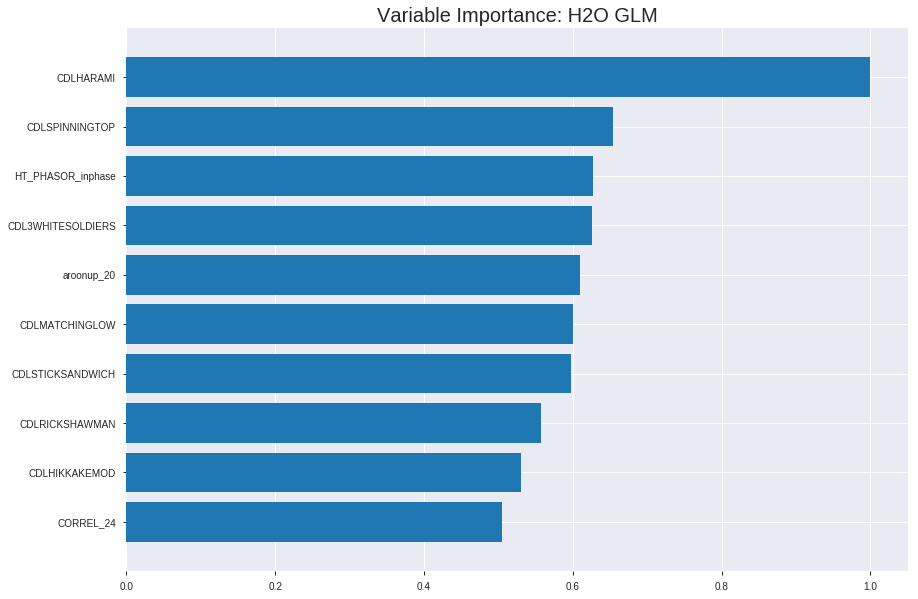

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_145253_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24674809500748596
RMSE: 0.49673745078007353
LogLoss: 0.6866157588809451
Null degrees of freedom: 1752
Residual degrees of freedom: 1071
Null deviance: 2422.359308081908
Residual deviance: 2407.2748506365933
AIC: 3771.2748506365933
AUC: 0.5718107291816482
pr_auc: 0.5953789234244482
Gini: 0.14362145836329643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47776760425260156: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    814   0.9951   (814.0/818.0)
1      0    935   0        (0.0/935.0)
Total  4    1749  0.4643   (814.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477768     0.696721  395
max f2                       0.477768     0.851703  395
max f0point5                 0.512635     0.60047   302
max accuracy                 0.512635     0.561894  302
max precision                0.593456     0.75      2
max recall                   0.477768     1         395
max specificity              0.606411     0.998778  0
max absolute_mcc             0.550094     0.120803  107
max min_per_class_accuracy   0.534159     0.55379   193
max mean_per_class_accuracy  0.53435      0.555429  192

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.581116           1.04159   1.04159            0.555556         0.588452  0.555556                    0.588452            0.0106952       0.0106952                  4.15924    4.15924
    2        0.0205362                   0.575256           1.24991   1.14575            0.666667         0.578275  0.611111                    0.583364            0.0128342       0.0235294                  24.9911    14.5752
    3        0.0302339                   0.570805           1.32344   1.20274            0.705882         0.572986  0.641509                    0.580035            0.0128342       0.0363636                  32.3435    20.2744
    4        0.040502                    0.567791           1.45823   1.26752            0.777778         0.569077  0.676056                    0.577257            0.0149733       0.0513369                  45.8229    26.7515
    5        0.0501997                   0.565968           1.10286   1.23571            0.588235         0.566988  0.659091                    0.575273            0.0106952       0.0620321                  10.2863    23.5707
    6        0.100399                    0.559823           1.38484   1.31028            0.738636         0.562872  0.698864                    0.569072            0.0695187       0.131551                   38.4844    31.0276
    7        0.150029                    0.55399            1.14216   1.25466            0.609195         0.557045  0.669202                    0.565094            0.0566845       0.188235                   14.216     25.4663
    8        0.200228                    0.550593           1.08657   1.21252            0.579545         0.552316  0.646724                    0.56189             0.0545455       0.242781                   8.65702    21.252
    9        0.300057                    0.544313           0.97493   1.13347            0.52             0.547146  0.604563                    0.556985            0.0973262       0.340107                   -2.50695   13.3474
    10       0.399886                    0.539199           1.03921   1.10994            0.554286         0.541717  0.592011                    0.553173            0.103743        0.44385                    3.92116    10.9942
    11       0.500285                    0.534179           1.07592   1.10311            0.573864         0.536543  0.588369                    0.549836            0.108021        0.551872                   7.59176    10.3114
    12       0.600114                    0.528504           0.899936  1.06932            0.48             0.53153   0.570342                    0.546791            0.0898396       0.641711                   -10.0064   6.93154
    13       0.699943                    0.522847           0.996358  1.05891            0.531429         0.525734  0.564792                    0.543788            0.0994652       0.741176                   -0.364248  5.89098
    14       0.799772                    0.515346           0.878509  1.03639            0.468571         0.519489  0.552782                    0.540755            0.0877005       0.828877                   -12.1491   3.63919
    15       0.899601                    0.50618            0.878509  1.01887            0.468571         0.511351  0.543437                    0.537492            0.0877005       0.916578                   -12.1491   1.88715
    16       1                           0.470528           0.830907  1                  0.443182         0.496453  0.533371                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.249426291324982
RMSE: 0.4994259618051328
LogLoss: 0.6919980471868273
Null degrees of freedom: 500
Residual degrees of freedom: -181
Null deviance: 692.8933692915758
Residual deviance: 693.3820432812008
AIC: 2057.382043281201
AUC: 0.5238727214582667
pr_auc: 0.5563899213775071
Gini: 0.047745442916533376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4607665414267872: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    235  0.9958   (235.0/236.0)
1      0    265  0        (0.0/265.0)
Total  1    500  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.460767     0.69281    398
max f2                       0.460767     0.849359   398
max f0point5                 0.460767     0.584989   398
max accuracy                 0.490679     0.536926   287
max precision                0.556242     1          0
max recall                   0.460767     1          398
max specificity              0.556242     1          0
max absolute_mcc             0.534518     0.0693747  11
max min_per_class_accuracy   0.502806     0.520755   200
max mean_per_class_accuracy  0.502372     0.528054   204

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.537432           1.26038   1.26038            0.666667         0.543576  0.666667                    0.543576            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.534727           1.51245   1.37496            0.8              0.53587   0.727273                    0.540073            0.0150943       0.0301887                  51.2453   37.4957
    3        0.0319361                   0.532354           0.756226  1.1816             0.4              0.533516  0.625                       0.538024            0.00754717      0.0377358                  -24.3774  18.1604
    4        0.0419162                   0.530871           0.756226  1.08032            0.4              0.531543  0.571429                    0.536481            0.00754717      0.045283                   -24.3774  8.03235
    5        0.0518962                   0.528731           0.756226  1.018              0.4              0.529627  0.538462                    0.535163            0.00754717      0.0528302                  -24.3774  1.79971
    6        0.101796                    0.524826           1.28558   1.14917            0.68             0.527116  0.607843                    0.531218            0.0641509       0.116981                   28.5585   14.9168
    7        0.151697                    0.522208           0.907472  1.06966            0.48             0.523483  0.565789                    0.528674            0.045283        0.162264                   -9.25283  6.96624
    8        0.201597                    0.518491           1.13434   1.08567            0.6              0.520332  0.574257                    0.526609            0.0566038       0.218868                   13.434    8.56716
    9        0.301397                    0.511741           1.05872   1.07675            0.56             0.514807  0.569536                    0.522701            0.10566         0.324528                   5.8717    7.67462
    10       0.401198                    0.50747            0.831849  1.01583            0.44             0.509548  0.537313                    0.519429            0.0830189       0.407547                   -16.8151  1.58265
    11       0.500998                    0.502751           1.13434   1.03943            0.6              0.504807  0.549801                    0.516517            0.113208        0.520755                   13.434    3.94347
    12       0.600798                    0.499169           0.86966   1.01123            0.46             0.500996  0.534884                    0.513938            0.0867925       0.607547                   -13.034   1.1233
    13       0.700599                    0.493056           0.907472  0.996452           0.48             0.496246  0.527066                    0.511418            0.090566        0.698113                   -9.25283  -0.354781
    14       0.800399                    0.486934           1.13434   1.01365            0.6              0.490036  0.53616                     0.508752            0.113208        0.811321                   13.434    1.36451
    15       0.9002                      0.480191           0.907472  1.00187            0.48             0.483611  0.529933                    0.505965            0.090566        0.901887                   -9.25283  0.187424
    16       1                           0.45493            0.983094  1                  0.52             0.473143  0.528942                    0.502689       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:52:55  0.000 sec   2            3.4       682           1.37323           1.384
    2019-08-27 14:52:56  0.991 sec   4            2.5       682           1.37115           1.38458
    2019-08-27 14:52:57  2.035 sec   6            1.8       682           1.36868           1.38533
    2019-08-27 14:52:58  3.075 sec   8            1.3       682           1.36579           1.38631
    2019-08-27 14:52:59  4.158 sec   10           0.97      682           1.36249           1.38752

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6218487394957983)

('auc', 0.5130395683453237)

('logloss', 0.6877135588588588)

('mean_per_class_error', 0.4567381808838643)

('rmse', 0.4972790490830018)

('mse', 0.24728645265689453)

glm prediction progress: |████████████████████████████████████████████████| 100%


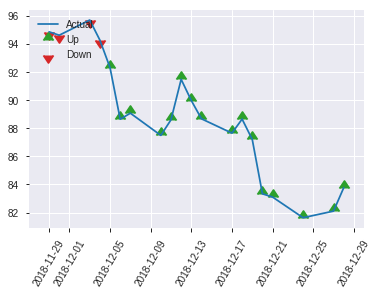


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24728645265689453
RMSE: 0.4972790490830018
LogLoss: 0.6877135588588588
Null degrees of freedom: 250
Residual degrees of freedom: -431
Null deviance: 352.68995809423006
Residual deviance: 345.23220654714714
AIC: 1709.2322065471471
AUC: 0.5130395683453237
pr_auc: 0.46931584692740236
Gini: 0.02607913669064743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4364001321677256: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    134  0.964    (134.0/139.0)
1      1    111  0.0089   (1.0/112.0)
Total  6    245  0.5378   (135.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4364       0.621849  244
max f2                       0.428044     0.803443  248
max f0point5                 0.4364       0.508242  244
max accuracy                 0.489323     0.577689  43
max precision                0.503698     0.647059  16
max recall                   0.428044     1         248
max specificity              0.55438      0.992806  0
max absolute_mcc             0.489323     0.11312   43
max min_per_class_accuracy   0.46408      0.508929  123
max mean_per_class_accuracy  0.489323     0.543262  43

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 46.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.538821           0.747024  0.747024           0.333333         0.545487  0.333333                    0.545487            0.00892857      0.00892857                 -25.2976  -25.2976
    2        0.0239044                   0.533041           1.49405   1.12054            0.666667         0.534829  0.5                         0.540158            0.0178571       0.0267857                  49.4048   12.0536
    3        0.0318725                   0.526946           1.12054   1.12054            0.5              0.528457  0.5                         0.537233            0.00892857      0.0357143                  12.0536   12.0536
    4        0.0438247                   0.513726           1.49405   1.2224             0.666667         0.518408  0.545455                    0.532099            0.0178571       0.0535714                  49.4048   22.2403
    5        0.0517928                   0.509011           1.12054   1.20673            0.5              0.50959   0.538462                    0.528636            0.00892857      0.0625                     12.0536   20.6731
    6        0.103586                    0.496694           1.20673   1.20673            0.538462         0.50119   0.538462                    0.514913            0.0625          0.125                      20.6731   20.6731
    7        0.151394                    0.491375           1.30729   1.23849            0.583333         0.493658  0.552632                    0.508201            0.0625          0.1875                     30.7292   23.8487
    8        0.203187                    0.485687           0.861951  1.14251            0.384615         0.488703  0.509804                    0.503231            0.0446429       0.232143                   -13.8049  14.2507
    9        0.302789                    0.475435           0.896429  1.06156            0.4              0.480857  0.473684                    0.495871            0.0892857       0.321429                   -10.3571  6.15602
    10       0.40239                     0.469251           0.896429  1.02069            0.4              0.47206   0.455446                    0.489977            0.0892857       0.410714                   -10.3571  2.0686
    11       0.501992                    0.463486           0.986071  1.01382            0.44             0.466003  0.452381                    0.48522             0.0982143       0.508929                   -1.39286  1.3818
    12       0.601594                    0.46012            0.986071  1.00922            0.44             0.461744  0.450331                    0.481334            0.0982143       0.607143                   -1.39286  0.922422
    13       0.701195                    0.456531           0.806786  0.980469           0.36             0.457988  0.4375                      0.478017            0.0803571       0.6875                     -19.3214  -1.95312
    14       0.800797                    0.451535           1.07571   0.992315           0.48             0.454161  0.442786                    0.47505             0.107143        0.794643                   7.57143   -0.768479
    15       0.900398                    0.44568            0.896429  0.981708           0.4              0.449309  0.438053                    0.472203            0.0892857       0.883929                   -10.3571  -1.82917
    16       1                           0.421463           1.16536   1                  0.52             0.438744  0.446215                    0.46887      

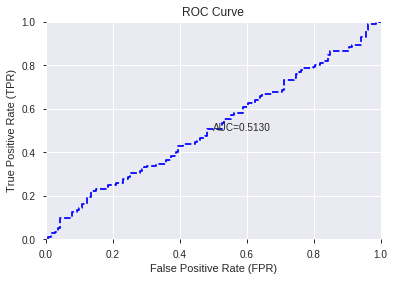

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


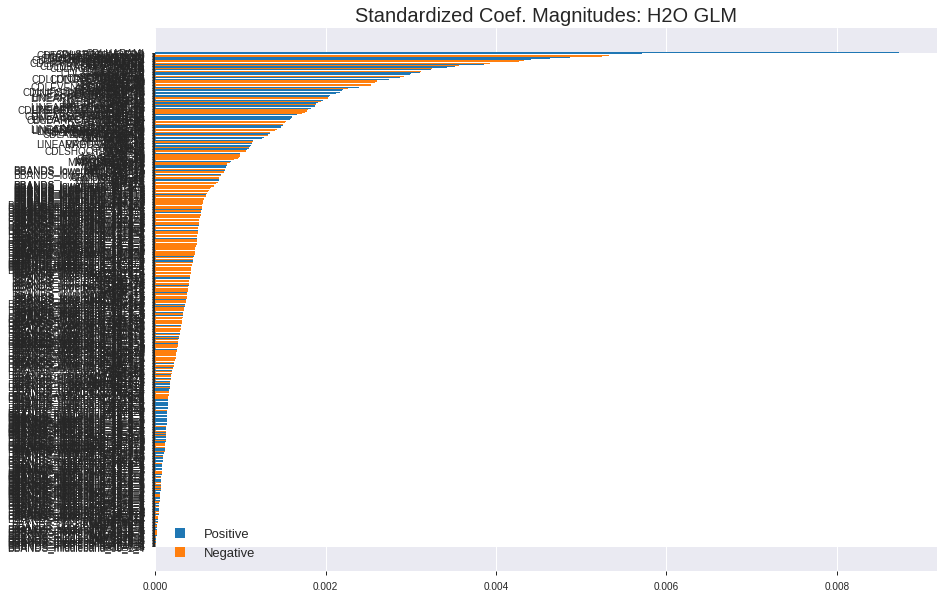

'log_likelihood'
--2019-08-27 14:53:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_145253_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_145253_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLHARAMI',
 'CDLSPINNINGTOP',
 'HT_PHASOR_inphase',
 'CDL3WHITESOLDIERS',
 'aroonup_20',
 'CDLMATCHINGLOW',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'CDLHIKKAKEMOD',
 'CORREL_24',
 'CDLSEPARATINGLINES',
 'STOCHRSI_fastd',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLONNECK',
 'CDLLONGLINE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'VAR_24',
 'CDL2CROWS',
 'CDLMORNINGSTAR',
 'CCI_8',
 'BOP',
 'CORREL_30',
 'NATR_8',
 'aroonup_8',
 'CDL3LINESTRIKE',
 'aroonup_24',
 'aroondown_12',
 'STDDEV_24',
 'VAR_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLENGULFING',
 'CDLLONGLEGGEDDOJI',
 'CDLUNIQUE3RIVER',
 'BETA_12',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'CDLDOJI',
 'ADOSC',
 'PLUS_DI_30',
 'AROONOSC_8',
 'STOCH_slowd',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKE',
 'NATR_12',
 'CDL3OUTSIDE',
 'HT_DCPERIOD',
 'STDDEV_30',
 'CDLUPSIDEGAP2CROWS',
 'LINEARREG_SLOPE_14',
 'MINUS_DI_30',
 'CDLSHORTLINE',
 'AROONOSC_20',
 'aroonup_30',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_14',
 'ROCR10

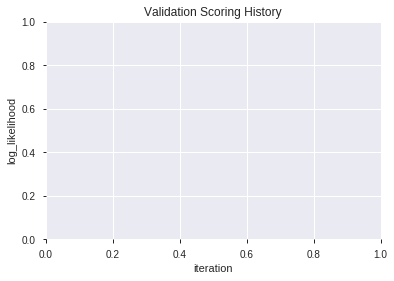

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_145328  0.539054  0.691594              0.500000  0.498873  0.248875
1               XGBoost_2_AutoML_20190827_145328  0.519142  0.694427              0.500000  0.500044  0.250044
2  XGBoost_grid_1_AutoML_20190827_145328_model_5  0.518692  0.739664              0.496403  0.516889  0.267174
3  XGBoost_grid_1_AutoML_20190827_145328_model_1  0.511915  0.699989              0.496403  0.502817  0.252825
4  XGBoost_grid_1_AutoML_20190827_145328_model_2  0.503404  0.688899              0.492806  0.497847  0.247851
5  XGBoost_grid_1_AutoML_20190827_145328_model_6  0.493191  0.719164              0.496403  0.510562  0.260673
6               XGBoost_1_AutoML_20190827_145328  0.490879  0.709297              0.500000  0.506884  0.256932
7  XGBoost_grid_1_AutoML_20190827_145328_model_3  0.487795  0.718948              0.496403  0.511184  0.261309
8  XGBoost_grid_1_AutoML_20190827_145328_model_4  0.485804  0.695552              0.490943  0.501144  0.251145
9  XGBoost_grid_1_AutoML_20190827_145328_model_7  0.424139  0.724103              0.479284  0.514052  0.264249

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           108.252609           1.000000    0.021140
1                     NATR_8            92.215210           0.851852    0.018008
2                    BETA_12            90.548775           0.836458    0.017683
3                        BOP            82.461922           0.761755    0.016103
4                  PLUS_DM_8            71.007835           0.655946    0.013867
..                       ...                  ...                ...         ...
255  BBANDS_lowerband_20_0_4             1.969011           0.018189    0.000385
256  BBANDS_lowerband_30_0_5             1.107609           0.010232    0.000216
257  BBANDS_upperband_12_6_3             1.105799           0.010215    0.000216
258  BBANDS_lowerband_30_7_4             0.848833           0.007841    0.000166
259                  SAR_0.3             0.019104           0.000176    0.000004

[260 rows x 4 columns]

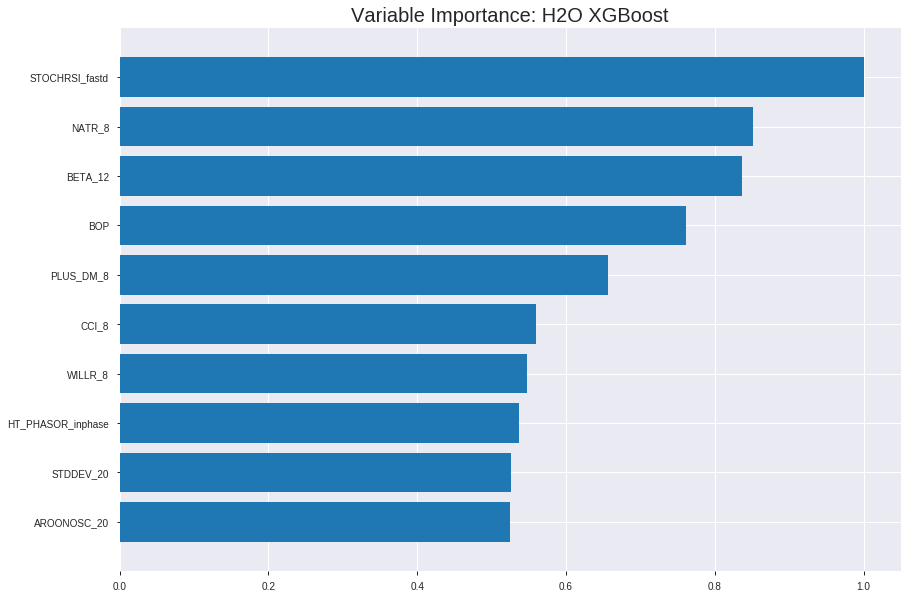

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_145328


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18237778726608317
RMSE: 0.42705712412519614
LogLoss: 0.5543360622477234
Mean Per-Class Error: 0.11582050913274844
AUC: 0.9513074800936155
pr_auc: 0.9574480919675613
Gini: 0.9026149601872311
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5240564346313477: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      719  99   0.121    (99.0/818.0)
1      108  827  0.1155   (108.0/935.0)
Total  827  926  0.1181   (207.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.524056     0.888769  193
max f2                       0.483538     0.92502   238
max f0point5                 0.55593      0.910459  160
max accuracy                 0.535        0.882487  181
max precision                0.74663      1         0
max recall                   0.387252     1         332
max specificity              0.74663      1         0
max absolute_mcc             0.535        0.766646  181
max min_per_class_accuracy   0.525523     0.881283  191
max mean_per_class_accuracy  0.535        0.884179  181

Gains/Lift Table: Avg response rate: 53.34 %, avg score: 53.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.718676           1.87487    1.87487            1                0.729751  1                           0.729751            0.0192513       0.0192513                  87.4866   87.4866
    2        0.0205362                   0.709625           1.87487    1.87487            1                0.713009  1                           0.72138             0.0192513       0.0385027                  87.4866   87.4866
    3        0.0302339                   0.701114           1.87487    1.87487            1                0.705442  1                           0.716268            0.0181818       0.0566845                  87.4866   87.4866
    4        0.040502                    0.690166           1.87487    1.87487            1                0.695779  1                           0.711074            0.0192513       0.0759358                  87.4866   87.4866
    5        0.0501997                   0.684938           1.87487    1.87487            1                0.687868  1                           0.706591            0.0181818       0.0941176                  87.4866   87.4866
    6        0.100399                    0.662068           1.87487    1.87487            1                0.673627  1                           0.690109            0.0941176       0.188235                   87.4866   87.4866
    7        0.150029                    0.642823           1.87487    1.87487            1                0.651226  1                           0.677247            0.0930481       0.281283                   87.4866   87.4866
    8        0.200228                    0.625281           1.83226    1.86418            0.977273         0.633277  0.994302                    0.666223            0.0919786       0.373262                   83.2256   86.4183
    9        0.300057                    0.595766           1.76773    1.83209            0.942857         0.612477  0.977186                    0.648342            0.176471        0.549733                   76.7731   83.2094
    10       0.399886                    0.565429           1.68202    1.79463            0.897143         0.580363  0.957204                    0.631371            0.167914        0.717647                   68.2023   79.463
    11       0.500285                    0.534654           1.40615    1.71667            0.75             0.550314  0.915621                    0.615104            0.141176        0.858824                   40.615    71.6668
    12       0.600114                    0.503068           0.739233   1.55407            0.394286         0.517873  0.828897                    0.59893             0.0737968       0.93262                    -26.0767  55.4072
    13       0.699943                    0.472885           0.428541   1.39354            0.228571         0.488268  0.743276                    0.583147            0.0427807       0.975401                   -57.1459  39.3544
    14       0.799772                    0.440527           0.18213    1.24233            0.0971429        0.457119  0.662625                    0.567416            0.0181818       0.993583                   -81.787   24.2333
    15       0.899601                    0.391452           0.0535676  1.11042            0.0285714        0.418817  0.592264                    0.550926            0.00534759      0.99893                    -94.6432  11.0415
    16       1                           0.192215           0.0106526  1                  0.00568182       0.347968  0.533371                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2601969818795795
RMSE: 0.510095071412751
LogLoss: 0.7146047251093937
Mean Per-Class Error: 0.47422449632235375
AUC: 0.5202670291013751
pr_auc: 0.5503711555935711
Gini: 0.040534058202750245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29766079783439636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   224  0.9492   (224.0/236.0)
1      4    261  0.0151   (4.0/265.0)
Total  16   485  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297661     0.696     384
max f2                       0.272951     0.849904  397
max f0point5                 0.297661     0.591837  384
max accuracy                 0.301694     0.54491   381
max precision                0.688471     1         0
max recall                   0.272951     1         397
max specificity              0.688471     1         0
max absolute_mcc             0.297661     0.101499  384
max min_per_class_accuracy   0.456279     0.512712  201
max mean_per_class_accuracy  0.498082     0.525776  145

Gains/Lift Table: Avg response rate: 52.89 %, avg score: 45.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.634572           1.26038   1.26038            0.666667         0.665589  0.666667                    0.665589            0.0150943       0.0150943                  26.0377   26.0377
    2        0.0219561                   0.622624           1.89057   1.54683            1                0.626821  0.818182                    0.647967            0.0188679       0.0339623                  89.0566   54.6827
    3        0.0319361                   0.615777           0.756226  1.29976            0.4              0.618478  0.6875                      0.638752            0.00754717      0.0415094                  -24.3774  29.9764
    4        0.0419162                   0.605763           0.756226  1.17035            0.4              0.610096  0.619048                    0.631929            0.00754717      0.0490566                  -24.3774  17.035
    5        0.0518962                   0.593408           1.13434   1.16343            0.6              0.599055  0.615385                    0.625607            0.0113208       0.0603774                  13.434    16.3425
    6        0.101796                    0.570613           1.05872   1.1121             0.56             0.581107  0.588235                    0.603793            0.0528302       0.113208                   5.8717    11.2098
    7        0.151697                    0.550182           0.983094  1.06966            0.52             0.556989  0.565789                    0.588397            0.0490566       0.162264                   -1.69057  6.96624
    8        0.201597                    0.536407           0.907472  1.02952            0.48             0.54253   0.544554                    0.577044            0.045283        0.207547                   -9.25283  2.95162
    9        0.301397                    0.508109           1.02091   1.02667            0.54             0.522757  0.543046                    0.559068            0.101887        0.309434                   2.09057   2.6665
    10       0.401198                    0.486741           1.09653   1.04404            0.58             0.497423  0.552239                    0.543734            0.109434        0.418868                   9.65283   4.40439
    11       0.500998                    0.456252           0.945283  1.02437            0.5              0.470857  0.541833                    0.529216            0.0943396       0.513208                   -5.4717   2.43704
    12       0.600798                    0.417474           1.02091   1.02379            0.54             0.435721  0.541528                    0.513686            0.101887        0.615094                   2.09057   2.37949
    13       0.700599                    0.387696           0.907472  1.00722            0.48             0.402832  0.532764                    0.497895            0.090566        0.70566                    -9.25283  0.722464
    14       0.800399                    0.357794           0.945283  0.999501           0.5              0.371795  0.528678                    0.482171            0.0943396       0.8                        -5.4717   -0.0498753
    15       0.9002                      0.327883           1.09653   1.01026            0.58             0.34135   0.534368                    0.466559            0.109434        0.909434                   9.65283   1.02581
    16       1                           0.259123           0.907472  1                  0.48             0.305347  0.528942                    0.45047        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:53:38  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.466629                         0.5                0.693147              0.5               0                    1                  0.471058
    2019-08-27 14:53:38  0.793 sec   5                  0.492308         0.677851            0.745107        0.766946           1.80543          0.347975                         0.501611           0.696393              0.51822           0.531244             0.787736           0.471058
    2019-08-27 14:53:38  0.962 sec   10                 0.481704         0.657047            0.819658        0.836226           1.87487          0.282373                         0.503307           0.69991               0.520723          0.54097              0.540162           0.46507
    2019-08-27 14:53:39  1.124 sec   15                 0.474266         0.64263             0.855008        0.873254           1.87487          0.231603                         0.504199           0.701788              0.522801          0.548197             1.26038            0.469062
    2019-08-27 14:53:39  1.294 sec   20                 0.466679         0.628085            0.880077        0.895582           1.87487          0.212778                         0.503935           0.701251              0.528606          0.549443             1.26038            0.46507
    2019-08-27 14:53:39  1.472 sec   25                 0.458434         0.612418            0.899251        0.913998           1.87487          0.196805                         0.503838           0.701071              0.537824          0.551587             1.26038            0.457086
    2019-08-27 14:53:39  1.643 sec   30                 0.452222         0.60066             0.909584        0.921831           1.87487          0.177981                         0.507173           0.708107              0.523617          0.545781             0.945283           0.457086
    2019-08-27 14:53:39  1.811 sec   35                 0.445882         0.588874            0.923708        0.932593           1.87487          0.155163                         0.506684           0.707107              0.524097          0.547707             1.26038            0.457086
    2019-08-27 14:53:40  1.972 sec   40                 0.439941         0.577901            0.934359        0.942652           1.87487          0.143754                         0.50893            0.71195               0.521554          0.544405             0.945283           0.459082
    2019-08-27 14:53:40  2.134 sec   45                 0.434384         0.567676            0.941702        0.949058           1.87487          0.13919                          0.511343           0.717248              0.516701          0.545922             1.26038            0.45509
    2019-08-27 14:53:40  2.306 sec   50                 0.427057         0.554336            0.951307        0.957448           1.87487          0.118083                         0.510095           0.714605              0.520267          0.550371             1.26038            0.45509

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
STOCHRSI_fastd           108.25260925292969     1.0                    0.02113999682132344
NATR_8                   92.2152099609375       0.8518520763363664     0.01800815018598856
BETA_12                  90.54877471923828      0.8364581264519286     0.01768272213436393
BOP                      82.46192169189453      0.7617545873580209     0.01610348955537711
PLUS_DM_8                71.0078353881836       0.6559457169505767     0.013866690371295917
---                      ---                    ---                    ---
BBANDS_lowerband_20_0_4  1.969010829925537      0.01818903806119804    0.0003845162067966576
BBANDS_lowerband_30_0_5  1.1076087951660156     0.010231705293847593   0.00021629821738865633
BBANDS_upperband_12_6_3  1.1057991981506348     0.010214988865228742   0.00021594483214078998
BBANDS_lowerband_30_7_4  0.8488330841064453     0.007841225167359862   0.00016576347511326886
SAR_0.3                  0.01910400390625       0.0001764761518275642  3.7307052886741e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.6170798898071626)

('auc', 0.539054470709147)

('logloss', 0.6915938110476192)

('mean_per_class_error', 0.4425102774922919)

('rmse', 0.4988733276687878)

('mse', 0.24887459705932968)

xgboost prediction progress: |████████████████████████████████████████████| 100%


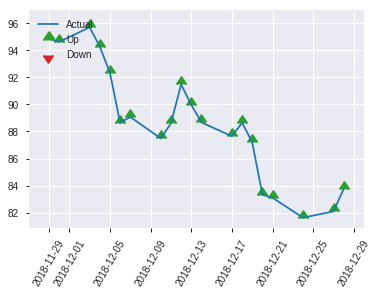


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24887459705932968
RMSE: 0.4988733276687878
LogLoss: 0.6915938110476192
Mean Per-Class Error: 0.4425102774922919
AUC: 0.539054470709147
pr_auc: 0.4847744218335459
Gini: 0.07810894141829405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2763662040233612: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    139  1        (139.0/139.0)
1      0    112  0        (0.0/112.0)
Total  0    251  0.5538   (139.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.276366     0.61708   250
max f2                       0.276366     0.801144  250
max f0point5                 0.402009     0.510563  113
max accuracy                 0.455032     0.581673  50
max precision                0.572537     0.666667  5
max recall                   0.276366     1         250
max specificity              0.618984     0.992806  0
max absolute_mcc             0.455032     0.124352  50
max min_per_class_accuracy   0.397172     0.535714  122
max mean_per_class_accuracy  0.402009     0.55749   113

Gains/Lift Table: Avg response rate: 44.62 %, avg score: 40.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.607209           0.747024  0.747024           0.333333         0.616342  0.333333                    0.616342            0.00892857      0.00892857                 -25.2976  -25.2976
    2        0.0239044                   0.572537           2.24107   1.49405            1                0.584113  0.666667                    0.600228            0.0267857       0.0357143                  124.107   49.4048
    3        0.0318725                   0.561217           0         1.12054            0                0.565436  0.5                         0.59153             0               0.0357143                  -100      12.0536
    4        0.0438247                   0.553029           0.747024  1.01867            0.333333         0.556507  0.454545                    0.581978            0.00892857      0.0446429                  -25.2976  1.86688
    5        0.0517928                   0.543435           2.24107   1.20673            1                0.546871  0.538462                    0.576577            0.0178571       0.0625                     124.107   20.6731
    6        0.103586                    0.505739           1.20673   1.20673            0.538462         0.522753  0.538462                    0.549665            0.0625          0.125                      20.6731   20.6731
    7        0.151394                    0.466603           1.30729   1.23849            0.583333         0.490242  0.552632                    0.5309              0.0625          0.1875                     30.7292   23.8487
    8        0.203187                    0.455032           1.37912   1.27433            0.615385         0.46009   0.568627                    0.51285             0.0714286       0.258929                   37.9121   27.4335
    9        0.302789                    0.423129           0.717143  1.09105            0.32             0.433846  0.486842                    0.486862            0.0714286       0.330357                   -28.2857  9.10479
    10       0.40239                     0.405524           1.07571   1.08725            0.48             0.414366  0.485149                    0.468917            0.107143        0.4375                     7.57143   8.72525
    11       0.501992                    0.3952             0.986071  1.06718            0.44             0.401255  0.47619                     0.455492            0.0982143       0.535714                   -1.39286  6.71769
    12       0.601594                    0.376411           1.07571   1.06859            0.48             0.385384  0.476821                    0.443885            0.107143        0.642857                   7.57143   6.85904
    13       0.701195                    0.360209           0.6275    1.00594            0.28             0.367051  0.448864                    0.432971            0.0625          0.705357                   -37.25    0.593547
    14       0.800797                    0.342911           0.986071  1.00346            0.44             0.351334  0.447761                    0.422817            0.0982143       0.803571                   -1.39286  0.346482
    15       0.900398                    0.320386           1.07571   1.01146            0.48             0.332038  0.451327                    0.412775            0.107143        0.910714                   7.57143   1.1457
    16       1                           0.276366           0.896429  1                  0.4              0.30553   0.446215                    0.402093       

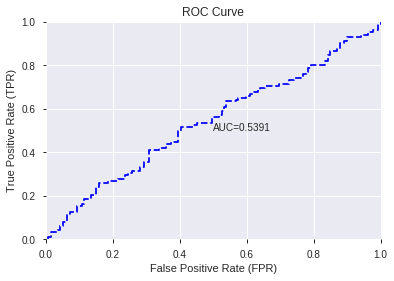

This function is available for GLM models only


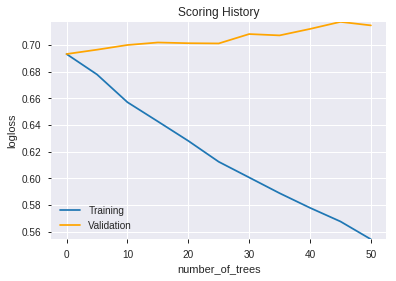

--2019-08-27 14:54:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_145328',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_145328',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8ce1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_8ce1',
   'ty

['STOCHRSI_fastd',
 'NATR_8',
 'BETA_12',
 'BOP',
 'PLUS_DM_8',
 'CCI_8',
 'WILLR_8',
 'HT_PHASOR_inphase',
 'STDDEV_20',
 'AROONOSC_20',
 'ADXR_12',
 'HT_DCPERIOD',
 'DX_12',
 'AROONOSC_24',
 'APO',
 'DX_30',
 'DX_14',
 'MACDFIX_hist_20',
 'ADOSC',
 'LINEARREG_ANGLE_24',
 'ADX_20',
 'CORREL_30',
 'CORREL_8',
 'PLUS_DI_8',
 'STDDEV_8',
 'BETA_8',
 'ULTOSC',
 'MFI_12',
 'NATR_12',
 'aroondown_20',
 'PLUS_DM_24',
 'MACDEXT_signal',
 'STOCHF_fastk',
 'PLUS_DI_20',
 'MACDEXT_hist',
 'CCI_14',
 'LINEARREG_ANGLE_30',
 'CCI_20',
 'MOM_30',
 'MFI_20',
 'WILLR_12',
 'CCI_12',
 'WILLR_14',
 'ADX_24',
 'STOCH_slowd',
 'BETA_14',
 'NATR_14',
 'MFI_8',
 'LINEARREG_ANGLE_8',
 'DX_20',
 'MOM_12',
 'BBANDS_lowerband_20_0_5',
 'VAR_12',
 'MFI_24',
 'CORREL_14',
 'BBANDS_lowerband_14_3_5',
 'MACDFIX_hist_8',
 'MACDFIX_12',
 'OBV',
 'STDDEV_30',
 'BETA_30',
 'DX_24',
 'MACDFIX_signal_12',
 'BBANDS_lowerband_24_1_4',
 'MACDFIX_hist_24',
 'ROC_12',
 'MINUS_DM_8',
 'CORREL_12',
 'DX_8',
 'LINEARREG_INTERCEP

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.594
GLM             0.590
XGBoost         0.582
dtype: float64

DeepLearning    GLM  XGBoost
All          0.446  0.446    0.574
DLF          0.574  0.590    0.566
Fwe          0.446  0.446    0.574
RFE          0.594  0.578    0.582
XGBF         0.554  0.590    0.566





F1


DeepLearning    0.629
GLM             0.622
XGBoost         0.627
dtype: float64

DeepLearning    GLM  XGBoost
All          0.617  0.617    0.619
DLF          0.617  0.619    0.627
Fwe          0.617  0.617    0.619
RFE          0.629  0.622    0.617
XGBF         0.617  0.619    0.627





auc


DeepLearning    0.563
GLM             0.513
XGBoost         0.543
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.543
DLF          0.556  0.510    0.518
Fwe          0.500  0.500    0.543
RFE          0.563  0.513    0.539
XGBF         0.557  0.510    0.518





logloss


DeepLearning    15.412
GLM             15.412
XGBoost          0.699
dtype: float64

DeepLearning     GLM  XGBoost
All         15.412  15.412    0.688
DLF          0.715   0.701    0.699
Fwe          0.703  15.412    0.688
RFE          3.415   0.688    0.692
XGBF         0.703   0.701    0.699





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.463
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.442
DLF          0.438  0.445    0.463
Fwe          0.500  0.500    0.442
RFE          0.432  0.457    0.443
XGBF         0.426  0.445    0.463





rmse


DeepLearning    0.712
GLM             0.668
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.668  0.668    0.497
DLF          0.510  0.504    0.503
Fwe          0.505  0.668    0.497
RFE          0.712  0.497    0.499
XGBF         0.505  0.504    0.503





mse


DeepLearning    0.507
GLM             0.446
XGBoost         0.253
dtype: float64

DeepLearning    GLM  XGBoost
All          0.446  0.446    0.247
DLF          0.260  0.254    0.253
Fwe          0.255  0.446    0.247
RFE          0.507  0.247    0.249
XGBF         0.255  0.254    0.253

{'F1':       DeepLearning    GLM  XGBoost
 All          0.617    NaN      NaN
 DLF          0.617    NaN      NaN
 DLF            NaN  0.619      NaN
 DLF            NaN    NaN    0.627
 All            NaN  0.617      NaN
 All            NaN    NaN    0.619
 XGBF         0.617    NaN      NaN
 XGBF           NaN  0.619      NaN
 XGBF           NaN    NaN    0.627
 Fwe          0.617    NaN      NaN
 Fwe            NaN  0.617      NaN
 Fwe            NaN    NaN    0.619
 RFE          0.629    NaN      NaN
 RFE            NaN  0.622      NaN
 RFE            NaN    NaN    0.617,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.446    NaN      NaN
 DLF          0.574    NaN      NaN
 DLF            NaN  0.590      NaN
 DLF            NaN    NaN    0.566
 All            NaN  0.446      NaN
 All            NaN    NaN    0.574
 XGBF         0.554    NaN      NaN
 XGBF           NaN  0.590      NaN
 XGBF           NaN    NaN    0.566
 Fwe          0.446    NaN      NaN
 Fwe     